In [1]:
import sys
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from torch.utils.data import DataLoader
sys.path.append("../input/iterative-stratification/iterative-stratification-master")
sys.path.append("../input/node-base/modules/datasets")
sys.path.append("../input/node-base/modules/facebookresearch")
sys.path.append("../input/node-base/modules/losses")
sys.path.append("../input/node-base/modules/Qwicen")
sys.path.append("../input/node-base/modules/trainer")
sys.path.append("../input/node-base/modules/utils")
import node
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from Tab_dataset import MoaDataset
from qhoptim import QHAdam
from tab_trainer import mean_log_loss
from tab_trainer import TabTrainer
from utils import seed_everything
from utils import create_logger
from utils import get_logger
from preprocess import preprocess_pipeline
from label_smooth_loss import SmoothBCEwLogits
warnings.filterwarnings("ignore")
DEBUG = False
oof_list = []
preds_list = []
No = "009-2"
create_logger(No)
logging = get_logger(No)
logging.info("start process.")

[INFO] 2020-11-30 12:47:17,212 >>	start process.


## TabNet by Narita

In [2]:
scores_auc_all = []
test_cv_preds = []
MAX_EPOCH = 200
NB_SPLITS = 3

# TabNet
!pip install --no-index --find-links /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl pytorch-tabnet
# Iterative Stratification
!pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

### General ###
import os
import sys
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../input/rank-gauss")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats
from gauss_rank_scaler import GaussRankScaler

### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Machine Learning ###
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

### Make prettier the prints ###
from colorama import Fore
c_ = Fore.CYAN
m_ = Fore.MAGENTA
r_ = Fore.RED
b_ = Fore.BLUE
y_ = Fore.YELLOW
g_ = Fore.GREEN

seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

# Parameters
data_path = "../input/lish-moa/"
no_ctl = True
scale = "rankgauss"
variance_threshould = 0.7
decompo = "PCA"
ncompo_genes = 80
ncompo_cells = 10
ica_ncompo_genes = 80
ica_ncompo_cells = 10
encoding = "dummy"

train = pd.read_csv(data_path + "train_features.csv")
#train.drop(columns = ["sig_id"], inplace = True)

targets = pd.read_csv(data_path + "train_targets_scored.csv")
#train_targets_scored.drop(columns = ["sig_id"], inplace = True)

#train_targets_nonscored = pd.read_csv(data_path + "train_targets_nonscored.csv")

test = pd.read_csv(data_path + "test_features.csv")
#test.drop(columns = ["sig_id"], inplace = True)

submission = pd.read_csv(data_path + "sample_submission.csv")

if no_ctl:
    # cp_type == ctl_vehicle
    print(b_, "not_ctl")
    train = train[train["cp_type"] != "ctl_vehicle"]
    test = test[test["cp_type"] != "ctl_vehicle"]
    targets = targets.iloc[train.index]
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    targets.reset_index(drop = True, inplace = True)

GENES = [col for col in train.columns if col.startswith("g-")]
CELLS = [col for col in train.columns if col.startswith("c-")]

data_all = pd.concat([train, test], ignore_index = True)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]
mask = (data_all[cols_numeric].var() >= variance_threshould).values
tmp = data_all[cols_numeric].loc[:, mask]
data_all = pd.concat([data_all[["sig_id", "cp_type", "cp_time", "cp_dose"]], tmp], axis = 1)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]

def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())

def scale_norm(col):
    return (col - col.mean()) / col.std()

if scale == "boxcox":
    print(b_, "boxcox")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    trans = []
    for feat in cols_numeric:
        trans_var, lambda_var = stats.boxcox(data_all[feat].dropna() + 1)
        trans.append(scale_minmax(trans_var))
    data_all[cols_numeric] = np.asarray(trans).T
    
elif scale == "norm":
    print(b_, "norm")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_norm, axis = 0)
    
elif scale == "minmax":
    print(b_, "minmax")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    
elif scale == "rankgauss":
    ### Rank Gauss ###
    print(b_, "Rank Gauss")
    scaler = GaussRankScaler()
    data_all[cols_numeric] = scaler.fit_transform(data_all[cols_numeric])
    
else:
    pass

# PCA
if decompo == "PCA":
    print(b_, "PCA")
    GENES = [col for col in data_all.columns if col.startswith("g-")]
    CELLS = [col for col in data_all.columns if col.startswith("c-")]
    
    pca_genes = PCA(n_components = ncompo_genes,
                    random_state = seed).fit_transform(data_all[GENES])
    pca_cells = PCA(n_components = ncompo_cells,
                    random_state = seed).fit_transform(data_all[CELLS])
    
    pca_genes = pd.DataFrame(pca_genes, columns = [f"pca_g-{i}" for i in range(ncompo_genes)])
    pca_cells = pd.DataFrame(pca_cells, columns = [f"pca_c-{i}" for i in range(ncompo_cells)])
    data_all = pd.concat([data_all, pca_genes, pca_cells], axis = 1)
else:
    pass

GENES = [col for col in data_all.columns if col.startswith("g-")]
CELLS = [col for col in data_all.columns if col.startswith("c-")]

ica_genes = FastICA(n_components = ica_ncompo_genes,
                    random_state = seed).fit_transform(data_all[GENES])
ica_cells = FastICA(n_components = ica_ncompo_cells,
                    random_state = seed).fit_transform(data_all[CELLS])

ica_genes = pd.DataFrame(ica_genes, columns = [f"ica_g-{i}" for i in range(ica_ncompo_genes)])
ica_cells = pd.DataFrame(ica_cells, columns = [f"ica_c-{i}" for i in range(ica_ncompo_cells)])
data_all = pd.concat([data_all, ica_genes, ica_cells], axis = 1)

# Encoding
if encoding == "lb":
    print(b_, "Label Encoding")
    for feat in ["cp_time", "cp_dose"]:
        data_all[feat] = LabelEncoder().fit_transform(data_all[feat])
elif encoding == "dummy":
    print(b_, "One-Hot")
    data_all = pd.get_dummies(data_all, columns = ["cp_time", "cp_dose"])
    
GENES = [col for col in data_all.columns if col.startswith("g-")]
CELLS = [col for col in data_all.columns if col.startswith("c-")]

for stats in tqdm.tqdm(["sum", "mean", "std", "kurt", "skew"]):
    data_all["g_" + stats] = getattr(data_all[GENES], stats)(axis = 1)
    data_all["c_" + stats] = getattr(data_all[CELLS], stats)(axis = 1)    
    data_all["gc_" + stats] = getattr(data_all[GENES + CELLS], stats)(axis = 1)

with open("data_all.pickle", "wb") as f:
    pickle.dump(data_all, f)

with open("data_all.pickle", "rb") as f:
    data_all = pickle.load(f)

# train_df and test_df
features_to_drop = ["cp_type"]
data_all.drop(features_to_drop, axis = 1, inplace = True)
train_df = data_all[: train.shape[0]]
train_df.reset_index(drop = True, inplace = True)
# The following line it's a bad practice in my opinion, targets on train set
#train_df = pd.concat([train_df, targets], axis = 1)
test_df = data_all[train_df.shape[0]: ]
test_df.reset_index(drop = True, inplace = True)

print(f"{b_}train_df.shape: {r_}{train_df.shape}")
print(f"{b_}test_df.shape: {r_}{test_df.shape}")

X_test = test_df.drop("sig_id", axis=1).values
print(f"{b_}X_test.shape: {r_}{X_test.shape}")

# n_d and n_a are different from the original work, 32 instead of 24
# This is the first change in the code from the original
tabnet_params = dict(
    n_d = 32,
    n_a = 32,
    n_steps = 1,
    gamma = 1.3,
    lambda_sparse = 0,
    optimizer_fn = optim.Adam,
    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
    scheduler_fn = ReduceLROnPlateau,
    seed = seed,
    verbose = 10
)

class LogitsLogLoss(Metric):
    """
    LogLoss with sigmoid applied
    """

    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        """
        Compute LogLoss of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            LogLoss of predictions vs targets.
        """
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 1e-15) + y_true * np.log(logits + 1e-15)
        return np.mean(-aux)

#mskf = MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = 0, shuffle = True)

#oof_preds = []
#oof_targets = []
#scores = []
#scores_auc = []

#train_df = train_df_org.copy()
#X_test = X_test_org.copy()

for random_state in [0, 1]:
    mskf = MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = random_state, shuffle = True)
    if random_state > 0:
        train_df_org = train_df.copy()
        X_test_org = X_test.copy()
        train_df = pd.merge(train_df, oof_x, on='sig_id')
        X_test = np.concatenate([X_test, test_x], axis=1)
        X_test = pd.DataFrame(X_test, columns=train_df.columns[1:])
        # cate drop
        cate_cols = ['cp_time_24','cp_time_48','cp_time_72','cp_dose_D1','cp_dose_D2']
        train_df = train_df.drop(cate_cols, axis=1)
        X_test = X_test.drop(cate_cols, axis=1)
        
        all_data = np.concatenate([train_df.iloc[:, 1:].values, X_test.values], axis=0)
        
        sc = StandardScaler()
        z_all_data = sc.fit_transform(all_data)
        x_tr = z_all_data[:train_df.shape[0],:]
        x_te = z_all_data[train_df.shape[0]:,:]
        x_tr = pd.DataFrame(x_tr, index=train_df.index, columns=train_df.columns[1:])
        x_tr = pd.concat([train_df.iloc[:, 0], x_tr], axis=1)
        train_df = x_tr
        X_test = x_te
        
    print(b_,"SEED: ", r_, random_state)
    print(g_, '*' * 60, c_)
    
    oof_preds = []
    oof_targets = []
    scores = []
    scores_auc = []
    for fold_nb, (train_idx, val_idx) in enumerate(mskf.split(train_df, targets)):
        print(b_,"FOLDS: ", r_, fold_nb + 1)
        print(g_, '*' * 60, c_)

        X_train, y_train = train_df.iloc[train_idx, 1:].values, targets.iloc[train_idx, 1:].values
        X_val, y_val = train_df.iloc[val_idx, 1:].values, targets.iloc[val_idx, 1:].values
        ### Model ###
        model = TabNetRegressor(**tabnet_params)

        ### Fit ###
        # Another change to the original code
        # virtual_batch_size of 32 instead of 128
        model.fit(
            X_train = X_train,
            y_train = y_train,
            eval_set = [(X_val, y_val)],
            eval_name = ["val"],
            eval_metric = ["logits_ll"],
            max_epochs = MAX_EPOCH,
            patience = 15,
            batch_size = 1024, 
            virtual_batch_size = 32,
            num_workers = 1,
            drop_last = False,
            # To use binary cross entropy because this is not a regression problem
            loss_fn = F.binary_cross_entropy_with_logits
        )
        print(y_, '-' * 60)

        ### Predict on validation ###
        preds_val = model.predict(X_val)
        valid_explain, _ = model.explain(X_val)
        if fold_nb == 0:
            valid_explains = valid_explain
        else:
            valid_explains = np.concatenate([valid_explains, valid_explain], axis=0)
        # Apply sigmoid to the predictions
        preds = 1 / (1 + np.exp(-preds_val))
        score = np.min(model.history["val_logits_ll"])
        ### Save OOF for CV ###
        oof_preds.append(preds_val) # preds
        oof_targets.append(y_val)
        scores.append(score)

        ### Predict on test ###
        preds_test = model.predict(X_test)
        test_explain, _ = model.explain(X_test)
        if fold_nb == 0:
            test_explains = test_explain
        else:
            test_explains = np.concatenate([test_explains, test_explain], axis=0)
        test_cv_preds.append(1 / (1 + np.exp(-preds_test)))
        
        if fold_nb == 0:
            # train
            oof_x = pd.DataFrame(preds_val, index=val_idx, columns = [f"pred_{target}" for target in targets.columns[1:]])
            oof_x = pd.concat([train_df.iloc[val_idx, 0], oof_x], axis=1) # concat id
            #print(oof_x.shape)
            oof_explain = pd.DataFrame(valid_explain, index=val_idx, columns = [f"explain_{feature}" for feature in train_df.columns[1:]])
            #print(oof_explain.shape)
            oof_x = pd.concat([oof_x, oof_explain], axis=1)
            #print(oof_x.shape)
            # test
            test_x = preds_test / NB_SPLITS
            test_explain = test_explain / NB_SPLITS
            test_x = np.concatenate([test_x, test_explain], axis=1)
        elif fold_nb > 0:
            # train
            oof_x_ = pd.DataFrame(preds_val, index=val_idx, columns = [f"pred_{target}" for target in targets.columns[1:]])
            oof_x_ = pd.concat([train_df.iloc[val_idx, 0], oof_x_], axis=1) # concat id
            oof_explain_ = pd.DataFrame(valid_explain, index=val_idx, columns = [f"explain_{feature}" for feature in train_df.columns[1:]])
            oof_x_ = pd.concat([oof_x_, oof_explain_], axis=1)
            # test
            test_x_ = preds_test / NB_SPLITS
            test_explain_ = test_explain / NB_SPLITS
            test_x_ = np.concatenate([test_x_, test_explain_], axis=1)
            #print(oof_x.shape, oof_x_.shape)
            # concat axis=0
            oof_x = pd.concat([oof_x, oof_x_], axis=0)
            test_x += test_x_
    
    #oof_x = oof_x.sort_index()

    #valid_explains = pd.DataFrame(valid_explains, columns=train_df.columns)
    #test_explains = pd.DataFrame(test_explains, columns=train_df.columns)
    oof_preds_all = np.concatenate(oof_preds)
    oof_targets_all = np.concatenate(oof_targets)
    test_preds_all = np.stack(test_cv_preds)

aucs = []
for task_id in range(oof_preds_all.shape[1]):
    aucs.append(roc_auc_score(y_true = oof_targets_all[:, task_id],
                              y_score = oof_preds_all[:, task_id]
                             ))
print(f"{b_}Overall AUC: {r_}{np.mean(aucs)}")
print(f"{b_}Average CV: {r_}{np.mean(scores)}")

targets = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
oof_target = pd.merge(oof_x.iloc[:,:207], targets, on='sig_id', how='right')
oof_target = oof_target.fillna(0)

oof_tab = oof_target.iloc[:,:207]
tmp = oof_tab.drop("sig_id",axis=1)
oof_tab.iloc[:,1:] = 1 / (1 + np.exp(-tmp))
oof_tab.to_csv("oof_tab.csv")
oof_list.append(oof_tab)

all_feat = [col for col in submission.columns if col not in ["sig_id"]]
# To obtain the same lenght of test_preds_all and submission
test = pd.read_csv(data_path + "test_features.csv")
sig_id = test[test["cp_type"] != "ctl_vehicle"].sig_id.reset_index(drop = True)
tmp = pd.DataFrame(test_preds_all[5:,:,:].mean(axis=0), columns = all_feat)
tmp["sig_id"] = sig_id

submission = pd.merge(test[["sig_id"]], tmp, on = "sig_id", how = "left")
submission.fillna(0, inplace = True)

#submission[all_feat] = tmp.mean(axis = 0)

# Set control to 0
#submission.loc[test["cp_type"] == 0, submission.columns[1:]] = 0
submission.to_csv("tab_submission.csv", index = None)

preds_list.append(submission)

print(f"{b_}submission.shape: {r_}{submission.shape}")

#Overall AUC: 0.7476299061567433
#Average CV: 0.016676474311527602

Looking in links: /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl
Processing /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl
Processing /kaggle/input/iterative-stratification/iterative-stratification-master
  Created wheel for iterative-stratification: filename=iterative_stratification-0.1.6-py3-none-any.whl size=8401 sha256=c27ef7a3d75096364345951405e7ed0cd5d0304fa9041a54d50802fe3c2c63a8
  Stored in directory: /root/.cache/pip/wheels/b8/47/3f/eb4af42d124f37d23d6f13a4c8bbc32c1d70140e6e1cecb4aa
Successfully built iterative-stratification
 not_ctl
 Rank Gauss
 PCA
 One-Hot


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


train_df.shape: (21948, 1038)
test_df.shape: (3624, 1038)
X_test.shape: (3624, 1037)
 SEED:   0
 ************************************************************ 
 FOLDS:   1
 ************************************************************ 
Device used : cuda
epoch 0  | loss: 0.44904 | val_logits_ll: 0.09639 |  0:00:03s
epoch 10 | loss: 0.02013 | val_logits_ll: 0.01984 |  0:00:23s
epoch 20 | loss: 0.01782 | val_logits_ll: 0.02047 |  0:00:43s
epoch 30 | loss: 0.01721 | val_logits_ll: 0.01791 |  0:01:05s
epoch 40 | loss: 0.01669 | val_logits_ll: 0.01766 |  0:01:25s
epoch 50 | loss: 0.01642 | val_logits_ll: 0.0174  |  0:01:45s
epoch 60 | loss: 0.01611 | val_logits_ll: 0.01721 |  0:02:07s
epoch 70 | loss: 0.0157  | val_logits_ll: 0.01791 |  0:02:28s
epoch 80 | loss: 0.01528 | val_logits_ll: 0.01716 |  0:02:50s

Early stopping occured at epoch 87 with best_epoch = 72 and best_val_logits_ll = 0.01707
Best weights from best epoch are automatically used!
 ---------------------------------------------

## NODE model seed 1

In [3]:
No = "009-2"
conf_path = f"../input/node-base/conf/tuning/node.v{No}.yaml"
with open(conf_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config["train_max_steps"] = 2200
config["outdir"] = f"exp/node/v{No}"
config["batch_size"] = 256
config["n_fold"] = 5
for k, v in config.items():
    logging.info(f'{k}: {v}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(config["seed"])

# resumes = ["" for _ in range(config["n_fold"])]
resumes = [""]
resumes += [f"{config['outdir']}/best/best_loss{fold}fold.pkl" for fold in range(config["n_fold"] - 1)]
logging.info(f"resumes: {resumes}")
checkpoints = [f"{config['outdir']}/best/best_loss{fold}fold.pkl" for fold in range(config["n_fold"])]
logging.info(f"checkpoints: {checkpoints}")
# optional
is_pseudo_label = True
pseudo_label_threshold = 0.95

[INFO] 2020-11-30 13:09:17,436 >>	seed: 4
[INFO] 2020-11-30 13:09:17,437 >>	is_concat: True
[INFO] 2020-11-30 13:09:17,438 >>	norm_type: RankGauss
[INFO] 2020-11-30 13:09:17,439 >>	QuantileTransformer: {'n_quantiles': 100, 'random_state': 1, 'output_distribution': 'normal'}
[INFO] 2020-11-30 13:09:17,440 >>	pca_threshold: 0.9
[INFO] 2020-11-30 13:09:17,442 >>	VarianceThreshold: 0
[INFO] 2020-11-30 13:09:17,443 >>	n_cluster_g: 20
[INFO] 2020-11-30 13:09:17,444 >>	n_cluster_c: 10
[INFO] 2020-11-30 13:09:17,445 >>	BayesianGaussianMixture_g: {'n_components': 40, 'covariance_type': 'diag', 'max_iter': 2000, 'random_state': 1, 'n_init': 3, 'weight_concentration_prior_type': 'dirichlet_process', 'verbose': -1}
[INFO] 2020-11-30 13:09:17,446 >>	BayesianGaussianMixture_c: {'n_components': 20, 'covariance_type': 'diag', 'max_iter': 2000, 'random_state': 1, 'n_init': 3, 'weight_concentration_prior_type': 'dirichlet_process', 'verbose': -1}
[INFO] 2020-11-30 13:09:17,447 >>	model_type: NODE
[INFO]

In [4]:
# preprocess
train_features = pd.read_csv("../input/lish-moa/train_features.csv")
train_targets = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
test_features = pd.read_csv("../input/lish-moa/test_features.csv")
logging.info("Successfully load input files.")
train_, test_ = preprocess_pipeline(train_features, test_features, config, path="", is_concat=config.get("is_concat", False))
drop_idx = train_["cp_type"] == 0
drop_cols = train_.columns[train_.std() < 0.2]
print(len(drop_cols), drop_cols)
train = train_.drop(columns=drop_cols)
test = test_.drop(columns=drop_cols)
top_feats = np.arange(train.shape[1])
train = train.loc[drop_idx].reset_index(drop=True)
del train_targets["sig_id"]
train_targets = train_targets.loc[drop_idx].reset_index(drop=True)
targets = [col for col in train_targets.columns]
train = train.values
test = test.values
train_targets = train_targets.values
ntargets = train_targets.shape[1]

logging.info("Successfully preprocessed.")
logging.info(f"{train.shape}, {test.shape}, {train_targets.shape}")

[INFO] 2020-11-30 13:09:21,887 >>	Successfully load input files.


Successfully caluculate original statistics.
Caution: You use test data to make rank gauss feature.
Successfully caluculate RankGauss.
Successfully caluculate RankGauss statistics.
Caution: You use test data to make PCA feature.
Caution: You use test data to make PCA feature.
Caution: You use test data to make zscore feature.
Successfully caluculate PCA.
Successfully caluculate k-means++.
Caution: You use test data to make dpgmm feature.
Successfully caluculate dpgmm-g.
Caution: You use test data to make dpgmm feature.
Successfully caluculate dpgmm-c.
Successfully decode categorical features.
52 Index(['dpgmm_g-0', 'dpgmm_g-2', 'dpgmm_g-3', 'dpgmm_g-4', 'dpgmm_g-7',
       'dpgmm_g-8', 'dpgmm_g-9', 'dpgmm_g-10', 'dpgmm_g-11', 'dpgmm_g-12',
       'dpgmm_g-13', 'dpgmm_g-14', 'dpgmm_g-15', 'dpgmm_g-16', 'dpgmm_g-17',
       'dpgmm_g-18', 'dpgmm_g-19', 'dpgmm_g-20', 'dpgmm_g-21', 'dpgmm_g-22',
       'dpgmm_g-23', 'dpgmm_g-24', 'dpgmm_g-25', 'dpgmm_g-26', 'dpgmm_g-27',
       'dpgmm_g-28'

[INFO] 2020-11-30 13:14:16,545 >>	Successfully preprocessed.
[INFO] 2020-11-30 13:14:16,546 >>	(21948, 1452), (3982, 1452), (21948, 206)


In [5]:
# training
if config.get("loss_type", "BCELoss") == "SmoothBCEwLogits":
    loss_class = SmoothBCEwLogits
else:
    loss_class = getattr(
        torch.nn,
        # keep compatibility
        config.get("loss_type", "BCELoss"),
    )
criterion = loss_class(**config["loss_params"]).to(device)
model_class = getattr(
    node,
    # keep compatibility
    config.get("model_type", "NODE"),
)
oof_targets = np.zeros((len(train), config["out_dim"]))
# for GPU/CPU
kfold = MultilabelStratifiedKFold(
    n_splits=config["n_fold"], random_state=config["seed"], shuffle=True
)
for n, (tr, te) in enumerate(kfold.split(train_targets, train_targets)):
    logging.info(f"Start to train fold {n}.")
    xtrain, xval = train[tr], train[te]
    ytrain, yval = train_targets[tr], train_targets[te]
    if is_pseudo_label and (n >= 1):
        logging.info(f"The number of pseudo labels is {add_ytrain.shape}")
        xtrain = np.concatenate([xtrain, add_xtrain], axis=0)
        ytrain = np.concatenate([ytrain, add_ytrain], axis=0)
    train_set = MoaDataset(xtrain, ytrain, top_feats)
    val_set = MoaDataset(xval, yval, top_feats)
    logging.info(
        f"train_set:{train_set[0]['X'].shape}, val_set:{val_set[0]['X'].shape}"
    )

    data_loader = {
        "train": DataLoader(
            train_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=True,
        ),
        "dev": DataLoader(
            val_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=False,
        ),
        "eval": DataLoader(
            val_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=False,
        ),
    }
    model = model_class(
        input_dim=len(top_feats),
        out_dim=config["out_dim"],
        **config["model_params"],
    ).to(device)

    if config["optimizer_type"] == "QHAdam":
        optimizer_class = QHAdam
    else:
        optimizer_class = getattr(
            torch.optim,
            # keep compatibility
            config.get("optimizer_type", "Adam"),
        )
    optimizer = optimizer_class(
        params=model.parameters(), **config["optimizer_params"]
    )

    scheduler_class = getattr(
        torch.optim.lr_scheduler,
        # keep compatibility
        config.get("scheduler_type", "StepLR"),
    )
    scheduler = scheduler_class(optimizer=optimizer, **config["scheduler_params"])
    trainer = TabTrainer(
        steps=0,
        epochs=0,
        data_loader=data_loader,
        model=model.to(device),
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        config=config,
        device=device,
        add_name=f"{n}fold",
        train=True,
        is_kernel=True,
        verbose=15,
    )
    # resume from checkpoint
    if len(resumes[n]) != 0:
        trainer.load_checkpoint(resumes[n])
        trainer.steps = 0
        logging.info(f"Successfully resumed from {resumes[n]}.")

    # run training loop
    try:
        logging.info("Start training!")
        trainer.run()
    except KeyboardInterrupt:
        trainer.save_checkpoint(
            os.path.join(config["outdir"], f"checkpoint-{trainer.steps}steps.pkl")
        )
        logging.info(f"Successfully saved checkpoint @ {trainer.steps}steps.")
    trainer.load_checkpoint(checkpoints[n])
    logging.info(f"Successfully load checkpoint from {checkpoints[n]}.")
    oof_targets[te] = trainer.inference()
    logging.info(f"Successfully inference dev data at fold{n}.")
    fold_score = mean_log_loss(yval, oof_targets[te])
    logging.info(
        f"fold{n} score: {fold_score:.6f}, Step:{trainer.steps}, Epoch:{trainer.epochs}."
    )
    if is_pseudo_label:
        add_train_idx = (oof_targets > pseudo_label_threshold).any(axis=1)
        add_ytrain = oof_targets[add_train_idx]
        add_xtrain = train[add_train_idx]
        
# calculate oof score
cv_score = mean_log_loss(train_targets, oof_targets)
logging.info(f"CV score: {cv_score:.6f}")
oof = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
oof.loc[drop_idx, targets] = oof_targets
oof_path = os.path.join(config["outdir"], "node_fine_oof.csv")
oof.to_csv(oof_path, index=False)
# save oof
logging.info(f"saved at {oof_path}")
oof_list.append(oof)

# inference
eval_set = MoaDataset(test, None, top_feats, mode="test")
eval_loader = {
    "eval": DataLoader(
        eval_set,
        batch_size=config["batch_size"],
        num_workers=config["num_workers"],
        pin_memory=config["pin_memory"],
        shuffle=False,
    ),
}
preds = np.zeros((len(checkpoints), len(test), ntargets))
for n, checkpoint in enumerate(checkpoints):
    logging.info(f"Start to train fold {n}.")
    model = model_class(
        input_dim=len(top_feats),
        out_dim=config["out_dim"],
        **config["model_params"],
    ).to(device)
    # eval data
    trainer = TabTrainer(
        steps=0,
        epochs=0,
        data_loader=eval_loader,
        model=model.to(device),
        criterion={},
        optimizer={},
        scheduler={},
        config=config,
        device=device,
        add_name=f"{n}fold",
    )
    trainer.load_checkpoint(checkpoint)
    logging.info(f"Successfully load checkpoint from {checkpoint}.")
    # run training loop
    preds[n] = trainer.inference()
    logging.info(f"Successfully inference eval data at fold{n}.\nStep:{trainer.steps}, Epoch:{trainer.epochs}")

# calculate eval data's submission file
preds_mean = preds.mean(axis=0)
ss = pd.read_csv("../input/lish-moa/sample_submission.csv")
ss[targets] = preds_mean
ss.loc[test_features["cp_type"] == "ctl_vehicle", targets] = 0
sub_path = os.path.join("submission.csv")
ss.to_csv(sub_path, index=False)
logging.info(f"saved at {sub_path}")
preds_list.append(ss)

[INFO] 2020-11-30 13:14:18,424 >>	Start to train fold 0.
[INFO] 2020-11-30 13:14:18,741 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:14:18,827 >>	Start training!
[train]:   3%|▎         | 69/2200 [00:06<03:16, 10.82it/s]

(Steps: 69) Finished 0 epoch training (69 steps per epoch).
(Epoch: 0) train/loss = 0.00001.
(Epoch: 0) train/epoch_metric = 0.58754.
(Epoch: 0) train/epoch_auc = 0.58125.
(Epoch: 0) train/epoch_acc = 0.70983.
(Epoch: 0) train/epoch_recall = 0.40113.
(Epoch: 0) train/epoch_precision = 0.00517.


[train]:   6%|▌         | 137/2200 [00:17<02:45, 12.50it/s]

(Steps: 138) Finished 1 epoch training (69 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.17893.
(Epoch: 1) train/epoch_auc = 0.59697.
(Epoch: 1) train/epoch_acc = 0.99176.
(Epoch: 1) train/epoch_recall = 0.10199.
(Epoch: 1) train/epoch_precision = 0.07205.


[train]:   9%|▉         | 207/2200 [00:27<02:16, 14.56it/s]

(Steps: 207) Finished 2 epoch training (69 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.05413.
(Epoch: 2) train/epoch_auc = 0.61306.
(Epoch: 2) train/epoch_acc = 0.99646.
(Epoch: 2) train/epoch_recall = 0.07425.
(Epoch: 2) train/epoch_precision = 0.74869.


[train]:  12%|█▎        | 275/2200 [00:38<02:12, 14.56it/s]

(Steps: 276) Finished 3 epoch training (69 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02856.
(Epoch: 3) train/epoch_auc = 0.64773.
(Epoch: 3) train/epoch_acc = 0.99650.
(Epoch: 3) train/epoch_recall = 0.07447.
(Epoch: 3) train/epoch_precision = 0.83597.


[train]:  16%|█▌        | 345/2200 [00:48<02:19, 13.34it/s]

(Steps: 345) Finished 4 epoch training (69 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.02251.
(Epoch: 4) train/epoch_auc = 0.70109.
(Epoch: 4) train/epoch_acc = 0.99652.
(Epoch: 4) train/epoch_recall = 0.07788.
(Epoch: 4) train/epoch_precision = 0.86349.


[train]:  19%|█▉        | 413/2200 [00:59<02:02, 14.57it/s]

(Steps: 414) Finished 5 epoch training (69 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.02110.
(Epoch: 5) train/epoch_auc = 0.74330.
(Epoch: 5) train/epoch_acc = 0.99655.
(Epoch: 5) train/epoch_recall = 0.08634.
(Epoch: 5) train/epoch_precision = 0.88249.


[train]:  22%|██▏       | 483/2200 [01:09<01:55, 14.83it/s]

(Steps: 483) Finished 6 epoch training (69 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.02059.
(Epoch: 6) train/epoch_auc = 0.77419.
(Epoch: 6) train/epoch_acc = 0.99658.
(Epoch: 6) train/epoch_recall = 0.09450.
(Epoch: 6) train/epoch_precision = 0.88657.


[train]:  25%|██▌       | 551/2200 [01:19<01:54, 14.35it/s]

(Steps: 552) Finished 7 epoch training (69 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.02019.
(Epoch: 7) train/epoch_auc = 0.79843.
(Epoch: 7) train/epoch_acc = 0.99660.
(Epoch: 7) train/epoch_recall = 0.10132.
(Epoch: 7) train/epoch_precision = 0.88817.


[train]:  28%|██▊       | 621/2200 [01:30<01:48, 14.49it/s]

(Steps: 621) Finished 8 epoch training (69 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01980.
(Epoch: 8) train/epoch_auc = 0.81228.
(Epoch: 8) train/epoch_acc = 0.99664.
(Epoch: 8) train/epoch_recall = 0.11030.
(Epoch: 8) train/epoch_precision = 0.90837.


[train]:  31%|███▏      | 689/2200 [01:41<01:43, 14.66it/s]

(Steps: 690) Finished 9 epoch training (69 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01943.
(Epoch: 9) train/epoch_auc = 0.82566.
(Epoch: 9) train/epoch_acc = 0.99668.
(Epoch: 9) train/epoch_recall = 0.11897.
(Epoch: 9) train/epoch_precision = 0.91657.


[train]:  34%|███▍      | 759/2200 [01:51<01:38, 14.68it/s]

(Steps: 759) Finished 10 epoch training (69 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01910.
(Epoch: 10) train/epoch_auc = 0.83274.
(Epoch: 10) train/epoch_acc = 0.99670.
(Epoch: 10) train/epoch_recall = 0.12602.
(Epoch: 10) train/epoch_precision = 0.91148.


[train]:  38%|███▊      | 827/2200 [02:02<01:33, 14.72it/s]

(Steps: 828) Finished 11 epoch training (69 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01883.
(Epoch: 11) train/epoch_auc = 0.84186.
(Epoch: 11) train/epoch_acc = 0.99671.
(Epoch: 11) train/epoch_recall = 0.12899.
(Epoch: 11) train/epoch_precision = 0.91719.


[train]:  41%|████      | 897/2200 [02:12<01:27, 14.81it/s]

(Steps: 897) Finished 12 epoch training (69 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01859.
(Epoch: 12) train/epoch_auc = 0.84858.
(Epoch: 12) train/epoch_acc = 0.99673.
(Epoch: 12) train/epoch_recall = 0.13574.
(Epoch: 12) train/epoch_precision = 0.91317.


[train]:  44%|████▍     | 965/2200 [02:22<01:25, 14.47it/s]

(Steps: 966) Finished 13 epoch training (69 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01839.
(Epoch: 13) train/epoch_auc = 0.85459.
(Epoch: 13) train/epoch_acc = 0.99676.
(Epoch: 13) train/epoch_recall = 0.14041.
(Epoch: 13) train/epoch_precision = 0.93205.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 1035) Finished 14 epoch training (69 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01821.
(Epoch: 14) train/epoch_auc = 0.85963.
(Epoch: 14) train/epoch_acc = 0.99678.
(Epoch: 14) train/epoch_recall = 0.14619.
(Epoch: 14) train/epoch_precision = 0.92753.
(Steps: 1035) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 20.33it/s]


(Steps: 1035) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01828.
(Epoch: 15) dev/epoch_auc = 0.84996.
(Epoch: 15) dev/epoch_acc = 0.99679.
(Epoch: 15) dev/epoch_recall = 0.14694.
(Epoch: 15) dev/epoch_precision = 0.93561.
(Steps: 1035) Start eval data's evaluation.


[train]:  50%|█████     | 1103/2200 [02:46<01:14, 14.80it/s]

(Steps: 1104) Finished 15 epoch training (69 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01801.
(Epoch: 15) train/epoch_auc = 0.86569.
(Epoch: 15) train/epoch_acc = 0.99679.
(Epoch: 15) train/epoch_recall = 0.15198.
(Epoch: 15) train/epoch_precision = 0.92589.


[train]:  53%|█████▎    | 1173/2200 [02:57<01:20, 12.75it/s]

(Steps: 1173) Finished 16 epoch training (69 steps per epoch).
(Epoch: 16) train/loss = 0.00000.
(Epoch: 16) train/epoch_metric = 0.01787.
(Epoch: 16) train/epoch_auc = 0.87189.
(Epoch: 16) train/epoch_acc = 0.99680.
(Epoch: 16) train/epoch_recall = 0.15383.
(Epoch: 16) train/epoch_precision = 0.91933.


[train]:  56%|█████▋    | 1241/2200 [03:07<01:04, 14.82it/s]

(Steps: 1242) Finished 17 epoch training (69 steps per epoch).
(Epoch: 17) train/loss = 0.00000.
(Epoch: 17) train/epoch_metric = 0.01771.
(Epoch: 17) train/epoch_auc = 0.87682.
(Epoch: 17) train/epoch_acc = 0.99682.
(Epoch: 17) train/epoch_recall = 0.16036.
(Epoch: 17) train/epoch_precision = 0.92393.


[train]:  60%|█████▉    | 1311/2200 [03:17<01:00, 14.65it/s]

(Steps: 1311) Finished 18 epoch training (69 steps per epoch).
(Epoch: 18) train/loss = 0.00000.
(Epoch: 18) train/epoch_metric = 0.01760.
(Epoch: 18) train/epoch_auc = 0.88129.
(Epoch: 18) train/epoch_acc = 0.99681.
(Epoch: 18) train/epoch_recall = 0.15880.
(Epoch: 18) train/epoch_precision = 0.92046.


[train]:  63%|██████▎   | 1379/2200 [03:28<00:59, 13.75it/s]

(Steps: 1380) Finished 19 epoch training (69 steps per epoch).
(Epoch: 19) train/loss = 0.00000.
(Epoch: 19) train/epoch_metric = 0.01746.
(Epoch: 19) train/epoch_auc = 0.88659.
(Epoch: 19) train/epoch_acc = 0.99684.
(Epoch: 19) train/epoch_recall = 0.16437.
(Epoch: 19) train/epoch_precision = 0.92953.


[train]:  66%|██████▌   | 1449/2200 [03:39<00:50, 14.73it/s]

(Steps: 1449) Finished 20 epoch training (69 steps per epoch).
(Epoch: 20) train/loss = 0.00000.
(Epoch: 20) train/epoch_metric = 0.01731.
(Epoch: 20) train/epoch_auc = 0.89136.
(Epoch: 20) train/epoch_acc = 0.99686.
(Epoch: 20) train/epoch_recall = 0.17082.
(Epoch: 20) train/epoch_precision = 0.92751.


[train]:  69%|██████▉   | 1517/2200 [03:49<00:51, 13.21it/s]

(Steps: 1518) Finished 21 epoch training (69 steps per epoch).
(Epoch: 21) train/loss = 0.00000.
(Epoch: 21) train/epoch_metric = 0.01723.
(Epoch: 21) train/epoch_auc = 0.89581.
(Epoch: 21) train/epoch_acc = 0.99687.
(Epoch: 21) train/epoch_recall = 0.17193.
(Epoch: 21) train/epoch_precision = 0.93280.


[train]:  72%|███████▏  | 1587/2200 [03:59<00:40, 14.97it/s]

(Steps: 1587) Finished 22 epoch training (69 steps per epoch).
(Epoch: 22) train/loss = 0.00000.
(Epoch: 22) train/epoch_metric = 0.01714.
(Epoch: 22) train/epoch_auc = 0.89928.
(Epoch: 22) train/epoch_acc = 0.99687.
(Epoch: 22) train/epoch_recall = 0.17342.
(Epoch: 22) train/epoch_precision = 0.93333.


[train]:  75%|███████▌  | 1655/2200 [04:09<00:36, 15.04it/s]

(Steps: 1656) Finished 23 epoch training (69 steps per epoch).
(Epoch: 23) train/loss = 0.00000.
(Epoch: 23) train/epoch_metric = 0.01710.
(Epoch: 23) train/epoch_auc = 0.90139.
(Epoch: 23) train/epoch_acc = 0.99688.
(Epoch: 23) train/epoch_recall = 0.17727.
(Epoch: 23) train/epoch_precision = 0.92780.


[train]:  78%|███████▊  | 1725/2200 [04:20<00:30, 15.43it/s]

(Steps: 1725) Finished 24 epoch training (69 steps per epoch).
(Epoch: 24) train/loss = 0.00000.
(Epoch: 24) train/epoch_metric = 0.01698.
(Epoch: 24) train/epoch_auc = 0.90557.
(Epoch: 24) train/epoch_acc = 0.99689.
(Epoch: 24) train/epoch_recall = 0.17994.
(Epoch: 24) train/epoch_precision = 0.93021.


[train]:  82%|████████▏ | 1793/2200 [04:30<00:26, 15.34it/s]

(Steps: 1794) Finished 25 epoch training (69 steps per epoch).
(Epoch: 25) train/loss = 0.00000.
(Epoch: 25) train/epoch_metric = 0.01685.
(Epoch: 25) train/epoch_auc = 0.90974.
(Epoch: 25) train/epoch_acc = 0.99691.
(Epoch: 25) train/epoch_recall = 0.18454.
(Epoch: 25) train/epoch_precision = 0.93675.


[train]:  85%|████████▍ | 1863/2200 [04:41<00:21, 15.47it/s]

(Steps: 1863) Finished 26 epoch training (69 steps per epoch).
(Epoch: 26) train/loss = 0.00000.
(Epoch: 26) train/epoch_metric = 0.01676.
(Epoch: 26) train/epoch_auc = 0.91308.
(Epoch: 26) train/epoch_acc = 0.99692.
(Epoch: 26) train/epoch_recall = 0.18506.
(Epoch: 26) train/epoch_precision = 0.94472.


[train]:  88%|████████▊ | 1931/2200 [04:51<00:17, 15.43it/s]

(Steps: 1932) Finished 27 epoch training (69 steps per epoch).
(Epoch: 27) train/loss = 0.00000.
(Epoch: 27) train/epoch_metric = 0.01670.
(Epoch: 27) train/epoch_auc = 0.91638.
(Epoch: 27) train/epoch_acc = 0.99691.
(Epoch: 27) train/epoch_recall = 0.18395.
(Epoch: 27) train/epoch_precision = 0.93797.


[train]:  91%|█████████ | 2001/2200 [05:01<00:14, 13.71it/s]

(Steps: 2001) Finished 28 epoch training (69 steps per epoch).
(Epoch: 28) train/loss = 0.00000.
(Epoch: 28) train/epoch_metric = 0.01660.
(Epoch: 28) train/epoch_auc = 0.91884.
(Epoch: 28) train/epoch_acc = 0.99694.
(Epoch: 28) train/epoch_recall = 0.18892.
(Epoch: 28) train/epoch_precision = 0.94403.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2070) Finished 29 epoch training (69 steps per epoch).
(Epoch: 29) train/loss = 0.00000.
(Epoch: 29) train/epoch_metric = 0.01649.
(Epoch: 29) train/epoch_auc = 0.92221.
(Epoch: 29) train/epoch_acc = 0.99694.
(Epoch: 29) train/epoch_recall = 0.19092.
(Epoch: 29) train/epoch_precision = 0.93805.
(Steps: 2070) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 18.78it/s]


(Steps: 2070) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 30) dev/loss = 0.00000.
(Epoch: 30) dev/epoch_metric = 0.01732.
(Epoch: 30) dev/epoch_auc = 0.88217.
(Epoch: 30) dev/epoch_acc = 0.99692.
(Epoch: 30) dev/epoch_recall = 0.18084.
(Epoch: 30) dev/epoch_precision = 0.95298.
(Steps: 2070) Start eval data's evaluation.


[train]:  97%|█████████▋| 2139/2200 [05:24<00:03, 15.42it/s]

(Steps: 2139) Finished 30 epoch training (69 steps per epoch).
(Epoch: 30) train/loss = 0.00000.
(Epoch: 30) train/epoch_metric = 0.01644.
(Epoch: 30) train/epoch_auc = 0.92451.
(Epoch: 30) train/epoch_acc = 0.99695.
(Epoch: 30) train/epoch_recall = 0.19337.
(Epoch: 30) train/epoch_precision = 0.94218.


[train]: 100%|██████████| 2200/2200 [05:34<00:00,  6.57it/s]
[INFO] 2020-11-30 13:19:53,609 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss0fold.pkl.
  0%|          | 0/18 [00:00<?, ?it/s]

Finished training.


100%|██████████| 18/18 [00:00<00:00, 26.88it/s]
[INFO] 2020-11-30 13:19:54,300 >>	Successfully inference dev data at fold0.
[INFO] 2020-11-30 13:19:54,638 >>	fold0 score: 0.017321, Step:2070, Epoch:30.
[INFO] 2020-11-30 13:19:54,650 >>	Start to train fold 1.
[INFO] 2020-11-30 13:19:54,815 >>	The number of pseudo labels is (170, 206)
[INFO] 2020-11-30 13:19:55,051 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:19:55,142 >>	Successfully resumed from exp/node/v009-2/best/best_loss0fold.pkl.
[INFO] 2020-11-30 13:19:55,143 >>	Start training!
[train]:   3%|▎         | 70/2200 [00:05<02:19, 15.23it/s]

(Steps: 70) Finished 30 epoch training (70 steps per epoch).
(Epoch: 30) train/loss = 0.00000.
(Epoch: 30) train/epoch_metric = 0.01695.
(Epoch: 30) train/epoch_auc = 0.89610.
(Epoch: 30) train/epoch_acc = 0.99693.
(Epoch: 30) train/epoch_recall = 0.18849.
(Epoch: 30) train/epoch_precision = 0.93792.


[train]:   6%|▋         | 140/2200 [00:15<02:13, 15.44it/s]

(Steps: 140) Finished 31 epoch training (70 steps per epoch).
(Epoch: 31) train/loss = 0.00000.
(Epoch: 31) train/epoch_metric = 0.01674.
(Epoch: 31) train/epoch_auc = 0.91074.
(Epoch: 31) train/epoch_acc = 0.99694.
(Epoch: 31) train/epoch_recall = 0.19042.
(Epoch: 31) train/epoch_precision = 0.93851.


[train]:  10%|▉         | 210/2200 [00:25<02:20, 14.13it/s]

(Steps: 210) Finished 32 epoch training (70 steps per epoch).
(Epoch: 32) train/loss = 0.00000.
(Epoch: 32) train/epoch_metric = 0.01660.
(Epoch: 32) train/epoch_auc = 0.91709.
(Epoch: 32) train/epoch_acc = 0.99694.
(Epoch: 32) train/epoch_recall = 0.19027.
(Epoch: 32) train/epoch_precision = 0.94157.


[train]:  13%|█▎        | 280/2200 [00:35<02:46, 11.52it/s]

(Steps: 280) Finished 33 epoch training (70 steps per epoch).
(Epoch: 33) train/loss = 0.00000.
(Epoch: 33) train/epoch_metric = 0.01661.
(Epoch: 33) train/epoch_auc = 0.91590.
(Epoch: 33) train/epoch_acc = 0.99695.
(Epoch: 33) train/epoch_recall = 0.19049.
(Epoch: 33) train/epoch_precision = 0.94580.


[train]:  16%|█▌        | 350/2200 [00:45<01:58, 15.61it/s]

(Steps: 350) Finished 34 epoch training (70 steps per epoch).
(Epoch: 34) train/loss = 0.00000.
(Epoch: 34) train/epoch_metric = 0.01664.
(Epoch: 34) train/epoch_auc = 0.91494.
(Epoch: 34) train/epoch_acc = 0.99696.
(Epoch: 34) train/epoch_recall = 0.19346.
(Epoch: 34) train/epoch_precision = 0.94658.


[train]:  19%|█▉        | 420/2200 [00:56<02:08, 13.80it/s]

(Steps: 420) Finished 35 epoch training (70 steps per epoch).
(Epoch: 35) train/loss = 0.00000.
(Epoch: 35) train/epoch_metric = 0.01665.
(Epoch: 35) train/epoch_auc = 0.91307.
(Epoch: 35) train/epoch_acc = 0.99696.
(Epoch: 35) train/epoch_recall = 0.19376.
(Epoch: 35) train/epoch_precision = 0.94666.


[train]:  22%|██▏       | 490/2200 [01:06<02:07, 13.36it/s]

(Steps: 490) Finished 36 epoch training (70 steps per epoch).
(Epoch: 36) train/loss = 0.00000.
(Epoch: 36) train/epoch_metric = 0.01673.
(Epoch: 36) train/epoch_auc = 0.91000.
(Epoch: 36) train/epoch_acc = 0.99695.
(Epoch: 36) train/epoch_recall = 0.19153.
(Epoch: 36) train/epoch_precision = 0.94158.


[train]:  25%|██▌       | 560/2200 [01:17<01:45, 15.62it/s]

(Steps: 560) Finished 37 epoch training (70 steps per epoch).
(Epoch: 37) train/loss = 0.00000.
(Epoch: 37) train/epoch_metric = 0.01680.
(Epoch: 37) train/epoch_auc = 0.90702.
(Epoch: 37) train/epoch_acc = 0.99694.
(Epoch: 37) train/epoch_recall = 0.19294.
(Epoch: 37) train/epoch_precision = 0.92918.


[train]:  29%|██▊       | 630/2200 [01:27<01:40, 15.59it/s]

(Steps: 630) Finished 38 epoch training (70 steps per epoch).
(Epoch: 38) train/loss = 0.00000.
(Epoch: 38) train/epoch_metric = 0.01682.
(Epoch: 38) train/epoch_auc = 0.90383.
(Epoch: 38) train/epoch_acc = 0.99694.
(Epoch: 38) train/epoch_recall = 0.19235.
(Epoch: 38) train/epoch_precision = 0.93536.


[train]:  32%|███▏      | 700/2200 [01:37<01:36, 15.53it/s]

(Steps: 700) Finished 39 epoch training (70 steps per epoch).
(Epoch: 39) train/loss = 0.00000.
(Epoch: 39) train/epoch_metric = 0.01688.
(Epoch: 39) train/epoch_auc = 0.90072.
(Epoch: 39) train/epoch_acc = 0.99694.
(Epoch: 39) train/epoch_recall = 0.19235.
(Epoch: 39) train/epoch_precision = 0.93536.


[train]:  35%|███▌      | 770/2200 [01:48<01:31, 15.58it/s]

(Steps: 770) Finished 40 epoch training (70 steps per epoch).
(Epoch: 40) train/loss = 0.00000.
(Epoch: 40) train/epoch_metric = 0.01685.
(Epoch: 40) train/epoch_auc = 0.90146.
(Epoch: 40) train/epoch_acc = 0.99697.
(Epoch: 40) train/epoch_recall = 0.19733.
(Epoch: 40) train/epoch_precision = 0.94086.


[train]:  38%|███▊      | 840/2200 [01:59<01:27, 15.56it/s]

(Steps: 840) Finished 41 epoch training (70 steps per epoch).
(Epoch: 41) train/loss = 0.00000.
(Epoch: 41) train/epoch_metric = 0.01685.
(Epoch: 41) train/epoch_auc = 0.89906.
(Epoch: 41) train/epoch_acc = 0.99696.
(Epoch: 41) train/epoch_recall = 0.19770.
(Epoch: 41) train/epoch_precision = 0.93371.


[train]:  41%|████▏     | 910/2200 [02:09<01:23, 15.39it/s]

(Steps: 910) Finished 42 epoch training (70 steps per epoch).
(Epoch: 42) train/loss = 0.00000.
(Epoch: 42) train/epoch_metric = 0.01685.
(Epoch: 42) train/epoch_auc = 0.89863.
(Epoch: 42) train/epoch_acc = 0.99697.
(Epoch: 42) train/epoch_recall = 0.20082.
(Epoch: 42) train/epoch_precision = 0.93499.


[train]:  45%|████▍     | 980/2200 [02:20<01:18, 15.51it/s]

(Steps: 980) Finished 43 epoch training (70 steps per epoch).
(Epoch: 43) train/loss = 0.00000.
(Epoch: 43) train/epoch_metric = 0.01683.
(Epoch: 43) train/epoch_auc = 0.89765.
(Epoch: 43) train/epoch_acc = 0.99698.
(Epoch: 43) train/epoch_recall = 0.20163.
(Epoch: 43) train/epoch_precision = 0.93912.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 1050) Finished 44 epoch training (70 steps per epoch).
(Epoch: 44) train/loss = 0.00000.
(Epoch: 44) train/epoch_metric = 0.01680.
(Epoch: 44) train/epoch_auc = 0.89767.
(Epoch: 44) train/epoch_acc = 0.99697.
(Epoch: 44) train/epoch_recall = 0.20097.
(Epoch: 44) train/epoch_precision = 0.93343.
(Steps: 1050) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 22.53it/s]


(Steps: 1050) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 45) dev/loss = 0.00000.
(Epoch: 45) dev/epoch_metric = 0.01720.
(Epoch: 45) dev/epoch_auc = 0.88142.
(Epoch: 45) dev/epoch_acc = 0.99700.
(Epoch: 45) dev/epoch_recall = 0.20805.
(Epoch: 45) dev/epoch_precision = 0.95129.
(Steps: 1050) Start eval data's evaluation.


[train]:  51%|█████     | 1120/2200 [02:42<01:14, 14.58it/s]

(Steps: 1120) Finished 45 epoch training (70 steps per epoch).
(Epoch: 45) train/loss = 0.00000.
(Epoch: 45) train/epoch_metric = 0.01677.
(Epoch: 45) train/epoch_auc = 0.89901.
(Epoch: 45) train/epoch_acc = 0.99697.
(Epoch: 45) train/epoch_recall = 0.20208.
(Epoch: 45) train/epoch_precision = 0.93185.


[train]:  54%|█████▍    | 1189/2200 [02:53<01:11, 14.21it/s]

(Steps: 1190) Finished 46 epoch training (70 steps per epoch).
(Epoch: 46) train/loss = 0.00000.
(Epoch: 46) train/epoch_metric = 0.01672.
(Epoch: 46) train/epoch_auc = 0.89986.
(Epoch: 46) train/epoch_acc = 0.99698.
(Epoch: 46) train/epoch_recall = 0.20475.
(Epoch: 46) train/epoch_precision = 0.92610.


[train]:  57%|█████▋    | 1259/2200 [03:04<01:00, 15.43it/s]

(Steps: 1260) Finished 47 epoch training (70 steps per epoch).
(Epoch: 47) train/loss = 0.00000.
(Epoch: 47) train/epoch_metric = 0.01671.
(Epoch: 47) train/epoch_auc = 0.89928.
(Epoch: 47) train/epoch_acc = 0.99699.
(Epoch: 47) train/epoch_recall = 0.20698.
(Epoch: 47) train/epoch_precision = 0.92900.


[train]:  60%|██████    | 1329/2200 [03:14<00:57, 15.28it/s]

(Steps: 1330) Finished 48 epoch training (70 steps per epoch).
(Epoch: 48) train/loss = 0.00000.
(Epoch: 48) train/epoch_metric = 0.01666.
(Epoch: 48) train/epoch_auc = 0.90008.
(Epoch: 48) train/epoch_acc = 0.99699.
(Epoch: 48) train/epoch_recall = 0.20780.
(Epoch: 48) train/epoch_precision = 0.92957.


[train]:  64%|██████▎   | 1400/2200 [03:25<00:50, 15.69it/s]

(Steps: 1400) Finished 49 epoch training (70 steps per epoch).
(Epoch: 49) train/loss = 0.00000.
(Epoch: 49) train/epoch_metric = 0.01662.
(Epoch: 49) train/epoch_auc = 0.90138.
(Epoch: 49) train/epoch_acc = 0.99700.
(Epoch: 49) train/epoch_recall = 0.20876.
(Epoch: 49) train/epoch_precision = 0.92956.


[train]:  67%|██████▋   | 1470/2200 [03:35<00:46, 15.69it/s]

(Steps: 1470) Finished 50 epoch training (70 steps per epoch).
(Epoch: 50) train/loss = 0.00000.
(Epoch: 50) train/epoch_metric = 0.01656.
(Epoch: 50) train/epoch_auc = 0.90260.
(Epoch: 50) train/epoch_acc = 0.99700.
(Epoch: 50) train/epoch_recall = 0.21114.
(Epoch: 50) train/epoch_precision = 0.92546.


[train]:  70%|███████   | 1540/2200 [03:45<00:42, 15.70it/s]

(Steps: 1540) Finished 51 epoch training (70 steps per epoch).
(Epoch: 51) train/loss = 0.00000.
(Epoch: 51) train/epoch_metric = 0.01655.
(Epoch: 51) train/epoch_auc = 0.90147.
(Epoch: 51) train/epoch_acc = 0.99701.
(Epoch: 51) train/epoch_recall = 0.21077.
(Epoch: 51) train/epoch_precision = 0.93233.


[train]:  73%|███████▎  | 1610/2200 [03:56<00:40, 14.45it/s]

(Steps: 1610) Finished 52 epoch training (70 steps per epoch).
(Epoch: 52) train/loss = 0.00000.
(Epoch: 52) train/epoch_metric = 0.01652.
(Epoch: 52) train/epoch_auc = 0.90329.
(Epoch: 52) train/epoch_acc = 0.99700.
(Epoch: 52) train/epoch_recall = 0.21166.
(Epoch: 52) train/epoch_precision = 0.92382.


[train]:  76%|███████▋  | 1680/2200 [04:06<00:33, 15.73it/s]

(Steps: 1680) Finished 53 epoch training (70 steps per epoch).
(Epoch: 53) train/loss = 0.00000.
(Epoch: 53) train/epoch_metric = 0.01647.
(Epoch: 53) train/epoch_auc = 0.90385.
(Epoch: 53) train/epoch_acc = 0.99700.
(Epoch: 53) train/epoch_recall = 0.21225.
(Epoch: 53) train/epoch_precision = 0.92432.


[train]:  80%|███████▉  | 1750/2200 [04:16<00:29, 15.16it/s]

(Steps: 1750) Finished 54 epoch training (70 steps per epoch).
(Epoch: 54) train/loss = 0.00000.
(Epoch: 54) train/epoch_metric = 0.01641.
(Epoch: 54) train/epoch_auc = 0.90520.
(Epoch: 54) train/epoch_acc = 0.99702.
(Epoch: 54) train/epoch_recall = 0.21463.
(Epoch: 54) train/epoch_precision = 0.93286.


[train]:  83%|████████▎ | 1820/2200 [04:27<00:26, 14.61it/s]

(Steps: 1820) Finished 55 epoch training (70 steps per epoch).
(Epoch: 55) train/loss = 0.00000.
(Epoch: 55) train/epoch_metric = 0.01642.
(Epoch: 55) train/epoch_auc = 0.90602.
(Epoch: 55) train/epoch_acc = 0.99700.
(Epoch: 55) train/epoch_recall = 0.21292.
(Epoch: 55) train/epoch_precision = 0.91481.


[train]:  86%|████████▌ | 1890/2200 [04:37<00:19, 15.86it/s]

(Steps: 1890) Finished 56 epoch training (70 steps per epoch).
(Epoch: 56) train/loss = 0.00000.
(Epoch: 56) train/epoch_metric = 0.01639.
(Epoch: 56) train/epoch_auc = 0.90614.
(Epoch: 56) train/epoch_acc = 0.99701.
(Epoch: 56) train/epoch_recall = 0.21374.
(Epoch: 56) train/epoch_precision = 0.92779.


[train]:  89%|████████▉ | 1960/2200 [04:47<00:15, 15.67it/s]

(Steps: 1960) Finished 57 epoch training (70 steps per epoch).
(Epoch: 57) train/loss = 0.00000.
(Epoch: 57) train/epoch_metric = 0.01634.
(Epoch: 57) train/epoch_auc = 0.90695.
(Epoch: 57) train/epoch_acc = 0.99701.
(Epoch: 57) train/epoch_recall = 0.21411.
(Epoch: 57) train/epoch_precision = 0.92940.


[train]:  92%|█████████▏| 2030/2200 [04:58<00:11, 15.09it/s]

(Steps: 2030) Finished 58 epoch training (70 steps per epoch).
(Epoch: 58) train/loss = 0.00000.
(Epoch: 58) train/epoch_metric = 0.01630.
(Epoch: 58) train/epoch_auc = 0.90738.
(Epoch: 58) train/epoch_acc = 0.99701.
(Epoch: 58) train/epoch_recall = 0.21500.
(Epoch: 58) train/epoch_precision = 0.92640.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2100) Finished 59 epoch training (70 steps per epoch).
(Epoch: 59) train/loss = 0.00000.
(Epoch: 59) train/epoch_metric = 0.01625.
(Epoch: 59) train/epoch_auc = 0.90896.
(Epoch: 59) train/epoch_acc = 0.99703.
(Epoch: 59) train/epoch_recall = 0.21701.
(Epoch: 59) train/epoch_precision = 0.93355.
(Steps: 2100) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 23.18it/s]


(Steps: 2100) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 60) dev/loss = 0.00000.
(Epoch: 60) dev/epoch_metric = 0.01695.
(Epoch: 60) dev/epoch_auc = 0.88412.
(Epoch: 60) dev/epoch_acc = 0.99702.
(Epoch: 60) dev/epoch_recall = 0.21545.
(Epoch: 60) dev/epoch_precision = 0.94792.
(Steps: 2100) Start eval data's evaluation.


[train]:  99%|█████████▊| 2170/2200 [05:21<00:01, 15.46it/s]

(Steps: 2170) Finished 60 epoch training (70 steps per epoch).
(Epoch: 60) train/loss = 0.00000.
(Epoch: 60) train/epoch_metric = 0.01627.
(Epoch: 60) train/epoch_auc = 0.90890.
(Epoch: 60) train/epoch_acc = 0.99702.
(Epoch: 60) train/epoch_recall = 0.21552.
(Epoch: 60) train/epoch_precision = 0.93043.


[train]: 100%|██████████| 2200/2200 [05:29<00:00,  6.68it/s]
[INFO] 2020-11-30 13:25:24,511 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss1fold.pkl.
  0%|          | 0/18 [00:00<?, ?it/s]

Finished training.


100%|██████████| 18/18 [00:00<00:00, 26.73it/s]
[INFO] 2020-11-30 13:25:25,197 >>	Successfully inference dev data at fold1.
[INFO] 2020-11-30 13:25:25,487 >>	fold1 score: 0.016947, Step:2100, Epoch:60.
[INFO] 2020-11-30 13:25:25,502 >>	Start to train fold 2.
[INFO] 2020-11-30 13:25:25,668 >>	The number of pseudo labels is (432, 206)
[INFO] 2020-11-30 13:25:25,910 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:25:26,000 >>	Successfully resumed from exp/node/v009-2/best/best_loss1fold.pkl.
[INFO] 2020-11-30 13:25:26,001 >>	Start training!
[train]:   3%|▎         | 71/2200 [00:04<02:16, 15.54it/s]

(Steps: 71) Finished 60 epoch training (71 steps per epoch).
(Epoch: 60) train/loss = 0.00000.
(Epoch: 60) train/epoch_metric = 0.01681.
(Epoch: 60) train/epoch_auc = 0.89074.
(Epoch: 60) train/epoch_acc = 0.99698.
(Epoch: 60) train/epoch_recall = 0.20768.
(Epoch: 60) train/epoch_precision = 0.92562.


[train]:   6%|▋         | 141/2200 [00:14<02:13, 15.43it/s]

(Steps: 142) Finished 61 epoch training (71 steps per epoch).
(Epoch: 61) train/loss = 0.00000.
(Epoch: 61) train/epoch_metric = 0.01662.
(Epoch: 61) train/epoch_auc = 0.89786.
(Epoch: 61) train/epoch_acc = 0.99699.
(Epoch: 61) train/epoch_recall = 0.20820.
(Epoch: 61) train/epoch_precision = 0.92579.


[train]:  10%|▉         | 212/2200 [00:26<02:28, 13.35it/s]

(Steps: 213) Finished 62 epoch training (71 steps per epoch).
(Epoch: 62) train/loss = 0.00000.
(Epoch: 62) train/epoch_metric = 0.01651.
(Epoch: 62) train/epoch_auc = 0.90112.
(Epoch: 62) train/epoch_acc = 0.99701.
(Epoch: 62) train/epoch_recall = 0.21451.
(Epoch: 62) train/epoch_precision = 0.92782.


[train]:  13%|█▎        | 284/2200 [00:36<02:01, 15.83it/s]

(Steps: 284) Finished 63 epoch training (71 steps per epoch).
(Epoch: 63) train/loss = 0.00000.
(Epoch: 63) train/epoch_metric = 0.01645.
(Epoch: 63) train/epoch_auc = 0.90401.
(Epoch: 63) train/epoch_acc = 0.99700.
(Epoch: 63) train/epoch_recall = 0.21288.
(Epoch: 63) train/epoch_precision = 0.92551.


[train]:  16%|█▌        | 354/2200 [00:46<02:04, 14.85it/s]

(Steps: 355) Finished 64 epoch training (71 steps per epoch).
(Epoch: 64) train/loss = 0.00000.
(Epoch: 64) train/epoch_metric = 0.01640.
(Epoch: 64) train/epoch_auc = 0.90499.
(Epoch: 64) train/epoch_acc = 0.99701.
(Epoch: 64) train/epoch_recall = 0.21369.
(Epoch: 64) train/epoch_precision = 0.92637.


[train]:  19%|█▉        | 426/2200 [00:56<02:56, 10.04it/s]

(Steps: 426) Finished 65 epoch training (71 steps per epoch).
(Epoch: 65) train/loss = 0.00000.
(Epoch: 65) train/epoch_metric = 0.01635.
(Epoch: 65) train/epoch_auc = 0.90618.
(Epoch: 65) train/epoch_acc = 0.99701.
(Epoch: 65) train/epoch_recall = 0.21629.
(Epoch: 65) train/epoch_precision = 0.92513.


[train]:  23%|██▎       | 496/2200 [01:07<02:02, 13.96it/s]

(Steps: 497) Finished 66 epoch training (71 steps per epoch).
(Epoch: 66) train/loss = 0.00000.
(Epoch: 66) train/epoch_metric = 0.01631.
(Epoch: 66) train/epoch_auc = 0.90689.
(Epoch: 66) train/epoch_acc = 0.99702.
(Epoch: 66) train/epoch_recall = 0.21837.
(Epoch: 66) train/epoch_precision = 0.92086.


[train]:  26%|██▌       | 568/2200 [01:17<01:43, 15.70it/s]

(Steps: 568) Finished 67 epoch training (71 steps per epoch).
(Epoch: 67) train/loss = 0.00000.
(Epoch: 67) train/epoch_metric = 0.01625.
(Epoch: 67) train/epoch_auc = 0.90840.
(Epoch: 67) train/epoch_acc = 0.99702.
(Epoch: 67) train/epoch_recall = 0.21607.
(Epoch: 67) train/epoch_precision = 0.93037.


[train]:  29%|██▉       | 638/2200 [01:28<02:00, 13.01it/s]

(Steps: 639) Finished 68 epoch training (71 steps per epoch).
(Epoch: 68) train/loss = 0.00000.
(Epoch: 68) train/epoch_metric = 0.01623.
(Epoch: 68) train/epoch_auc = 0.90912.
(Epoch: 68) train/epoch_acc = 0.99702.
(Epoch: 68) train/epoch_recall = 0.21651.
(Epoch: 68) train/epoch_precision = 0.93080.


[train]:  32%|███▏      | 710/2200 [01:39<01:34, 15.75it/s]

(Steps: 710) Finished 69 epoch training (71 steps per epoch).
(Epoch: 69) train/loss = 0.00000.
(Epoch: 69) train/epoch_metric = 0.01618.
(Epoch: 69) train/epoch_auc = 0.91035.
(Epoch: 69) train/epoch_acc = 0.99702.
(Epoch: 69) train/epoch_recall = 0.21874.
(Epoch: 69) train/epoch_precision = 0.92736.


[train]:  35%|███▌      | 780/2200 [01:49<01:33, 15.25it/s]

(Steps: 781) Finished 70 epoch training (71 steps per epoch).
(Epoch: 70) train/loss = 0.00000.
(Epoch: 70) train/epoch_metric = 0.01616.
(Epoch: 70) train/epoch_auc = 0.91127.
(Epoch: 70) train/epoch_acc = 0.99703.
(Epoch: 70) train/epoch_recall = 0.21837.
(Epoch: 70) train/epoch_precision = 0.93047.


[train]:  39%|███▊      | 852/2200 [01:59<01:24, 15.95it/s]

(Steps: 852) Finished 71 epoch training (71 steps per epoch).
(Epoch: 71) train/loss = 0.00000.
(Epoch: 71) train/epoch_metric = 0.01613.
(Epoch: 71) train/epoch_auc = 0.91172.
(Epoch: 71) train/epoch_acc = 0.99701.
(Epoch: 71) train/epoch_recall = 0.21710.
(Epoch: 71) train/epoch_precision = 0.92160.


[train]:  42%|████▏     | 922/2200 [02:10<01:22, 15.46it/s]

(Steps: 923) Finished 72 epoch training (71 steps per epoch).
(Epoch: 72) train/loss = 0.00000.
(Epoch: 72) train/epoch_metric = 0.01612.
(Epoch: 72) train/epoch_auc = 0.91180.
(Epoch: 72) train/epoch_acc = 0.99703.
(Epoch: 72) train/epoch_recall = 0.22052.
(Epoch: 72) train/epoch_precision = 0.92732.


[train]:  45%|████▌     | 994/2200 [02:21<01:19, 15.23it/s]

(Steps: 994) Finished 73 epoch training (71 steps per epoch).
(Epoch: 73) train/loss = 0.00000.
(Epoch: 73) train/epoch_metric = 0.01605.
(Epoch: 73) train/epoch_auc = 0.91293.
(Epoch: 73) train/epoch_acc = 0.99703.
(Epoch: 73) train/epoch_recall = 0.21970.
(Epoch: 73) train/epoch_precision = 0.93174.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 1065) Finished 74 epoch training (71 steps per epoch).
(Epoch: 74) train/loss = 0.00000.
(Epoch: 74) train/epoch_metric = 0.01604.
(Epoch: 74) train/epoch_auc = 0.91418.
(Epoch: 74) train/epoch_acc = 0.99702.
(Epoch: 74) train/epoch_recall = 0.21822.
(Epoch: 74) train/epoch_precision = 0.92808.
(Steps: 1065) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 23.60it/s]


(Steps: 1065) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 75) dev/loss = 0.00000.
(Epoch: 75) dev/epoch_metric = 0.01651.
(Epoch: 75) dev/epoch_auc = 0.89305.
(Epoch: 75) dev/epoch_acc = 0.99705.
(Epoch: 75) dev/epoch_recall = 0.21624.
(Epoch: 75) dev/epoch_precision = 0.95532.
(Steps: 1065) Start eval data's evaluation.


[train]:  52%|█████▏    | 1136/2200 [02:45<01:07, 15.81it/s]

(Steps: 1136) Finished 75 epoch training (71 steps per epoch).
(Epoch: 75) train/loss = 0.00000.
(Epoch: 75) train/epoch_metric = 0.01602.
(Epoch: 75) train/epoch_auc = 0.91424.
(Epoch: 75) train/epoch_acc = 0.99702.
(Epoch: 75) train/epoch_recall = 0.21940.
(Epoch: 75) train/epoch_precision = 0.92006.


[train]:  55%|█████▍    | 1206/2200 [02:55<01:05, 15.27it/s]

(Steps: 1207) Finished 76 epoch training (71 steps per epoch).
(Epoch: 76) train/loss = 0.00000.
(Epoch: 76) train/epoch_metric = 0.01600.
(Epoch: 76) train/epoch_auc = 0.91417.
(Epoch: 76) train/epoch_acc = 0.99704.
(Epoch: 76) train/epoch_recall = 0.22237.
(Epoch: 76) train/epoch_precision = 0.93192.


[train]:  58%|█████▊    | 1278/2200 [03:05<01:01, 14.98it/s]

(Steps: 1278) Finished 77 epoch training (71 steps per epoch).
(Epoch: 77) train/loss = 0.00000.
(Epoch: 77) train/epoch_metric = 0.01597.
(Epoch: 77) train/epoch_auc = 0.91487.
(Epoch: 77) train/epoch_acc = 0.99704.
(Epoch: 77) train/epoch_recall = 0.22237.
(Epoch: 77) train/epoch_precision = 0.93106.


[train]:  61%|██████▏   | 1348/2200 [03:16<00:55, 15.40it/s]

(Steps: 1349) Finished 78 epoch training (71 steps per epoch).
(Epoch: 78) train/loss = 0.00000.
(Epoch: 78) train/epoch_metric = 0.01596.
(Epoch: 78) train/epoch_auc = 0.91616.
(Epoch: 78) train/epoch_acc = 0.99703.
(Epoch: 78) train/epoch_recall = 0.22089.
(Epoch: 78) train/epoch_precision = 0.92198.


[train]:  65%|██████▍   | 1420/2200 [03:27<00:51, 15.20it/s]

(Steps: 1420) Finished 79 epoch training (71 steps per epoch).
(Epoch: 79) train/loss = 0.00000.
(Epoch: 79) train/epoch_metric = 0.01589.
(Epoch: 79) train/epoch_auc = 0.91710.
(Epoch: 79) train/epoch_acc = 0.99704.
(Epoch: 79) train/epoch_recall = 0.22163.
(Epoch: 79) train/epoch_precision = 0.92997.


[train]:  68%|██████▊   | 1490/2200 [03:37<00:46, 15.26it/s]

(Steps: 1491) Finished 80 epoch training (71 steps per epoch).
(Epoch: 80) train/loss = 0.00000.
(Epoch: 80) train/epoch_metric = 0.01590.
(Epoch: 80) train/epoch_auc = 0.91667.
(Epoch: 80) train/epoch_acc = 0.99705.
(Epoch: 80) train/epoch_recall = 0.22511.
(Epoch: 80) train/epoch_precision = 0.93270.


[train]:  71%|███████   | 1562/2200 [03:48<00:40, 15.81it/s]

(Steps: 1562) Finished 81 epoch training (71 steps per epoch).
(Epoch: 81) train/loss = 0.00000.
(Epoch: 81) train/epoch_metric = 0.01585.
(Epoch: 81) train/epoch_auc = 0.91857.
(Epoch: 81) train/epoch_acc = 0.99705.
(Epoch: 81) train/epoch_recall = 0.22474.
(Epoch: 81) train/epoch_precision = 0.92774.


[train]:  74%|███████▍  | 1632/2200 [03:58<00:36, 15.46it/s]

(Steps: 1633) Finished 82 epoch training (71 steps per epoch).
(Epoch: 82) train/loss = 0.00000.
(Epoch: 82) train/epoch_metric = 0.01589.
(Epoch: 82) train/epoch_auc = 0.91780.
(Epoch: 82) train/epoch_acc = 0.99702.
(Epoch: 82) train/epoch_recall = 0.21911.
(Epoch: 82) train/epoch_precision = 0.92486.


[train]:  77%|███████▋  | 1704/2200 [04:08<00:31, 15.62it/s]

(Steps: 1704) Finished 83 epoch training (71 steps per epoch).
(Epoch: 83) train/loss = 0.00000.
(Epoch: 83) train/epoch_metric = 0.01582.
(Epoch: 83) train/epoch_auc = 0.91862.
(Epoch: 83) train/epoch_acc = 0.99704.
(Epoch: 83) train/epoch_recall = 0.22259.
(Epoch: 83) train/epoch_precision = 0.92968.


[train]:  81%|████████  | 1774/2200 [04:19<00:36, 11.55it/s]

(Steps: 1775) Finished 84 epoch training (71 steps per epoch).
(Epoch: 84) train/loss = 0.00000.
(Epoch: 84) train/epoch_metric = 0.01581.
(Epoch: 84) train/epoch_auc = 0.91925.
(Epoch: 84) train/epoch_acc = 0.99704.
(Epoch: 84) train/epoch_recall = 0.22200.
(Epoch: 84) train/epoch_precision = 0.93182.


[train]:  84%|████████▍ | 1845/2200 [04:30<00:24, 14.74it/s]

(Steps: 1846) Finished 85 epoch training (71 steps per epoch).
(Epoch: 85) train/loss = 0.00000.
(Epoch: 85) train/epoch_metric = 0.01580.
(Epoch: 85) train/epoch_auc = 0.91949.
(Epoch: 85) train/epoch_acc = 0.99704.
(Epoch: 85) train/epoch_recall = 0.22341.
(Epoch: 85) train/epoch_precision = 0.92251.


[train]:  87%|████████▋ | 1917/2200 [04:40<00:18, 15.55it/s]

(Steps: 1917) Finished 86 epoch training (71 steps per epoch).
(Epoch: 86) train/loss = 0.00000.
(Epoch: 86) train/epoch_metric = 0.01575.
(Epoch: 86) train/epoch_auc = 0.92046.
(Epoch: 86) train/epoch_acc = 0.99704.
(Epoch: 86) train/epoch_recall = 0.22378.
(Epoch: 86) train/epoch_precision = 0.93089.


[train]:  90%|█████████ | 1987/2200 [04:51<00:14, 15.02it/s]

(Steps: 1988) Finished 87 epoch training (71 steps per epoch).
(Epoch: 87) train/loss = 0.00000.
(Epoch: 87) train/epoch_metric = 0.01571.
(Epoch: 87) train/epoch_auc = 0.92146.
(Epoch: 87) train/epoch_acc = 0.99705.
(Epoch: 87) train/epoch_recall = 0.22497.
(Epoch: 87) train/epoch_precision = 0.92752.


[train]:  94%|█████████▎| 2059/2200 [05:01<00:09, 15.60it/s]

(Steps: 2059) Finished 88 epoch training (71 steps per epoch).
(Epoch: 88) train/loss = 0.00000.
(Epoch: 88) train/epoch_metric = 0.01573.
(Epoch: 88) train/epoch_auc = 0.92091.
(Epoch: 88) train/epoch_acc = 0.99704.
(Epoch: 88) train/epoch_recall = 0.22460.
(Epoch: 88) train/epoch_precision = 0.92713.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2130) Finished 89 epoch training (71 steps per epoch).
(Epoch: 89) train/loss = 0.00000.
(Epoch: 89) train/epoch_metric = 0.01569.
(Epoch: 89) train/epoch_auc = 0.92171.
(Epoch: 89) train/epoch_acc = 0.99706.
(Epoch: 89) train/epoch_recall = 0.22638.
(Epoch: 89) train/epoch_precision = 0.93276.
(Steps: 2130) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 23.32it/s]


(Steps: 2130) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 90) dev/loss = 0.00000.
(Epoch: 90) dev/epoch_metric = 0.01652.
(Epoch: 90) dev/epoch_auc = 0.88986.
(Epoch: 90) dev/epoch_acc = 0.99704.
(Epoch: 90) dev/epoch_recall = 0.21356.
(Epoch: 90) dev/epoch_precision = 0.95225.
(Steps: 2130) Start eval data's evaluation.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2200) Start dev data's evaluation.



[train]: 100%|██████████| 2200/2200 [05:27<00:00,  6.71it/s]
[INFO] 2020-11-30 13:30:53,695 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss2fold.pkl.
  0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2200) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 90) dev/loss = 0.00000.
(Epoch: 90) dev/epoch_metric = 0.01653.
(Epoch: 90) dev/epoch_auc = 0.88989.
(Epoch: 90) dev/epoch_acc = 0.99703.
(Epoch: 90) dev/epoch_recall = 0.21386.
(Epoch: 90) dev/epoch_precision = 0.94855.
(Steps: 2200) Start eval data's evaluation.
Finished training.


100%|██████████| 18/18 [00:00<00:00, 26.03it/s]
[INFO] 2020-11-30 13:30:54,401 >>	Successfully inference dev data at fold2.
[INFO] 2020-11-30 13:30:54,694 >>	fold2 score: 0.016514, Step:1065, Epoch:75.
[INFO] 2020-11-30 13:30:54,712 >>	Start to train fold 3.
[INFO] 2020-11-30 13:30:54,877 >>	The number of pseudo labels is (700, 206)
[INFO] 2020-11-30 13:30:55,126 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:30:55,217 >>	Successfully resumed from exp/node/v009-2/best/best_loss2fold.pkl.
[INFO] 2020-11-30 13:30:55,218 >>	Start training!
[train]:   3%|▎         | 71/2200 [00:04<02:23, 14.88it/s]

(Steps: 72) Finished 75 epoch training (72 steps per epoch).
(Epoch: 75) train/loss = 0.00000.
(Epoch: 75) train/epoch_metric = 0.01653.
(Epoch: 75) train/epoch_auc = 0.89664.
(Epoch: 75) train/epoch_acc = 0.99700.
(Epoch: 75) train/epoch_recall = 0.21413.
(Epoch: 75) train/epoch_precision = 0.92062.


[train]:   6%|▋         | 143/2200 [00:14<02:20, 14.65it/s]

(Steps: 144) Finished 76 epoch training (72 steps per epoch).
(Epoch: 76) train/loss = 0.00000.
(Epoch: 76) train/epoch_metric = 0.01631.
(Epoch: 76) train/epoch_auc = 0.90325.
(Epoch: 76) train/epoch_acc = 0.99702.
(Epoch: 76) train/epoch_recall = 0.21836.
(Epoch: 76) train/epoch_precision = 0.92990.


[train]:  10%|▉         | 215/2200 [00:26<02:52, 11.53it/s]

(Steps: 216) Finished 77 epoch training (72 steps per epoch).
(Epoch: 77) train/loss = 0.00000.
(Epoch: 77) train/epoch_metric = 0.01628.
(Epoch: 77) train/epoch_auc = 0.90571.
(Epoch: 77) train/epoch_acc = 0.99702.
(Epoch: 77) train/epoch_recall = 0.21747.
(Epoch: 77) train/epoch_precision = 0.92670.


[train]:  13%|█▎        | 287/2200 [00:36<02:18, 13.83it/s]

(Steps: 288) Finished 78 epoch training (72 steps per epoch).
(Epoch: 78) train/loss = 0.00000.
(Epoch: 78) train/epoch_metric = 0.01619.
(Epoch: 78) train/epoch_auc = 0.90921.
(Epoch: 78) train/epoch_acc = 0.99702.
(Epoch: 78) train/epoch_recall = 0.21866.
(Epoch: 78) train/epoch_precision = 0.92561.


[train]:  16%|█▋        | 359/2200 [00:46<02:12, 13.90it/s]

(Steps: 360) Finished 79 epoch training (72 steps per epoch).
(Epoch: 79) train/loss = 0.00000.
(Epoch: 79) train/epoch_metric = 0.01612.
(Epoch: 79) train/epoch_auc = 0.91007.
(Epoch: 79) train/epoch_acc = 0.99705.
(Epoch: 79) train/epoch_recall = 0.22333.
(Epoch: 79) train/epoch_precision = 0.93395.


[train]:  20%|█▉        | 431/2200 [00:58<03:52,  7.60it/s]

(Steps: 432) Finished 80 epoch training (72 steps per epoch).
(Epoch: 80) train/loss = 0.00000.
(Epoch: 80) train/epoch_metric = 0.01613.
(Epoch: 80) train/epoch_auc = 0.91099.
(Epoch: 80) train/epoch_acc = 0.99703.
(Epoch: 80) train/epoch_recall = 0.21917.
(Epoch: 80) train/epoch_precision = 0.92810.


[train]:  23%|██▎       | 503/2200 [01:08<02:12, 12.84it/s]

(Steps: 504) Finished 81 epoch training (72 steps per epoch).
(Epoch: 81) train/loss = 0.00000.
(Epoch: 81) train/epoch_metric = 0.01601.
(Epoch: 81) train/epoch_auc = 0.91292.
(Epoch: 81) train/epoch_acc = 0.99704.
(Epoch: 81) train/epoch_recall = 0.22177.
(Epoch: 81) train/epoch_precision = 0.93149.


[train]:  26%|██▌       | 575/2200 [01:18<01:48, 14.96it/s]

(Steps: 576) Finished 82 epoch training (72 steps per epoch).
(Epoch: 82) train/loss = 0.00000.
(Epoch: 82) train/epoch_metric = 0.01598.
(Epoch: 82) train/epoch_auc = 0.91385.
(Epoch: 82) train/epoch_acc = 0.99703.
(Epoch: 82) train/epoch_recall = 0.22081.
(Epoch: 82) train/epoch_precision = 0.92341.


[train]:  29%|██▉       | 647/2200 [01:29<01:52, 13.86it/s]

(Steps: 648) Finished 83 epoch training (72 steps per epoch).
(Epoch: 83) train/loss = 0.00000.
(Epoch: 83) train/epoch_metric = 0.01596.
(Epoch: 83) train/epoch_auc = 0.91408.
(Epoch: 83) train/epoch_acc = 0.99705.
(Epoch: 83) train/epoch_recall = 0.22533.
(Epoch: 83) train/epoch_precision = 0.93364.


[train]:  33%|███▎      | 719/2200 [01:40<01:41, 14.57it/s]

(Steps: 720) Finished 84 epoch training (72 steps per epoch).
(Epoch: 84) train/loss = 0.00000.
(Epoch: 84) train/epoch_metric = 0.01593.
(Epoch: 84) train/epoch_auc = 0.91548.
(Epoch: 84) train/epoch_acc = 0.99704.
(Epoch: 84) train/epoch_recall = 0.22333.
(Epoch: 84) train/epoch_precision = 0.93020.


[train]:  36%|███▌      | 791/2200 [01:51<01:39, 14.15it/s]

(Steps: 792) Finished 85 epoch training (72 steps per epoch).
(Epoch: 85) train/loss = 0.00000.
(Epoch: 85) train/epoch_metric = 0.01590.
(Epoch: 85) train/epoch_auc = 0.91651.
(Epoch: 85) train/epoch_acc = 0.99705.
(Epoch: 85) train/epoch_recall = 0.22414.
(Epoch: 85) train/epoch_precision = 0.93447.


[train]:  39%|███▉      | 863/2200 [02:02<01:41, 13.20it/s]

(Steps: 864) Finished 86 epoch training (72 steps per epoch).
(Epoch: 86) train/loss = 0.00000.
(Epoch: 86) train/epoch_metric = 0.01587.
(Epoch: 86) train/epoch_auc = 0.91669.
(Epoch: 86) train/epoch_acc = 0.99705.
(Epoch: 86) train/epoch_recall = 0.22444.
(Epoch: 86) train/epoch_precision = 0.93426.


[train]:  42%|████▎     | 935/2200 [02:13<01:25, 14.85it/s]

(Steps: 936) Finished 87 epoch training (72 steps per epoch).
(Epoch: 87) train/loss = 0.00000.
(Epoch: 87) train/epoch_metric = 0.01582.
(Epoch: 87) train/epoch_auc = 0.91829.
(Epoch: 87) train/epoch_acc = 0.99706.
(Epoch: 87) train/epoch_recall = 0.22703.
(Epoch: 87) train/epoch_precision = 0.93212.


[train]:  46%|████▌     | 1007/2200 [02:23<01:20, 14.87it/s]

(Steps: 1008) Finished 88 epoch training (72 steps per epoch).
(Epoch: 88) train/loss = 0.00000.
(Epoch: 88) train/epoch_metric = 0.01578.
(Epoch: 88) train/epoch_auc = 0.91888.
(Epoch: 88) train/epoch_acc = 0.99706.
(Epoch: 88) train/epoch_recall = 0.22600.
(Epoch: 88) train/epoch_precision = 0.93583.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 1080) Finished 89 epoch training (72 steps per epoch).
(Epoch: 89) train/loss = 0.00000.
(Epoch: 89) train/epoch_metric = 0.01576.
(Epoch: 89) train/epoch_auc = 0.91913.
(Epoch: 89) train/epoch_acc = 0.99705.
(Epoch: 89) train/epoch_recall = 0.22555.
(Epoch: 89) train/epoch_precision = 0.92744.
(Steps: 1080) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 18.03it/s]


(Steps: 1080) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 90) dev/loss = 0.00000.
(Epoch: 90) dev/epoch_metric = 0.01665.
(Epoch: 90) dev/epoch_auc = 0.89295.
(Epoch: 90) dev/epoch_acc = 0.99700.
(Epoch: 90) dev/epoch_recall = 0.20197.
(Epoch: 90) dev/epoch_precision = 0.95493.
(Steps: 1080) Start eval data's evaluation.


[train]:  52%|█████▏    | 1151/2200 [02:47<01:10, 14.89it/s]

(Steps: 1152) Finished 90 epoch training (72 steps per epoch).
(Epoch: 90) train/loss = 0.00000.
(Epoch: 90) train/epoch_metric = 0.01576.
(Epoch: 90) train/epoch_auc = 0.92023.
(Epoch: 90) train/epoch_acc = 0.99705.
(Epoch: 90) train/epoch_recall = 0.22622.
(Epoch: 90) train/epoch_precision = 0.92933.


[train]:  56%|█████▌    | 1223/2200 [02:58<01:16, 12.75it/s]

(Steps: 1224) Finished 91 epoch training (72 steps per epoch).
(Epoch: 91) train/loss = 0.00000.
(Epoch: 91) train/epoch_metric = 0.01573.
(Epoch: 91) train/epoch_auc = 0.91978.
(Epoch: 91) train/epoch_acc = 0.99705.
(Epoch: 91) train/epoch_recall = 0.22800.
(Epoch: 91) train/epoch_precision = 0.92620.


[train]:  59%|█████▉    | 1295/2200 [03:08<01:00, 14.91it/s]

(Steps: 1296) Finished 92 epoch training (72 steps per epoch).
(Epoch: 92) train/loss = 0.00000.
(Epoch: 92) train/epoch_metric = 0.01574.
(Epoch: 92) train/epoch_auc = 0.92091.
(Epoch: 92) train/epoch_acc = 0.99704.
(Epoch: 92) train/epoch_recall = 0.22436.
(Epoch: 92) train/epoch_precision = 0.92737.


[train]:  62%|██████▏   | 1367/2200 [03:19<00:55, 14.96it/s]

(Steps: 1368) Finished 93 epoch training (72 steps per epoch).
(Epoch: 93) train/loss = 0.00000.
(Epoch: 93) train/epoch_metric = 0.01570.
(Epoch: 93) train/epoch_auc = 0.92086.
(Epoch: 93) train/epoch_acc = 0.99706.
(Epoch: 93) train/epoch_recall = 0.22629.
(Epoch: 93) train/epoch_precision = 0.93476.


[train]:  65%|██████▌   | 1439/2200 [03:29<00:52, 14.52it/s]

(Steps: 1440) Finished 94 epoch training (72 steps per epoch).
(Epoch: 94) train/loss = 0.00000.
(Epoch: 94) train/epoch_metric = 0.01569.
(Epoch: 94) train/epoch_auc = 0.92078.
(Epoch: 94) train/epoch_acc = 0.99705.
(Epoch: 94) train/epoch_recall = 0.22614.
(Epoch: 94) train/epoch_precision = 0.92959.


[train]:  69%|██████▊   | 1511/2200 [03:40<00:45, 15.04it/s]

(Steps: 1512) Finished 95 epoch training (72 steps per epoch).
(Epoch: 95) train/loss = 0.00000.
(Epoch: 95) train/epoch_metric = 0.01566.
(Epoch: 95) train/epoch_auc = 0.92213.
(Epoch: 95) train/epoch_acc = 0.99705.
(Epoch: 95) train/epoch_recall = 0.22518.
(Epoch: 95) train/epoch_precision = 0.93074.


[train]:  72%|███████▏  | 1584/2200 [03:51<00:40, 15.06it/s]

(Steps: 1584) Finished 96 epoch training (72 steps per epoch).
(Epoch: 96) train/loss = 0.00000.
(Epoch: 96) train/epoch_metric = 0.01562.
(Epoch: 96) train/epoch_auc = 0.92258.
(Epoch: 96) train/epoch_acc = 0.99706.
(Epoch: 96) train/epoch_recall = 0.22733.
(Epoch: 96) train/epoch_precision = 0.93647.


[train]:  75%|███████▌  | 1656/2200 [04:02<00:42, 12.95it/s]

(Steps: 1656) Finished 97 epoch training (72 steps per epoch).
(Epoch: 97) train/loss = 0.00000.
(Epoch: 97) train/epoch_metric = 0.01565.
(Epoch: 97) train/epoch_auc = 0.92244.
(Epoch: 97) train/epoch_acc = 0.99705.
(Epoch: 97) train/epoch_recall = 0.22674.
(Epoch: 97) train/epoch_precision = 0.92864.


[train]:  79%|███████▊  | 1728/2200 [04:12<00:31, 15.08it/s]

(Steps: 1728) Finished 98 epoch training (72 steps per epoch).
(Epoch: 98) train/loss = 0.00000.
(Epoch: 98) train/epoch_metric = 0.01563.
(Epoch: 98) train/epoch_auc = 0.92267.
(Epoch: 98) train/epoch_acc = 0.99705.
(Epoch: 98) train/epoch_recall = 0.22696.
(Epoch: 98) train/epoch_precision = 0.93124.


[train]:  82%|████████▏ | 1800/2200 [04:23<00:26, 14.96it/s]

(Steps: 1800) Finished 99 epoch training (72 steps per epoch).
(Epoch: 99) train/loss = 0.00000.
(Epoch: 99) train/epoch_metric = 0.01562.
(Epoch: 99) train/epoch_auc = 0.92366.
(Epoch: 99) train/epoch_acc = 0.99704.
(Epoch: 99) train/epoch_recall = 0.22511.
(Epoch: 99) train/epoch_precision = 0.92589.


[train]:  85%|████████▌ | 1872/2200 [04:33<00:21, 15.25it/s]

(Steps: 1872) Finished 100 epoch training (72 steps per epoch).
(Epoch: 100) train/loss = 0.00000.
(Epoch: 100) train/epoch_metric = 0.01561.
(Epoch: 100) train/epoch_auc = 0.92337.
(Epoch: 100) train/epoch_acc = 0.99705.
(Epoch: 100) train/epoch_recall = 0.22436.
(Epoch: 100) train/epoch_precision = 0.93626.


[train]:  88%|████████▊ | 1944/2200 [04:44<00:16, 15.37it/s]

(Steps: 1944) Finished 101 epoch training (72 steps per epoch).
(Epoch: 101) train/loss = 0.00000.
(Epoch: 101) train/epoch_metric = 0.01560.
(Epoch: 101) train/epoch_auc = 0.92327.
(Epoch: 101) train/epoch_acc = 0.99706.
(Epoch: 101) train/epoch_recall = 0.22696.
(Epoch: 101) train/epoch_precision = 0.93181.


[train]:  92%|█████████▏| 2015/2200 [04:56<00:15, 12.25it/s]

(Steps: 2016) Finished 102 epoch training (72 steps per epoch).
(Epoch: 102) train/loss = 0.00000.
(Epoch: 102) train/epoch_metric = 0.01554.
(Epoch: 102) train/epoch_auc = 0.92452.
(Epoch: 102) train/epoch_acc = 0.99706.
(Epoch: 102) train/epoch_recall = 0.23007.
(Epoch: 102) train/epoch_precision = 0.92821.


[train]:  95%|█████████▍| 2087/2200 [05:06<00:08, 12.97it/s]

(Steps: 2088) Finished 103 epoch training (72 steps per epoch).
(Epoch: 103) train/loss = 0.00000.
(Epoch: 103) train/epoch_metric = 0.01558.
(Epoch: 103) train/epoch_auc = 0.92330.
(Epoch: 103) train/epoch_acc = 0.99706.
(Epoch: 103) train/epoch_recall = 0.22852.
(Epoch: 103) train/epoch_precision = 0.93422.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2160) Finished 104 epoch training (72 steps per epoch).
(Epoch: 104) train/loss = 0.00000.
(Epoch: 104) train/epoch_metric = 0.01552.
(Epoch: 104) train/epoch_auc = 0.92481.
(Epoch: 104) train/epoch_acc = 0.99706.
(Epoch: 104) train/epoch_recall = 0.22711.
(Epoch: 104) train/epoch_precision = 0.93756.
(Steps: 2160) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 22.83it/s]


(Steps: 2160) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 105) dev/loss = 0.00000.
(Epoch: 105) dev/epoch_metric = 0.01675.
(Epoch: 105) dev/epoch_auc = 0.88832.
(Epoch: 105) dev/epoch_acc = 0.99698.
(Epoch: 105) dev/epoch_recall = 0.19750.
(Epoch: 105) dev/epoch_precision = 0.94579.
(Steps: 2160) Start eval data's evaluation.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2200) Start dev data's evaluation.



[train]: 100%|██████████| 2200/2200 [05:30<00:00,  6.67it/s]
[INFO] 2020-11-30 13:36:25,277 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss3fold.pkl.
  0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2200) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 105) dev/loss = 0.00000.
(Epoch: 105) dev/epoch_metric = 0.01668.
(Epoch: 105) dev/epoch_auc = 0.89001.
(Epoch: 105) dev/epoch_acc = 0.99699.
(Epoch: 105) dev/epoch_recall = 0.20167.
(Epoch: 105) dev/epoch_precision = 0.94553.
(Steps: 2200) Start eval data's evaluation.
Finished training.


100%|██████████| 18/18 [00:00<00:00, 26.65it/s]
[INFO] 2020-11-30 13:36:25,964 >>	Successfully inference dev data at fold3.
[INFO] 2020-11-30 13:36:26,255 >>	fold3 score: 0.016655, Step:1080, Epoch:90.
[INFO] 2020-11-30 13:36:26,277 >>	Start to train fold 4.
[INFO] 2020-11-30 13:36:26,441 >>	The number of pseudo labels is (961, 206)
[INFO] 2020-11-30 13:36:26,693 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:36:26,781 >>	Successfully resumed from exp/node/v009-2/best/best_loss3fold.pkl.
[INFO] 2020-11-30 13:36:26,782 >>	Start training!
[train]:   3%|▎         | 73/2200 [00:04<02:18, 15.30it/s]

(Steps: 73) Finished 90 epoch training (73 steps per epoch).
(Epoch: 90) train/loss = 0.00000.
(Epoch: 90) train/epoch_metric = 0.01642.
(Epoch: 90) train/epoch_auc = 0.89752.
(Epoch: 90) train/epoch_acc = 0.99701.
(Epoch: 90) train/epoch_recall = 0.21523.
(Epoch: 90) train/epoch_precision = 0.92320.


[train]:   7%|▋         | 145/2200 [00:15<02:15, 15.16it/s]

(Steps: 146) Finished 91 epoch training (73 steps per epoch).
(Epoch: 91) train/loss = 0.00000.
(Epoch: 91) train/epoch_metric = 0.01622.
(Epoch: 91) train/epoch_auc = 0.90611.
(Epoch: 91) train/epoch_acc = 0.99703.
(Epoch: 91) train/epoch_recall = 0.21753.
(Epoch: 91) train/epoch_precision = 0.93696.


[train]:  10%|▉         | 219/2200 [00:26<02:08, 15.40it/s]

(Steps: 219) Finished 92 epoch training (73 steps per epoch).
(Epoch: 92) train/loss = 0.00000.
(Epoch: 92) train/epoch_metric = 0.01612.
(Epoch: 92) train/epoch_auc = 0.91000.
(Epoch: 92) train/epoch_acc = 0.99703.
(Epoch: 92) train/epoch_recall = 0.21776.
(Epoch: 92) train/epoch_precision = 0.93107.


[train]:  13%|█▎        | 291/2200 [00:37<02:05, 15.21it/s]

(Steps: 292) Finished 93 epoch training (73 steps per epoch).
(Epoch: 93) train/loss = 0.00000.
(Epoch: 93) train/epoch_metric = 0.01606.
(Epoch: 93) train/epoch_auc = 0.91121.
(Epoch: 93) train/epoch_acc = 0.99704.
(Epoch: 93) train/epoch_recall = 0.22043.
(Epoch: 93) train/epoch_precision = 0.93009.


[train]:  17%|█▋        | 365/2200 [00:48<01:59, 15.40it/s]

(Steps: 365) Finished 94 epoch training (73 steps per epoch).
(Epoch: 94) train/loss = 0.00000.
(Epoch: 94) train/epoch_metric = 0.01598.
(Epoch: 94) train/epoch_auc = 0.91377.
(Epoch: 94) train/epoch_acc = 0.99704.
(Epoch: 94) train/epoch_recall = 0.22177.
(Epoch: 94) train/epoch_precision = 0.93078.


[train]:  20%|█▉        | 437/2200 [00:58<02:01, 14.53it/s]

(Steps: 438) Finished 95 epoch training (73 steps per epoch).
(Epoch: 95) train/loss = 0.00000.
(Epoch: 95) train/epoch_metric = 0.01593.
(Epoch: 95) train/epoch_auc = 0.91538.
(Epoch: 95) train/epoch_acc = 0.99705.
(Epoch: 95) train/epoch_recall = 0.22392.
(Epoch: 95) train/epoch_precision = 0.93371.


[train]:  23%|██▎       | 510/2200 [01:09<02:02, 13.76it/s]

(Steps: 511) Finished 96 epoch training (73 steps per epoch).
(Epoch: 96) train/loss = 0.00000.
(Epoch: 96) train/epoch_metric = 0.01586.
(Epoch: 96) train/epoch_auc = 0.91616.
(Epoch: 96) train/epoch_acc = 0.99704.
(Epoch: 96) train/epoch_recall = 0.22184.
(Epoch: 96) train/epoch_precision = 0.93138.


[train]:  26%|██▋       | 583/2200 [01:21<01:48, 14.84it/s]

(Steps: 584) Finished 97 epoch training (73 steps per epoch).
(Epoch: 97) train/loss = 0.00000.
(Epoch: 97) train/epoch_metric = 0.01585.
(Epoch: 97) train/epoch_auc = 0.91774.
(Epoch: 97) train/epoch_acc = 0.99705.
(Epoch: 97) train/epoch_recall = 0.22214.
(Epoch: 97) train/epoch_precision = 0.93408.


[train]:  30%|██▉       | 657/2200 [01:31<01:40, 15.40it/s]

(Steps: 657) Finished 98 epoch training (73 steps per epoch).
(Epoch: 98) train/loss = 0.00000.
(Epoch: 98) train/epoch_metric = 0.01581.
(Epoch: 98) train/epoch_auc = 0.91774.
(Epoch: 98) train/epoch_acc = 0.99705.
(Epoch: 98) train/epoch_recall = 0.22481.
(Epoch: 98) train/epoch_precision = 0.93022.


[train]:  33%|███▎      | 730/2200 [01:43<02:24, 10.18it/s]

(Steps: 730) Finished 99 epoch training (73 steps per epoch).
(Epoch: 99) train/loss = 0.00000.
(Epoch: 99) train/epoch_metric = 0.01582.
(Epoch: 99) train/epoch_auc = 0.91837.
(Epoch: 99) train/epoch_acc = 0.99704.
(Epoch: 99) train/epoch_recall = 0.22251.
(Epoch: 99) train/epoch_precision = 0.93012.


[train]:  36%|███▋      | 802/2200 [01:53<01:31, 15.23it/s]

(Steps: 803) Finished 100 epoch training (73 steps per epoch).
(Epoch: 100) train/loss = 0.00000.
(Epoch: 100) train/epoch_metric = 0.01577.
(Epoch: 100) train/epoch_auc = 0.91924.
(Epoch: 100) train/epoch_acc = 0.99706.
(Epoch: 100) train/epoch_recall = 0.22563.
(Epoch: 100) train/epoch_precision = 0.93417.


[train]:  40%|███▉      | 876/2200 [02:04<01:25, 15.47it/s]

(Steps: 876) Finished 101 epoch training (73 steps per epoch).
(Epoch: 101) train/loss = 0.00000.
(Epoch: 101) train/epoch_metric = 0.01574.
(Epoch: 101) train/epoch_auc = 0.91991.
(Epoch: 101) train/epoch_acc = 0.99705.
(Epoch: 101) train/epoch_recall = 0.22377.
(Epoch: 101) train/epoch_precision = 0.93222.


[train]:  43%|████▎     | 948/2200 [02:14<01:44, 11.98it/s]

(Steps: 949) Finished 102 epoch training (73 steps per epoch).
(Epoch: 102) train/loss = 0.00000.
(Epoch: 102) train/epoch_metric = 0.01574.
(Epoch: 102) train/epoch_auc = 0.91961.
(Epoch: 102) train/epoch_acc = 0.99705.
(Epoch: 102) train/epoch_recall = 0.22311.
(Epoch: 102) train/epoch_precision = 0.93610.


[train]:  46%|████▋     | 1022/2200 [02:26<01:15, 15.51it/s]

(Steps: 1022) Finished 103 epoch training (73 steps per epoch).
(Epoch: 103) train/loss = 0.00000.
(Epoch: 103) train/epoch_metric = 0.01573.
(Epoch: 103) train/epoch_auc = 0.91996.
(Epoch: 103) train/epoch_acc = 0.99705.
(Epoch: 103) train/epoch_recall = 0.22281.
(Epoch: 103) train/epoch_precision = 0.93485.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 1095) Finished 104 epoch training (73 steps per epoch).
(Epoch: 104) train/loss = 0.00000.
(Epoch: 104) train/epoch_metric = 0.01570.
(Epoch: 104) train/epoch_auc = 0.92127.
(Epoch: 104) train/epoch_acc = 0.99705.
(Epoch: 104) train/epoch_recall = 0.22385.
(Epoch: 104) train/epoch_precision = 0.92594.
(Steps: 1095) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:00<00:00, 23.55it/s]


(Steps: 1095) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 105) dev/loss = 0.00000.
(Epoch: 105) dev/epoch_metric = 0.01659.
(Epoch: 105) dev/epoch_auc = 0.89777.
(Epoch: 105) dev/epoch_acc = 0.99698.
(Epoch: 105) dev/epoch_recall = 0.20390.
(Epoch: 105) dev/epoch_precision = 0.94521.
(Steps: 1095) Start eval data's evaluation.


[train]:  53%|█████▎    | 1168/2200 [02:51<01:26, 11.97it/s]

(Steps: 1168) Finished 105 epoch training (73 steps per epoch).
(Epoch: 105) train/loss = 0.00000.
(Epoch: 105) train/epoch_metric = 0.01570.
(Epoch: 105) train/epoch_auc = 0.92072.
(Epoch: 105) train/epoch_acc = 0.99706.
(Epoch: 105) train/epoch_recall = 0.22652.
(Epoch: 105) train/epoch_precision = 0.93071.


[train]:  56%|█████▋    | 1240/2200 [03:01<01:02, 15.27it/s]

(Steps: 1241) Finished 106 epoch training (73 steps per epoch).
(Epoch: 106) train/loss = 0.00000.
(Epoch: 106) train/epoch_metric = 0.01568.
(Epoch: 106) train/epoch_auc = 0.92122.
(Epoch: 106) train/epoch_acc = 0.99705.
(Epoch: 106) train/epoch_recall = 0.22511.
(Epoch: 106) train/epoch_precision = 0.92717.


[train]:  60%|█████▉    | 1314/2200 [03:11<00:57, 15.47it/s]

(Steps: 1314) Finished 107 epoch training (73 steps per epoch).
(Epoch: 107) train/loss = 0.00000.
(Epoch: 107) train/epoch_metric = 0.01565.
(Epoch: 107) train/epoch_auc = 0.92141.
(Epoch: 107) train/epoch_acc = 0.99706.
(Epoch: 107) train/epoch_recall = 0.22637.
(Epoch: 107) train/epoch_precision = 0.93323.


[train]:  63%|██████▎   | 1386/2200 [03:22<01:11, 11.38it/s]

(Steps: 1387) Finished 108 epoch training (73 steps per epoch).
(Epoch: 108) train/loss = 0.00000.
(Epoch: 108) train/epoch_metric = 0.01565.
(Epoch: 108) train/epoch_auc = 0.92136.
(Epoch: 108) train/epoch_acc = 0.99706.
(Epoch: 108) train/epoch_recall = 0.22652.
(Epoch: 108) train/epoch_precision = 0.93556.


[train]:  66%|██████▋   | 1460/2200 [03:34<00:47, 15.51it/s]

(Steps: 1460) Finished 109 epoch training (73 steps per epoch).
(Epoch: 109) train/loss = 0.00000.
(Epoch: 109) train/epoch_metric = 0.01563.
(Epoch: 109) train/epoch_auc = 0.92276.
(Epoch: 109) train/epoch_acc = 0.99707.
(Epoch: 109) train/epoch_recall = 0.22682.
(Epoch: 109) train/epoch_precision = 0.93622.


[train]:  70%|██████▉   | 1532/2200 [03:44<00:43, 15.27it/s]

(Steps: 1533) Finished 110 epoch training (73 steps per epoch).
(Epoch: 110) train/loss = 0.00000.
(Epoch: 110) train/epoch_metric = 0.01560.
(Epoch: 110) train/epoch_auc = 0.92293.
(Epoch: 110) train/epoch_acc = 0.99705.
(Epoch: 110) train/epoch_recall = 0.22600.
(Epoch: 110) train/epoch_precision = 0.92800.


[train]:  73%|███████▎  | 1605/2200 [03:55<00:42, 13.84it/s]

(Steps: 1606) Finished 111 epoch training (73 steps per epoch).
(Epoch: 111) train/loss = 0.00000.
(Epoch: 111) train/epoch_metric = 0.01559.
(Epoch: 111) train/epoch_auc = 0.92293.
(Epoch: 111) train/epoch_acc = 0.99706.
(Epoch: 111) train/epoch_recall = 0.22533.
(Epoch: 111) train/epoch_precision = 0.93553.


[train]:  76%|███████▋  | 1679/2200 [04:06<00:33, 15.63it/s]

(Steps: 1679) Finished 112 epoch training (73 steps per epoch).
(Epoch: 112) train/loss = 0.00000.
(Epoch: 112) train/epoch_metric = 0.01562.
(Epoch: 112) train/epoch_auc = 0.92346.
(Epoch: 112) train/epoch_acc = 0.99705.
(Epoch: 112) train/epoch_recall = 0.22407.
(Epoch: 112) train/epoch_precision = 0.92972.


[train]:  80%|███████▉  | 1751/2200 [04:16<00:29, 15.46it/s]

(Steps: 1752) Finished 113 epoch training (73 steps per epoch).
(Epoch: 113) train/loss = 0.00000.
(Epoch: 113) train/epoch_metric = 0.01559.
(Epoch: 113) train/epoch_auc = 0.92386.
(Epoch: 113) train/epoch_acc = 0.99706.
(Epoch: 113) train/epoch_recall = 0.22526.
(Epoch: 113) train/epoch_precision = 0.93523.


[train]:  83%|████████▎ | 1825/2200 [04:27<00:25, 14.74it/s]

(Steps: 1825) Finished 114 epoch training (73 steps per epoch).
(Epoch: 114) train/loss = 0.00000.
(Epoch: 114) train/epoch_metric = 0.01559.
(Epoch: 114) train/epoch_auc = 0.92422.
(Epoch: 114) train/epoch_acc = 0.99705.
(Epoch: 114) train/epoch_recall = 0.22496.
(Epoch: 114) train/epoch_precision = 0.92883.


[train]:  86%|████████▌ | 1897/2200 [04:38<00:19, 15.35it/s]

(Steps: 1898) Finished 115 epoch training (73 steps per epoch).
(Epoch: 115) train/loss = 0.00000.
(Epoch: 115) train/epoch_metric = 0.01559.
(Epoch: 115) train/epoch_auc = 0.92409.
(Epoch: 115) train/epoch_acc = 0.99705.
(Epoch: 115) train/epoch_recall = 0.22496.
(Epoch: 115) train/epoch_precision = 0.92969.


[train]:  90%|████████▉ | 1971/2200 [04:49<00:14, 15.57it/s]

(Steps: 1971) Finished 116 epoch training (73 steps per epoch).
(Epoch: 116) train/loss = 0.00000.
(Epoch: 116) train/epoch_metric = 0.01553.
(Epoch: 116) train/epoch_auc = 0.92407.
(Epoch: 116) train/epoch_acc = 0.99705.
(Epoch: 116) train/epoch_recall = 0.22519.
(Epoch: 116) train/epoch_precision = 0.92663.


[train]:  93%|█████████▎| 2043/2200 [04:59<00:10, 15.13it/s]

(Steps: 2044) Finished 117 epoch training (73 steps per epoch).
(Epoch: 117) train/loss = 0.00000.
(Epoch: 117) train/epoch_metric = 0.01554.
(Epoch: 117) train/epoch_auc = 0.92413.
(Epoch: 117) train/epoch_acc = 0.99705.
(Epoch: 117) train/epoch_recall = 0.22363.
(Epoch: 117) train/epoch_precision = 0.93391.


[train]:  96%|█████████▌| 2117/2200 [05:10<00:05, 14.96it/s]

(Steps: 2117) Finished 118 epoch training (73 steps per epoch).
(Epoch: 118) train/loss = 0.00000.
(Epoch: 118) train/epoch_metric = 0.01552.
(Epoch: 118) train/epoch_auc = 0.92537.
(Epoch: 118) train/epoch_acc = 0.99705.
(Epoch: 118) train/epoch_recall = 0.22496.
(Epoch: 118) train/epoch_precision = 0.92969.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2190) Finished 119 epoch training (73 steps per epoch).
(Epoch: 119) train/loss = 0.00000.
(Epoch: 119) train/epoch_metric = 0.01553.
(Epoch: 119) train/epoch_auc = 0.92480.
(Epoch: 119) train/epoch_acc = 0.99706.
(Epoch: 119) train/epoch_recall = 0.22667.
(Epoch: 119) train/epoch_precision = 0.93474.
(Steps: 2190) Start dev data's evaluation.



[dev]: 100%|██████████| 18/18 [00:01<00:00, 16.09it/s]


(Steps: 2190) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 120) dev/loss = 0.00000.
(Epoch: 120) dev/epoch_metric = 0.01669.
(Epoch: 120) dev/epoch_auc = 0.89310.
(Epoch: 120) dev/epoch_acc = 0.99698.
(Epoch: 120) dev/epoch_recall = 0.20686.
(Epoch: 120) dev/epoch_precision = 0.94213.
(Steps: 2190) Start eval data's evaluation.


[dev]:   0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2200) Start dev data's evaluation.



[train]: 100%|██████████| 2200/2200 [05:32<00:00,  6.61it/s]
[INFO] 2020-11-30 13:41:59,704 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss4fold.pkl.
  0%|          | 0/18 [00:00<?, ?it/s]

(Steps: 2200) Finished dev data's evaluation (18 steps per epoch).
(Epoch: 120) dev/loss = 0.00000.
(Epoch: 120) dev/epoch_metric = 0.01666.
(Epoch: 120) dev/epoch_auc = 0.89256.
(Epoch: 120) dev/epoch_acc = 0.99698.
(Epoch: 120) dev/epoch_recall = 0.20479.
(Epoch: 120) dev/epoch_precision = 0.94802.
(Steps: 2200) Start eval data's evaluation.
Finished training.


100%|██████████| 18/18 [00:00<00:00, 27.16it/s]
[INFO] 2020-11-30 13:42:00,378 >>	Successfully inference dev data at fold4.
[INFO] 2020-11-30 13:42:00,667 >>	fold4 score: 0.016587, Step:1095, Epoch:105.
[INFO] 2020-11-30 13:42:01,485 >>	CV score: 0.016805
[INFO] 2020-11-30 13:42:17,344 >>	saved at exp/node/v009-2/node_fine_oof.csv
[INFO] 2020-11-30 13:42:17,359 >>	Start to train fold 0.
[INFO] 2020-11-30 13:42:17,487 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss0fold.pkl.
100%|██████████| 16/16 [00:00<00:00, 20.90it/s]
[INFO] 2020-11-30 13:42:18,261 >>	Successfully inference eval data at fold0.
Step:2070, Epoch:30
[INFO] 2020-11-30 13:42:18,263 >>	Start to train fold 1.
[INFO] 2020-11-30 13:42:18,395 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss1fold.pkl.
100%|██████████| 16/16 [00:00<00:00, 20.27it/s]
[INFO] 2020-11-30 13:42:19,194 >>	Successfully inference eval data at fold1.
Step:2100, Epoch:60
[INFO] 2020-11-30 13:42:19,195 >>	Start to tr

## MLP fine-tune model

In [6]:
No = "010"
logging.info("start process.")
conf_path = f"../input/node-base/conf/tuning/node.v{No}.yaml"
with open(conf_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config["train_max_steps"] = 2500
config["outdir"] = f"exp/node/v{No}"

for k, v in config.items():
    logging.info(f'{k}: {v}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(config["seed"])

resumes = [""]
resumes += [f"{config['outdir']}/best/best_loss{fold}fold.pkl" for fold in range(config["n_fold"] - 1)]
logging.info(f"resumes: {resumes}")
checkpoints = [f"{config['outdir']}/best/best_loss{fold}fold.pkl" for fold in range(config["n_fold"])]
logging.info(f"checkpoints: {checkpoints}")
# optional
is_pseudo_label = True
pseudo_label_threshold = 0.95

[INFO] 2020-11-30 13:42:33,435 >>	start process.
[INFO] 2020-11-30 13:42:33,454 >>	seed: 1
[INFO] 2020-11-30 13:42:33,455 >>	is_concat: True
[INFO] 2020-11-30 13:42:33,456 >>	norm_type: RankGauss
[INFO] 2020-11-30 13:42:33,459 >>	QuantileTransformer: {'n_quantiles': 100, 'random_state': 1, 'output_distribution': 'normal'}
[INFO] 2020-11-30 13:42:33,460 >>	pca_threshold: 0.9
[INFO] 2020-11-30 13:42:33,462 >>	VarianceThreshold: 0
[INFO] 2020-11-30 13:42:33,464 >>	n_cluster_g: 20
[INFO] 2020-11-30 13:42:33,466 >>	n_cluster_c: 10
[INFO] 2020-11-30 13:42:33,467 >>	BayesianGaussianMixture_g: {'n_components': 40, 'covariance_type': 'diag', 'max_iter': 2000, 'random_state': 1, 'n_init': 5, 'weight_concentration_prior_type': 'dirichlet_process', 'verbose': -1}
[INFO] 2020-11-30 13:42:33,470 >>	BayesianGaussianMixture_c: {'n_components': 20, 'covariance_type': 'diag', 'max_iter': 2000, 'random_state': 1, 'n_init': 5, 'weight_concentration_prior_type': 'dirichlet_process', 'verbose': -1}
[INFO] 2

In [7]:
# training
if config.get("loss_type", "BCELoss") == "SmoothBCEwLogits":
    loss_class = SmoothBCEwLogits
else:
    loss_class = getattr(
        torch.nn,
        # keep compatibility
        config.get("loss_type", "BCELoss"),
    )
criterion = loss_class(**config["loss_params"]).to(device)
model_class = getattr(
    node,
    # keep compatibility
    config.get("model_type", "NODE"),
)
oof_targets = np.zeros((len(train), config["out_dim"]))
# for GPU/CPU
kfold = MultilabelStratifiedKFold(
    n_splits=config["n_fold"], random_state=config["seed"]+2, shuffle=True
)
for n, (tr, te) in enumerate(kfold.split(train_targets, train_targets)):
    logging.info(f"Start to train fold {n}.")
    xtrain, xval = train[tr], train[te]
    ytrain, yval = train_targets[tr], train_targets[te]
    if is_pseudo_label and (n >= 1):
        logging.info(f"The number of pseudo labels is {add_ytrain.shape}")
        xtrain = np.concatenate([xtrain, add_xtrain], axis=0)
        ytrain = np.concatenate([ytrain, add_ytrain], axis=0)
    train_set = MoaDataset(xtrain, ytrain, top_feats)
    val_set = MoaDataset(xval, yval, top_feats)
    logging.info(
        f"train_set:{train_set[0]['X'].shape}, val_set:{val_set[0]['X'].shape}"
    )

    data_loader = {
        "train": DataLoader(
            train_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=True,
        ),
        "dev": DataLoader(
            val_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=False,
        ),
        "eval": DataLoader(
            val_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=False,
        ),
    }
    model = model_class(
        input_dim=len(top_feats),
        out_dim=config["out_dim"],
        **config["model_params"],
    ).to(device)

    if config["optimizer_type"] == "QHAdam":
        optimizer_class = QHAdam
    else:
        optimizer_class = getattr(
            torch.optim,
            # keep compatibility
            config.get("optimizer_type", "Adam"),
        )
    optimizer = optimizer_class(
        params=model.parameters(), **config["optimizer_params"]
    )

    scheduler_class = getattr(
        torch.optim.lr_scheduler,
        # keep compatibility
        config.get("scheduler_type", "StepLR"),
    )
    scheduler = scheduler_class(optimizer=optimizer, **config["scheduler_params"])
    trainer = TabTrainer(
        steps=0,
        epochs=0,
        data_loader=data_loader,
        model=model.to(device),
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        config=config,
        device=device,
        add_name=f"{n}fold",
        train=True,
        is_kernel=True,
        verbose=15,
    )
    # resume from checkpoint
    if len(resumes[n]) != 0:
        trainer.load_checkpoint(resumes[n])
        trainer.steps = 0
        logging.info(f"Successfully resumed from {resumes[n]}.")

    # run training loop
    try:
        logging.info("Start training!")
        trainer.run()
    except KeyboardInterrupt:
        trainer.save_checkpoint(
            os.path.join(config["outdir"], f"checkpoint-{trainer.steps}steps.pkl")
        )
        logging.info(f"Successfully saved checkpoint @ {trainer.steps}steps.")
    trainer.load_checkpoint(checkpoints[n])
    logging.info(f"Successfully load checkpoint from {checkpoints[n]}.")
    oof_targets[te] = trainer.inference()
    logging.info(f"Successfully inference dev data at fold{n}.")
    fold_score = mean_log_loss(yval, oof_targets[te])
    logging.info(
        f"fold{n} score: {fold_score:.6f}, Step:{trainer.steps}, Epoch:{trainer.epochs}."
    )
    if is_pseudo_label:
        add_train_idx = (oof_targets > pseudo_label_threshold).any(axis=1)
        add_ytrain = oof_targets[add_train_idx]
        add_xtrain = train[add_train_idx]
        
# calculate oof score
cv_score = mean_log_loss(train_targets, oof_targets)
logging.info(f"CV score: {cv_score:.6f}")
oof = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
oof.loc[drop_idx, targets] = oof_targets
oof_path = os.path.join(config["outdir"], "mlp_fine_oof.csv")
oof.to_csv(oof_path, index=False)
# save oof
logging.info(f"saved at {oof_path}")
oof_list.append(oof)

# inference
eval_set = MoaDataset(test, None, top_feats, mode="test")
eval_loader = {
    "eval": DataLoader(
        eval_set,
        batch_size=config["batch_size"],
        num_workers=config["num_workers"],
        pin_memory=config["pin_memory"],
        shuffle=False,
    ),
}
preds = np.zeros((len(checkpoints), len(test), ntargets))
for n, checkpoint in enumerate(checkpoints):
    logging.info(f"Start to train fold {n}.")
    model = model_class(
        input_dim=len(top_feats),
        out_dim=config["out_dim"],
        **config["model_params"],
    ).to(device)
    # eval data
    trainer = TabTrainer(
        steps=0,
        epochs=0,
        data_loader=eval_loader,
        model=model.to(device),
        criterion={},
        optimizer={},
        scheduler={},
        config=config,
        device=device,
        add_name=f"{n}fold",
    )
    trainer.load_checkpoint(checkpoint)
    logging.info(f"Successfully load checkpoint from {checkpoint}.")
    # run training loop
    preds[n] = trainer.inference()
    logging.info(f"Successfully inference eval data at fold{n}.\nStep:{trainer.steps}, Epoch:{trainer.epochs}")

# calculate eval data's submission file
preds_mean = preds.mean(axis=0)
ss = pd.read_csv("../input/lish-moa/sample_submission.csv")
ss[targets] = preds_mean
ss.loc[test_features["cp_type"] == "ctl_vehicle", targets] = 0
sub_path = os.path.join("submission.csv")
ss.to_csv(sub_path, index=False)
logging.info(f"saved at {sub_path}")
preds_list.append(ss)

[INFO] 2020-11-30 13:42:39,277 >>	Start to train fold 0.
[INFO] 2020-11-30 13:42:39,855 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:42:39,876 >>	Start training!
[train]:   6%|▌         | 147/2500 [00:03<01:09, 33.80it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.44375.
(Epoch: 0) train/epoch_auc = 0.55793.
(Epoch: 0) train/epoch_acc = 0.84188.
(Epoch: 0) train/epoch_recall = 0.24125.
(Epoch: 0) train/epoch_precision = 0.00575.


[train]:  12%|█▏        | 294/2500 [00:14<01:13, 29.90it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.06291.
(Epoch: 1) train/epoch_auc = 0.57914.
(Epoch: 1) train/epoch_acc = 0.99593.
(Epoch: 1) train/epoch_recall = 0.06617.
(Epoch: 1) train/epoch_precision = 0.29367.


[train]:  18%|█▊        | 438/2500 [00:23<00:54, 37.78it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.02474.
(Epoch: 2) train/epoch_auc = 0.66428.
(Epoch: 2) train/epoch_acc = 0.99642.
(Epoch: 2) train/epoch_recall = 0.06360.
(Epoch: 2) train/epoch_precision = 0.72742.


[train]:  23%|██▎       | 587/2500 [00:33<01:03, 30.01it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02146.
(Epoch: 3) train/epoch_auc = 0.75052.
(Epoch: 3) train/epoch_acc = 0.99646.
(Epoch: 3) train/epoch_recall = 0.07039.
(Epoch: 3) train/epoch_precision = 0.77795.


[train]:  29%|██▉       | 735/2500 [00:43<00:44, 39.44it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.02072.
(Epoch: 4) train/epoch_auc = 0.79188.
(Epoch: 4) train/epoch_acc = 0.99650.
(Epoch: 4) train/epoch_recall = 0.08113.
(Epoch: 4) train/epoch_precision = 0.80260.


[train]:  35%|███▌      | 881/2500 [00:52<00:41, 38.62it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.02022.
(Epoch: 5) train/epoch_auc = 0.81239.
(Epoch: 5) train/epoch_acc = 0.99654.
(Epoch: 5) train/epoch_recall = 0.08806.
(Epoch: 5) train/epoch_precision = 0.82909.


[train]:  41%|████      | 1025/2500 [01:01<00:39, 37.63it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01970.
(Epoch: 6) train/epoch_auc = 0.82759.
(Epoch: 6) train/epoch_acc = 0.99659.
(Epoch: 6) train/epoch_recall = 0.09762.
(Epoch: 6) train/epoch_precision = 0.87570.


[train]:  47%|████▋     | 1174/2500 [01:13<00:49, 26.74it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01920.
(Epoch: 7) train/epoch_auc = 0.83809.
(Epoch: 7) train/epoch_acc = 0.99666.
(Epoch: 7) train/epoch_recall = 0.11598.
(Epoch: 7) train/epoch_precision = 0.89137.


[train]:  53%|█████▎    | 1320/2500 [01:22<00:29, 39.38it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01877.
(Epoch: 8) train/epoch_auc = 0.84766.
(Epoch: 8) train/epoch_acc = 0.99673.
(Epoch: 8) train/epoch_recall = 0.13677.
(Epoch: 8) train/epoch_precision = 0.90426.


[train]:  59%|█████▉    | 1469/2500 [01:31<00:26, 38.69it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01836.
(Epoch: 9) train/epoch_auc = 0.85934.
(Epoch: 9) train/epoch_acc = 0.99679.
(Epoch: 9) train/epoch_recall = 0.15284.
(Epoch: 9) train/epoch_precision = 0.91044.


[train]:  65%|██████▍   | 1614/2500 [01:41<00:28, 30.71it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01799.
(Epoch: 10) train/epoch_auc = 0.86807.
(Epoch: 10) train/epoch_acc = 0.99686.
(Epoch: 10) train/epoch_recall = 0.17107.
(Epoch: 10) train/epoch_precision = 0.91955.


[train]:  71%|███████   | 1763/2500 [01:51<00:23, 30.95it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01763.
(Epoch: 11) train/epoch_auc = 0.87594.
(Epoch: 11) train/epoch_acc = 0.99690.
(Epoch: 11) train/epoch_recall = 0.18187.
(Epoch: 11) train/epoch_precision = 0.92691.


[train]:  76%|███████▋  | 1907/2500 [02:01<00:15, 38.10it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01730.
(Epoch: 12) train/epoch_auc = 0.88421.
(Epoch: 12) train/epoch_acc = 0.99694.
(Epoch: 12) train/epoch_recall = 0.19636.
(Epoch: 12) train/epoch_precision = 0.92163.


[train]:  82%|████████▏ | 2055/2500 [02:11<00:11, 38.26it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01692.
(Epoch: 13) train/epoch_auc = 0.89393.
(Epoch: 13) train/epoch_acc = 0.99698.
(Epoch: 13) train/epoch_recall = 0.20599.
(Epoch: 13) train/epoch_precision = 0.92502.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01656.
(Epoch: 14) train/epoch_auc = 0.90143.
(Epoch: 14) train/epoch_acc = 0.99703.
(Epoch: 14) train/epoch_recall = 0.21673.
(Epoch: 14) train/epoch_precision = 0.93737.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 29.61it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01709.
(Epoch: 15) dev/epoch_auc = 0.88585.
(Epoch: 15) dev/epoch_acc = 0.99698.
(Epoch: 15) dev/epoch_recall = 0.20863.
(Epoch: 15) dev/epoch_precision = 0.92125.
(Steps: 2205) Start eval data's evaluation.


[train]:  94%|█████████▍| 2351/2500 [02:32<00:03, 39.05it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01616.
(Epoch: 15) train/epoch_auc = 0.91134.
(Epoch: 15) train/epoch_acc = 0.99706.
(Epoch: 15) train/epoch_recall = 0.22497.
(Epoch: 15) train/epoch_precision = 0.93520.


[train]: 100%|█████████▉| 2495/2500 [02:42<00:00, 37.16it/s]

(Steps: 2499) Finished 16 epoch training (147 steps per epoch).
(Epoch: 16) train/loss = 0.00000.
(Epoch: 16) train/epoch_metric = 0.01570.
(Epoch: 16) train/epoch_auc = 0.92135.
(Epoch: 16) train/epoch_acc = 0.99709.
(Epoch: 16) train/epoch_recall = 0.23315.
(Epoch: 16) train/epoch_precision = 0.94179.


[train]: 100%|██████████| 2500/2500 [02:48<00:00, 14.85it/s]
[INFO] 2020-11-30 13:45:28,235 >>	Successfully load checkpoint from exp/node/v010/best/best_loss0fold.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 84.91it/s]
[INFO] 2020-11-30 13:45:28,546 >>	Successfully inference dev data at fold0.
[INFO] 2020-11-30 13:45:28,789 >>	fold0 score: 0.017090, Step:2205, Epoch:15.
[INFO] 2020-11-30 13:45:28,804 >>	Start to train fold 1.
[INFO] 2020-11-30 13:45:28,970 >>	The number of pseudo labels is (249, 206)
[INFO] 2020-11-30 13:45:29,404 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:45:29,431 >>	Successfully resumed from exp/node/v010/best/best_loss0fold.pkl.
[INFO] 2020-11-30 13:45:29,432 >>	Start training!
[train]:   6%|▌         | 146/2500 [00:03<01:02, 37.64it/s]

(Steps: 149) Finished 15 epoch training (149 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01694.
(Epoch: 15) train/epoch_auc = 0.88432.
(Epoch: 15) train/epoch_acc = 0.99699.
(Epoch: 15) train/epoch_recall = 0.21055.
(Epoch: 15) train/epoch_precision = 0.91894.


[train]:  12%|█▏        | 295/2500 [00:13<01:12, 30.43it/s]

(Steps: 298) Finished 16 epoch training (149 steps per epoch).
(Epoch: 16) train/loss = 0.00000.
(Epoch: 16) train/epoch_metric = 0.01601.
(Epoch: 16) train/epoch_auc = 0.91010.
(Epoch: 16) train/epoch_acc = 0.99707.
(Epoch: 16) train/epoch_recall = 0.23120.
(Epoch: 16) train/epoch_precision = 0.92410.


[train]:  18%|█▊        | 447/2500 [00:25<01:03, 32.56it/s]

(Steps: 447) Finished 17 epoch training (149 steps per epoch).
(Epoch: 17) train/loss = 0.00000.
(Epoch: 17) train/epoch_metric = 0.01523.
(Epoch: 17) train/epoch_auc = 0.92639.
(Epoch: 17) train/epoch_acc = 0.99711.
(Epoch: 17) train/epoch_recall = 0.24125.
(Epoch: 17) train/epoch_precision = 0.93025.


[train]:  24%|██▍       | 595/2500 [00:34<00:55, 34.24it/s]

(Steps: 596) Finished 18 epoch training (149 steps per epoch).
(Epoch: 18) train/loss = 0.00000.
(Epoch: 18) train/epoch_metric = 0.01457.
(Epoch: 18) train/epoch_auc = 0.93975.
(Epoch: 18) train/epoch_acc = 0.99715.
(Epoch: 18) train/epoch_recall = 0.25192.
(Epoch: 18) train/epoch_precision = 0.93565.


[train]:  30%|██▉       | 744/2500 [00:44<00:52, 33.51it/s]

(Steps: 745) Finished 19 epoch training (149 steps per epoch).
(Epoch: 19) train/loss = 0.00000.
(Epoch: 19) train/epoch_metric = 0.01395.
(Epoch: 19) train/epoch_auc = 0.94893.
(Epoch: 19) train/epoch_acc = 0.99719.
(Epoch: 19) train/epoch_recall = 0.26426.
(Epoch: 19) train/epoch_precision = 0.93525.


[train]:  36%|███▌      | 892/2500 [00:55<00:55, 29.23it/s]

(Steps: 894) Finished 20 epoch training (149 steps per epoch).
(Epoch: 20) train/loss = 0.00000.
(Epoch: 20) train/epoch_metric = 0.01327.
(Epoch: 20) train/epoch_auc = 0.95761.
(Epoch: 20) train/epoch_acc = 0.99724.
(Epoch: 20) train/epoch_recall = 0.27916.
(Epoch: 20) train/epoch_precision = 0.93414.


[train]:  42%|████▏     | 1042/2500 [01:04<00:44, 32.68it/s]

(Steps: 1043) Finished 21 epoch training (149 steps per epoch).
(Epoch: 21) train/loss = 0.00000.
(Epoch: 21) train/epoch_metric = 0.01265.
(Epoch: 21) train/epoch_auc = 0.96504.
(Epoch: 21) train/epoch_acc = 0.99730.
(Epoch: 21) train/epoch_recall = 0.29462.
(Epoch: 21) train/epoch_precision = 0.93552.


[train]:  48%|████▊     | 1192/2500 [01:14<00:58, 22.41it/s]

(Steps: 1192) Finished 22 epoch training (149 steps per epoch).
(Epoch: 22) train/loss = 0.00000.
(Epoch: 22) train/epoch_metric = 0.01203.
(Epoch: 22) train/epoch_auc = 0.97000.
(Epoch: 22) train/epoch_acc = 0.99735.
(Epoch: 22) train/epoch_recall = 0.31111.
(Epoch: 22) train/epoch_precision = 0.93385.


[train]:  54%|█████▎    | 1341/2500 [01:24<00:36, 31.99it/s]

(Steps: 1341) Finished 23 epoch training (149 steps per epoch).
(Epoch: 23) train/loss = 0.00000.
(Epoch: 23) train/epoch_metric = 0.01147.
(Epoch: 23) train/epoch_auc = 0.97395.
(Epoch: 23) train/epoch_acc = 0.99741.
(Epoch: 23) train/epoch_recall = 0.32802.
(Epoch: 23) train/epoch_precision = 0.92968.


[train]:  59%|█████▉    | 1487/2500 [01:35<00:33, 30.44it/s]

(Steps: 1490) Finished 24 epoch training (149 steps per epoch).
(Epoch: 24) train/loss = 0.00000.
(Epoch: 24) train/epoch_metric = 0.01101.
(Epoch: 24) train/epoch_auc = 0.97732.
(Epoch: 24) train/epoch_acc = 0.99746.
(Epoch: 24) train/epoch_recall = 0.34341.
(Epoch: 24) train/epoch_precision = 0.92964.


[train]:  65%|██████▌   | 1636/2500 [01:44<00:23, 37.51it/s]

(Steps: 1639) Finished 25 epoch training (149 steps per epoch).
(Epoch: 25) train/loss = 0.00000.
(Epoch: 25) train/epoch_metric = 0.01046.
(Epoch: 25) train/epoch_auc = 0.98040.
(Epoch: 25) train/epoch_acc = 0.99752.
(Epoch: 25) train/epoch_recall = 0.36330.
(Epoch: 25) train/epoch_precision = 0.92289.


[train]:  72%|███████▏  | 1788/2500 [01:55<00:28, 24.61it/s]

(Steps: 1788) Finished 26 epoch training (149 steps per epoch).
(Epoch: 26) train/loss = 0.00000.
(Epoch: 26) train/epoch_metric = 0.01003.
(Epoch: 26) train/epoch_auc = 0.98251.
(Epoch: 26) train/epoch_acc = 0.99757.
(Epoch: 26) train/epoch_recall = 0.38194.
(Epoch: 26) train/epoch_precision = 0.91651.


[train]:  77%|███████▋  | 1935/2500 [02:04<00:15, 36.18it/s]

(Steps: 1937) Finished 27 epoch training (149 steps per epoch).
(Epoch: 27) train/loss = 0.00000.
(Epoch: 27) train/epoch_metric = 0.00965.
(Epoch: 27) train/epoch_auc = 0.98462.
(Epoch: 27) train/epoch_acc = 0.99765.
(Epoch: 27) train/epoch_recall = 0.40058.
(Epoch: 27) train/epoch_precision = 0.92480.


[train]:  83%|████████▎ | 2084/2500 [02:15<00:15, 27.12it/s]

(Steps: 2086) Finished 28 epoch training (149 steps per epoch).
(Epoch: 28) train/loss = 0.00000.
(Epoch: 28) train/epoch_metric = 0.00935.
(Epoch: 28) train/epoch_auc = 0.98592.
(Epoch: 28) train/epoch_acc = 0.99768.
(Epoch: 28) train/epoch_recall = 0.41735.
(Epoch: 28) train/epoch_precision = 0.91367.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2235) Finished 29 epoch training (149 steps per epoch).
(Epoch: 29) train/loss = 0.00000.
(Epoch: 29) train/epoch_metric = 0.00903.
(Epoch: 29) train/epoch_auc = 0.98724.
(Epoch: 29) train/epoch_acc = 0.99773.
(Epoch: 29) train/epoch_recall = 0.42941.
(Epoch: 29) train/epoch_precision = 0.91874.
(Steps: 2235) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 66.39it/s]


(Steps: 2235) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 30) dev/loss = 0.00000.
(Epoch: 30) dev/epoch_metric = 0.01791.
(Epoch: 30) dev/epoch_auc = 0.82713.
(Epoch: 30) dev/epoch_acc = 0.99704.
(Epoch: 30) dev/epoch_recall = 0.24007.
(Epoch: 30) dev/epoch_precision = 0.88415.
(Steps: 2235) Start eval data's evaluation.


[train]:  95%|█████████▌| 2381/2500 [02:37<00:03, 37.19it/s]

(Steps: 2384) Finished 30 epoch training (149 steps per epoch).
(Epoch: 30) train/loss = 0.00000.
(Epoch: 30) train/epoch_metric = 0.00872.
(Epoch: 30) train/epoch_auc = 0.98867.
(Epoch: 30) train/epoch_acc = 0.99781.
(Epoch: 30) train/epoch_recall = 0.45007.
(Epoch: 30) train/epoch_precision = 0.91931.


[train]:  98%|█████████▊| 2448/2500 [02:44<00:01, 29.50it/s]

recalibrate layer.weight_v


[train]: 100%|██████████| 2500/2500 [02:45<00:00, 15.07it/s]
[INFO] 2020-11-30 13:48:15,334 >>	Successfully load checkpoint from exp/node/v010/best/best_loss1fold.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 54.75it/s]
[INFO] 2020-11-30 13:48:15,810 >>	Successfully inference dev data at fold1.
[INFO] 2020-11-30 13:48:16,170 >>	fold1 score: 0.017909, Step:2235, Epoch:30.
[INFO] 2020-11-30 13:48:16,190 >>	Start to train fold 2.
[INFO] 2020-11-30 13:48:16,386 >>	The number of pseudo labels is (567, 206)
[INFO] 2020-11-30 13:48:16,712 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:48:16,750 >>	Successfully resumed from exp/node/v010/best/best_loss1fold.pkl.
[INFO] 2020-11-30 13:48:16,752 >>	Start training!
[train]:   0%|          | 7/2500 [00:00<05:06,  8.14it/s]

recalibrate layer.weight_v


[train]:   6%|▌         | 151/2500 [00:04<01:13, 32.16it/s]

(Steps: 152) Finished 30 epoch training (152 steps per epoch).
(Epoch: 30) train/loss = 0.00000.
(Epoch: 30) train/epoch_metric = 0.01080.
(Epoch: 30) train/epoch_auc = 0.95354.
(Epoch: 30) train/epoch_acc = 0.99762.
(Epoch: 30) train/epoch_recall = 0.39717.
(Epoch: 30) train/epoch_precision = 0.91393.


[train]:  12%|█▏        | 304/2500 [00:14<00:57, 38.21it/s]

(Steps: 304) Finished 31 epoch training (152 steps per epoch).
(Epoch: 31) train/loss = 0.00000.
(Epoch: 31) train/epoch_metric = 0.01040.
(Epoch: 31) train/epoch_auc = 0.96533.
(Epoch: 31) train/epoch_acc = 0.99763.
(Epoch: 31) train/epoch_recall = 0.40119.
(Epoch: 31) train/epoch_precision = 0.91588.


[train]:  18%|█▊        | 456/2500 [00:23<00:52, 38.74it/s]

(Steps: 456) Finished 32 epoch training (152 steps per epoch).
(Epoch: 32) train/loss = 0.00000.
(Epoch: 32) train/epoch_metric = 0.01013.
(Epoch: 32) train/epoch_auc = 0.96859.
(Epoch: 32) train/epoch_acc = 0.99766.
(Epoch: 32) train/epoch_recall = 0.40549.
(Epoch: 32) train/epoch_precision = 0.92160.


[train]:  24%|██▍       | 608/2500 [00:34<01:39, 19.09it/s]

(Steps: 608) Finished 33 epoch training (152 steps per epoch).
(Epoch: 33) train/loss = 0.00000.
(Epoch: 33) train/epoch_metric = 0.00999.
(Epoch: 33) train/epoch_auc = 0.97028.
(Epoch: 33) train/epoch_acc = 0.99770.
(Epoch: 33) train/epoch_recall = 0.41795.
(Epoch: 33) train/epoch_precision = 0.92080.


[train]:  30%|███       | 756/2500 [00:45<00:47, 36.35it/s]

(Steps: 760) Finished 34 epoch training (152 steps per epoch).
(Epoch: 34) train/loss = 0.00000.
(Epoch: 34) train/epoch_metric = 0.00980.
(Epoch: 34) train/epoch_auc = 0.97223.
(Epoch: 34) train/epoch_acc = 0.99773.
(Epoch: 34) train/epoch_recall = 0.42516.
(Epoch: 34) train/epoch_precision = 0.92495.


[train]:  36%|███▋      | 910/2500 [00:54<00:43, 36.83it/s]

(Steps: 912) Finished 35 epoch training (152 steps per epoch).
(Epoch: 35) train/loss = 0.00000.
(Epoch: 35) train/epoch_metric = 0.00971.
(Epoch: 35) train/epoch_auc = 0.97311.
(Epoch: 35) train/epoch_acc = 0.99774.
(Epoch: 35) train/epoch_recall = 0.42973.
(Epoch: 35) train/epoch_precision = 0.92335.


[train]:  42%|████▏     | 1061/2500 [01:04<00:38, 36.97it/s]

(Steps: 1064) Finished 36 epoch training (152 steps per epoch).
(Epoch: 36) train/loss = 0.00000.
(Epoch: 36) train/epoch_metric = 0.00970.
(Epoch: 36) train/epoch_auc = 0.97333.
(Epoch: 36) train/epoch_acc = 0.99776.
(Epoch: 36) train/epoch_recall = 0.43292.
(Epoch: 36) train/epoch_precision = 0.92689.


[train]:  49%|████▊     | 1215/2500 [01:15<00:41, 30.69it/s]

(Steps: 1216) Finished 37 epoch training (152 steps per epoch).
(Epoch: 37) train/loss = 0.00000.
(Epoch: 37) train/epoch_metric = 0.00960.
(Epoch: 37) train/epoch_auc = 0.97434.
(Epoch: 37) train/epoch_acc = 0.99777.
(Epoch: 37) train/epoch_recall = 0.43506.
(Epoch: 37) train/epoch_precision = 0.92722.


[train]:  55%|█████▍    | 1368/2500 [01:24<00:29, 38.75it/s]

(Steps: 1368) Finished 38 epoch training (152 steps per epoch).
(Epoch: 38) train/loss = 0.00000.
(Epoch: 38) train/epoch_metric = 0.00963.
(Epoch: 38) train/epoch_auc = 0.97496.
(Epoch: 38) train/epoch_acc = 0.99775.
(Epoch: 38) train/epoch_recall = 0.43257.
(Epoch: 38) train/epoch_precision = 0.92109.


[train]:  61%|██████    | 1516/2500 [01:35<00:40, 24.17it/s]

(Steps: 1520) Finished 39 epoch training (152 steps per epoch).
(Epoch: 39) train/loss = 0.00000.
(Epoch: 39) train/epoch_metric = 0.00963.
(Epoch: 39) train/epoch_auc = 0.97401.
(Epoch: 39) train/epoch_acc = 0.99777.
(Epoch: 39) train/epoch_recall = 0.43728.
(Epoch: 39) train/epoch_precision = 0.92161.


[train]:  67%|██████▋   | 1672/2500 [01:45<00:26, 31.51it/s]

(Steps: 1672) Finished 40 epoch training (152 steps per epoch).
(Epoch: 40) train/loss = 0.00000.
(Epoch: 40) train/epoch_metric = 0.00954.
(Epoch: 40) train/epoch_auc = 0.97529.
(Epoch: 40) train/epoch_acc = 0.99777.
(Epoch: 40) train/epoch_recall = 0.43790.
(Epoch: 40) train/epoch_precision = 0.92171.


[train]:  73%|███████▎  | 1823/2500 [01:55<00:22, 30.20it/s]

(Steps: 1824) Finished 41 epoch training (152 steps per epoch).
(Epoch: 41) train/loss = 0.00000.
(Epoch: 41) train/epoch_metric = 0.00956.
(Epoch: 41) train/epoch_auc = 0.97592.
(Epoch: 41) train/epoch_acc = 0.99775.
(Epoch: 41) train/epoch_recall = 0.43479.
(Epoch: 41) train/epoch_precision = 0.91769.


[train]:  79%|███████▉  | 1976/2500 [02:05<00:13, 37.72it/s]

(Steps: 1976) Finished 42 epoch training (152 steps per epoch).
(Epoch: 42) train/loss = 0.00000.
(Epoch: 42) train/epoch_metric = 0.00941.
(Epoch: 42) train/epoch_auc = 0.97673.
(Epoch: 42) train/epoch_acc = 0.99779.
(Epoch: 42) train/epoch_recall = 0.44234.
(Epoch: 42) train/epoch_precision = 0.92430.


[train]:  85%|████████▍ | 2124/2500 [02:14<00:10, 35.56it/s]

(Steps: 2128) Finished 43 epoch training (152 steps per epoch).
(Epoch: 43) train/loss = 0.00000.
(Epoch: 43) train/epoch_metric = 0.00944.
(Epoch: 43) train/epoch_auc = 0.97704.
(Epoch: 43) train/epoch_acc = 0.99777.
(Epoch: 43) train/epoch_recall = 0.44019.
(Epoch: 43) train/epoch_precision = 0.92101.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2280) Finished 44 epoch training (152 steps per epoch).
(Epoch: 44) train/loss = 0.00000.
(Epoch: 44) train/epoch_metric = 0.00937.
(Epoch: 44) train/epoch_auc = 0.97636.
(Epoch: 44) train/epoch_acc = 0.99782.
(Epoch: 44) train/epoch_recall = 0.45127.
(Epoch: 44) train/epoch_precision = 0.92307.
(Steps: 2280) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 54.87it/s]


(Steps: 2280) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 45) dev/loss = 0.00000.
(Epoch: 45) dev/epoch_metric = 0.00696.
(Epoch: 45) dev/epoch_auc = 0.99378.
(Epoch: 45) dev/epoch_acc = 0.99813.
(Epoch: 45) dev/epoch_recall = 0.50498.
(Epoch: 45) dev/epoch_precision = 0.98621.
(Steps: 2280) Start eval data's evaluation.


[train]:  97%|█████████▋| 2429/2500 [02:37<00:01, 36.39it/s]

(Steps: 2432) Finished 45 epoch training (152 steps per epoch).
(Epoch: 45) train/loss = 0.00000.
(Epoch: 45) train/epoch_metric = 0.00945.
(Epoch: 45) train/epoch_auc = 0.97707.
(Epoch: 45) train/epoch_acc = 0.99779.
(Epoch: 45) train/epoch_recall = 0.44559.
(Epoch: 45) train/epoch_precision = 0.92058.


[train]: 100%|██████████| 2500/2500 [02:45<00:00, 15.13it/s]
[INFO] 2020-11-30 13:51:02,011 >>	Successfully load checkpoint from exp/node/v010/best/best_loss2fold.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 85.75it/s]
[INFO] 2020-11-30 13:51:02,320 >>	Successfully inference dev data at fold2.
[INFO] 2020-11-30 13:51:02,559 >>	fold2 score: 0.006964, Step:2280, Epoch:45.
[INFO] 2020-11-30 13:51:02,584 >>	Start to train fold 3.
[INFO] 2020-11-30 13:51:02,743 >>	The number of pseudo labels is (1042, 206)
[INFO] 2020-11-30 13:51:03,013 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:51:03,042 >>	Successfully resumed from exp/node/v010/best/best_loss2fold.pkl.
[INFO] 2020-11-30 13:51:03,043 >>	Start training!
[train]:   1%|          | 15/2500 [00:00<03:08, 13.18it/s]

recalibrate layer.weight_v


[train]:   6%|▌         | 153/2500 [00:03<01:13, 31.85it/s]

(Steps: 156) Finished 45 epoch training (156 steps per epoch).
(Epoch: 45) train/loss = 0.00000.
(Epoch: 45) train/epoch_metric = 0.01133.
(Epoch: 45) train/epoch_auc = 0.96074.
(Epoch: 45) train/epoch_acc = 0.99745.
(Epoch: 45) train/epoch_recall = 0.36535.
(Epoch: 45) train/epoch_precision = 0.87963.


[train]:  12%|█▏        | 312/2500 [00:12<00:58, 37.57it/s]

(Steps: 312) Finished 46 epoch training (156 steps per epoch).
(Epoch: 46) train/loss = 0.00000.
(Epoch: 46) train/epoch_metric = 0.01042.
(Epoch: 46) train/epoch_auc = 0.97444.
(Epoch: 46) train/epoch_acc = 0.99758.
(Epoch: 46) train/epoch_recall = 0.38959.
(Epoch: 46) train/epoch_precision = 0.91036.


[train]:  19%|█▊        | 468/2500 [00:23<01:04, 31.28it/s]

(Steps: 468) Finished 47 epoch training (156 steps per epoch).
(Epoch: 47) train/loss = 0.00000.
(Epoch: 47) train/epoch_metric = 0.00968.
(Epoch: 47) train/epoch_auc = 0.98070.
(Epoch: 47) train/epoch_acc = 0.99770.
(Epoch: 47) train/epoch_recall = 0.41992.
(Epoch: 47) train/epoch_precision = 0.92046.


[train]:  25%|██▍       | 623/2500 [00:33<00:52, 35.54it/s]

(Steps: 624) Finished 48 epoch training (156 steps per epoch).
(Epoch: 48) train/loss = 0.00000.
(Epoch: 48) train/epoch_metric = 0.00913.
(Epoch: 48) train/epoch_auc = 0.98384.
(Epoch: 48) train/epoch_acc = 0.99779.
(Epoch: 48) train/epoch_recall = 0.44429.
(Epoch: 48) train/epoch_precision = 0.92210.


[train]:  31%|███       | 780/2500 [00:43<00:49, 34.66it/s]

(Steps: 780) Finished 49 epoch training (156 steps per epoch).
(Epoch: 49) train/loss = 0.00000.
(Epoch: 49) train/epoch_metric = 0.00878.
(Epoch: 49) train/epoch_auc = 0.98539.
(Epoch: 49) train/epoch_acc = 0.99784.
(Epoch: 49) train/epoch_recall = 0.46139.
(Epoch: 49) train/epoch_precision = 0.91701.


[train]:  37%|███▋      | 933/2500 [00:53<00:46, 33.40it/s]

(Steps: 936) Finished 50 epoch training (156 steps per epoch).
(Epoch: 50) train/loss = 0.00000.
(Epoch: 50) train/epoch_metric = 0.00850.
(Epoch: 50) train/epoch_auc = 0.98734.
(Epoch: 50) train/epoch_acc = 0.99791.
(Epoch: 50) train/epoch_recall = 0.47718.
(Epoch: 50) train/epoch_precision = 0.92447.


[train]:  44%|████▎     | 1092/2500 [01:05<00:55, 25.28it/s]

(Steps: 1092) Finished 51 epoch training (156 steps per epoch).
(Epoch: 51) train/loss = 0.00000.
(Epoch: 51) train/epoch_metric = 0.00835.
(Epoch: 51) train/epoch_auc = 0.98791.
(Epoch: 51) train/epoch_acc = 0.99792.
(Epoch: 51) train/epoch_recall = 0.48307.
(Epoch: 51) train/epoch_precision = 0.92032.


[train]:  50%|████▉     | 1244/2500 [01:14<00:37, 33.30it/s]

(Steps: 1248) Finished 52 epoch training (156 steps per epoch).
(Epoch: 52) train/loss = 0.00000.
(Epoch: 52) train/epoch_metric = 0.00822.
(Epoch: 52) train/epoch_auc = 0.98903.
(Epoch: 52) train/epoch_acc = 0.99792.
(Epoch: 52) train/epoch_recall = 0.48577.
(Epoch: 52) train/epoch_precision = 0.91580.


[train]:  56%|█████▌    | 1400/2500 [01:24<00:35, 31.12it/s]

(Steps: 1404) Finished 53 epoch training (156 steps per epoch).
(Epoch: 53) train/loss = 0.00000.
(Epoch: 53) train/epoch_metric = 0.00809.
(Epoch: 53) train/epoch_auc = 0.98957.
(Epoch: 53) train/epoch_acc = 0.99792.
(Epoch: 53) train/epoch_recall = 0.48771.
(Epoch: 53) train/epoch_precision = 0.91456.


[train]:  59%|█████▉    | 1479/2500 [01:32<00:28, 35.96it/s]

recalibrate layer.weight_v


[train]:  62%|██████▏   | 1557/2500 [01:34<00:29, 31.73it/s]

(Steps: 1560) Finished 54 epoch training (156 steps per epoch).
(Epoch: 54) train/loss = 0.00000.
(Epoch: 54) train/epoch_metric = 0.00788.
(Epoch: 54) train/epoch_auc = 0.99015.
(Epoch: 54) train/epoch_acc = 0.99799.
(Epoch: 54) train/epoch_recall = 0.50232.
(Epoch: 54) train/epoch_precision = 0.92114.


[train]:  69%|██████▊   | 1713/2500 [01:46<00:29, 26.40it/s]

(Steps: 1716) Finished 55 epoch training (156 steps per epoch).
(Epoch: 55) train/loss = 0.00000.
(Epoch: 55) train/epoch_metric = 0.00750.
(Epoch: 55) train/epoch_auc = 0.99191.
(Epoch: 55) train/epoch_acc = 0.99809.
(Epoch: 55) train/epoch_recall = 0.52836.
(Epoch: 55) train/epoch_precision = 0.92924.


[train]:  75%|███████▍  | 1868/2500 [01:57<00:19, 32.08it/s]

(Steps: 1872) Finished 56 epoch training (156 steps per epoch).
(Epoch: 56) train/loss = 0.00000.
(Epoch: 56) train/epoch_metric = 0.00756.
(Epoch: 56) train/epoch_auc = 0.99123.
(Epoch: 56) train/epoch_acc = 0.99805.
(Epoch: 56) train/epoch_recall = 0.52164.
(Epoch: 56) train/epoch_precision = 0.92226.


[train]:  81%|████████  | 2028/2500 [02:06<00:14, 32.17it/s]

(Steps: 2028) Finished 57 epoch training (156 steps per epoch).
(Epoch: 57) train/loss = 0.00000.
(Epoch: 57) train/epoch_metric = 0.00740.
(Epoch: 57) train/epoch_auc = 0.99181.
(Epoch: 57) train/epoch_acc = 0.99809.
(Epoch: 57) train/epoch_recall = 0.52877.
(Epoch: 57) train/epoch_precision = 0.92681.


[train]:  87%|████████▋ | 2181/2500 [02:16<00:11, 27.84it/s]

(Steps: 2184) Finished 58 epoch training (156 steps per epoch).
(Epoch: 58) train/loss = 0.00000.
(Epoch: 58) train/epoch_metric = 0.00738.
(Epoch: 58) train/epoch_auc = 0.99189.
(Epoch: 58) train/epoch_acc = 0.99811.
(Epoch: 58) train/epoch_recall = 0.53223.
(Epoch: 58) train/epoch_precision = 0.92950.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2340) Finished 59 epoch training (156 steps per epoch).
(Epoch: 59) train/loss = 0.00000.
(Epoch: 59) train/epoch_metric = 0.00741.
(Epoch: 59) train/epoch_auc = 0.99198.
(Epoch: 59) train/epoch_acc = 0.99811.
(Epoch: 59) train/epoch_recall = 0.53694.
(Epoch: 59) train/epoch_precision = 0.92574.
(Steps: 2340) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 64.01it/s]


(Steps: 2340) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 60) dev/loss = 0.00000.
(Epoch: 60) dev/epoch_metric = 0.01359.
(Epoch: 60) dev/epoch_auc = 0.94318.
(Epoch: 60) dev/epoch_acc = 0.99727.
(Epoch: 60) dev/epoch_recall = 0.28702.
(Epoch: 60) dev/epoch_precision = 0.93117.
(Steps: 2340) Start eval data's evaluation.


[train]: 100%|█████████▉| 2494/2500 [02:39<00:00, 24.73it/s]

(Steps: 2496) Finished 60 epoch training (156 steps per epoch).
(Epoch: 60) train/loss = 0.00000.
(Epoch: 60) train/epoch_metric = 0.00746.
(Epoch: 60) train/epoch_auc = 0.99161.
(Epoch: 60) train/epoch_acc = 0.99808.
(Epoch: 60) train/epoch_recall = 0.53127.
(Epoch: 60) train/epoch_precision = 0.91902.


[train]: 100%|██████████| 2500/2500 [02:46<00:00, 15.03it/s]
[INFO] 2020-11-30 13:53:49,438 >>	Successfully load checkpoint from exp/node/v010/best/best_loss3fold.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 72.48it/s]
[INFO] 2020-11-30 13:53:49,800 >>	Successfully inference dev data at fold3.
[INFO] 2020-11-30 13:53:50,049 >>	fold3 score: 0.013593, Step:2340, Epoch:60.
[INFO] 2020-11-30 13:53:50,079 >>	Start to train fold 4.
[INFO] 2020-11-30 13:53:50,246 >>	The number of pseudo labels is (1404, 206)
[INFO] 2020-11-30 13:53:50,519 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:53:50,547 >>	Successfully resumed from exp/node/v010/best/best_loss3fold.pkl.
[INFO] 2020-11-30 13:53:50,548 >>	Start training!
[train]:   6%|▋         | 158/2500 [00:04<01:04, 36.19it/s]

(Steps: 158) Finished 60 epoch training (158 steps per epoch).
(Epoch: 60) train/loss = 0.00000.
(Epoch: 60) train/epoch_metric = 0.01087.
(Epoch: 60) train/epoch_auc = 0.96415.
(Epoch: 60) train/epoch_acc = 0.99750.
(Epoch: 60) train/epoch_recall = 0.38986.
(Epoch: 60) train/epoch_precision = 0.86705.


[train]:  13%|█▎        | 316/2500 [00:14<01:26, 25.27it/s]

(Steps: 316) Finished 61 epoch training (158 steps per epoch).
(Epoch: 61) train/loss = 0.00000.
(Epoch: 61) train/epoch_metric = 0.00977.
(Epoch: 61) train/epoch_auc = 0.97863.
(Epoch: 61) train/epoch_acc = 0.99766.
(Epoch: 61) train/epoch_recall = 0.41930.
(Epoch: 61) train/epoch_precision = 0.89847.


[train]:  19%|█▉        | 474/2500 [00:25<01:43, 19.53it/s]

(Steps: 474) Finished 62 epoch training (158 steps per epoch).
(Epoch: 62) train/loss = 0.00000.
(Epoch: 62) train/epoch_metric = 0.00909.
(Epoch: 62) train/epoch_auc = 0.98332.
(Epoch: 62) train/epoch_acc = 0.99777.
(Epoch: 62) train/epoch_recall = 0.44728.
(Epoch: 62) train/epoch_precision = 0.90905.


[train]:  25%|██▌       | 632/2500 [00:34<00:49, 37.62it/s]

(Steps: 632) Finished 63 epoch training (158 steps per epoch).
(Epoch: 63) train/loss = 0.00000.
(Epoch: 63) train/epoch_metric = 0.00848.
(Epoch: 63) train/epoch_auc = 0.98671.
(Epoch: 63) train/epoch_acc = 0.99789.
(Epoch: 63) train/epoch_recall = 0.47749.
(Epoch: 63) train/epoch_precision = 0.91589.


[train]:  32%|███▏      | 790/2500 [00:44<00:45, 37.74it/s]

(Steps: 790) Finished 64 epoch training (158 steps per epoch).
(Epoch: 64) train/loss = 0.00000.
(Epoch: 64) train/epoch_metric = 0.00807.
(Epoch: 64) train/epoch_auc = 0.98868.
(Epoch: 64) train/epoch_acc = 0.99797.
(Epoch: 64) train/epoch_recall = 0.49938.
(Epoch: 64) train/epoch_precision = 0.91834.


[train]:  38%|███▊      | 945/2500 [00:55<00:59, 26.22it/s]

(Steps: 948) Finished 65 epoch training (158 steps per epoch).
(Epoch: 65) train/loss = 0.00000.
(Epoch: 65) train/epoch_metric = 0.00777.
(Epoch: 65) train/epoch_auc = 0.98992.
(Epoch: 65) train/epoch_acc = 0.99804.
(Epoch: 65) train/epoch_recall = 0.51676.
(Epoch: 65) train/epoch_precision = 0.92247.


[train]:  44%|████▍     | 1103/2500 [01:06<00:36, 38.42it/s]

(Steps: 1106) Finished 66 epoch training (158 steps per epoch).
(Epoch: 66) train/loss = 0.00000.
(Epoch: 66) train/epoch_metric = 0.00765.
(Epoch: 66) train/epoch_auc = 0.99077.
(Epoch: 66) train/epoch_acc = 0.99803.
(Epoch: 66) train/epoch_recall = 0.51912.
(Epoch: 66) train/epoch_precision = 0.91479.


[train]:  50%|█████     | 1260/2500 [01:15<00:33, 36.90it/s]

(Steps: 1264) Finished 67 epoch training (158 steps per epoch).
(Epoch: 67) train/loss = 0.00000.
(Epoch: 67) train/epoch_metric = 0.00758.
(Epoch: 67) train/epoch_auc = 0.99040.
(Epoch: 67) train/epoch_acc = 0.99806.
(Epoch: 67) train/epoch_recall = 0.52743.
(Epoch: 67) train/epoch_precision = 0.91427.


[train]:  57%|█████▋    | 1422/2500 [01:25<00:28, 37.54it/s]

(Steps: 1422) Finished 68 epoch training (158 steps per epoch).
(Epoch: 68) train/loss = 0.00000.
(Epoch: 68) train/epoch_metric = 0.00749.
(Epoch: 68) train/epoch_auc = 0.99109.
(Epoch: 68) train/epoch_acc = 0.99808.
(Epoch: 68) train/epoch_recall = 0.53207.
(Epoch: 68) train/epoch_precision = 0.91999.


[train]:  63%|██████▎   | 1579/2500 [01:36<00:31, 29.09it/s]

(Steps: 1580) Finished 69 epoch training (158 steps per epoch).
(Epoch: 69) train/loss = 0.00000.
(Epoch: 69) train/epoch_metric = 0.00737.
(Epoch: 69) train/epoch_auc = 0.99126.
(Epoch: 69) train/epoch_acc = 0.99810.
(Epoch: 69) train/epoch_recall = 0.53609.
(Epoch: 69) train/epoch_precision = 0.92065.


[train]:  70%|██████▉   | 1738/2500 [01:46<00:19, 38.61it/s]

(Steps: 1738) Finished 70 epoch training (158 steps per epoch).
(Epoch: 70) train/loss = 0.00000.
(Epoch: 70) train/epoch_metric = 0.00737.
(Epoch: 70) train/epoch_auc = 0.99178.
(Epoch: 70) train/epoch_acc = 0.99808.
(Epoch: 70) train/epoch_recall = 0.53394.
(Epoch: 70) train/epoch_precision = 0.91468.


[train]:  76%|███████▌  | 1896/2500 [01:56<00:16, 37.06it/s]

(Steps: 1896) Finished 71 epoch training (158 steps per epoch).
(Epoch: 71) train/loss = 0.00000.
(Epoch: 71) train/epoch_metric = 0.00730.
(Epoch: 71) train/epoch_auc = 0.99197.
(Epoch: 71) train/epoch_acc = 0.99812.
(Epoch: 71) train/epoch_recall = 0.54323.
(Epoch: 71) train/epoch_precision = 0.91988.


[train]:  82%|████████▏ | 2053/2500 [02:07<00:12, 34.88it/s]

(Steps: 2054) Finished 72 epoch training (158 steps per epoch).
(Epoch: 72) train/loss = 0.00000.
(Epoch: 72) train/epoch_metric = 0.00723.
(Epoch: 72) train/epoch_auc = 0.99189.
(Epoch: 72) train/epoch_acc = 0.99814.
(Epoch: 72) train/epoch_recall = 0.54579.
(Epoch: 72) train/epoch_precision = 0.92282.


[train]:  88%|████████▊ | 2212/2500 [02:18<00:09, 28.82it/s]

(Steps: 2212) Finished 73 epoch training (158 steps per epoch).
(Epoch: 73) train/loss = 0.00000.
(Epoch: 73) train/epoch_metric = 0.00714.
(Epoch: 73) train/epoch_auc = 0.99234.
(Epoch: 73) train/epoch_acc = 0.99815.
(Epoch: 73) train/epoch_recall = 0.54974.
(Epoch: 73) train/epoch_precision = 0.92183.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2370) Finished 74 epoch training (158 steps per epoch).
(Epoch: 74) train/loss = 0.00000.
(Epoch: 74) train/epoch_metric = 0.00705.
(Epoch: 74) train/epoch_auc = 0.99231.
(Epoch: 74) train/epoch_acc = 0.99817.
(Epoch: 74) train/epoch_recall = 0.55556.
(Epoch: 74) train/epoch_precision = 0.92279.
(Steps: 2370) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 70.54it/s]


(Steps: 2370) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 75) dev/loss = 0.00000.
(Epoch: 75) dev/epoch_metric = 0.01492.
(Epoch: 75) dev/epoch_auc = 0.90878.
(Epoch: 75) dev/epoch_acc = 0.99722.
(Epoch: 75) dev/epoch_recall = 0.27729.
(Epoch: 75) dev/epoch_precision = 0.92393.
(Steps: 2370) Start eval data's evaluation.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2500) Start dev data's evaluation.



[train]: 100%|██████████| 2500/2500 [02:40<00:00, 15.59it/s]
[INFO] 2020-11-30 13:56:30,940 >>	Successfully load checkpoint from exp/node/v010/best/best_loss4fold.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2500) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 75) dev/loss = 0.00000.
(Epoch: 75) dev/epoch_metric = 0.01521.
(Epoch: 75) dev/epoch_auc = 0.90224.
(Epoch: 75) dev/epoch_acc = 0.99720.
(Epoch: 75) dev/epoch_recall = 0.27148.
(Epoch: 75) dev/epoch_precision = 0.92635.
(Steps: 2500) Start eval data's evaluation.
Finished training.


100%|██████████| 25/25 [00:00<00:00, 84.71it/s]
[INFO] 2020-11-30 13:56:31,249 >>	Successfully inference dev data at fold4.
[INFO] 2020-11-30 13:56:31,493 >>	fold4 score: 0.014917, Step:2370, Epoch:75.
[INFO] 2020-11-30 13:56:31,525 >>	Start to train fold 5.
[INFO] 2020-11-30 13:56:31,691 >>	The number of pseudo labels is (1754, 206)
[INFO] 2020-11-30 13:56:31,965 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:56:31,993 >>	Successfully resumed from exp/node/v010/best/best_loss4fold.pkl.
[INFO] 2020-11-30 13:56:31,994 >>	Start training!
[train]:   1%|          | 15/2500 [00:00<03:05, 13.40it/s]

recalibrate layer.weight_v


[train]:   6%|▋         | 161/2500 [00:03<01:19, 29.52it/s]

(Steps: 161) Finished 75 epoch training (161 steps per epoch).
(Epoch: 75) train/loss = 0.00000.
(Epoch: 75) train/epoch_metric = 0.00923.
(Epoch: 75) train/epoch_auc = 0.96722.
(Epoch: 75) train/epoch_acc = 0.99788.
(Epoch: 75) train/epoch_recall = 0.47960.
(Epoch: 75) train/epoch_precision = 0.90889.


[train]:  13%|█▎        | 321/2500 [00:15<01:15, 28.76it/s]

(Steps: 322) Finished 76 epoch training (161 steps per epoch).
(Epoch: 76) train/loss = 0.00000.
(Epoch: 76) train/epoch_metric = 0.00876.
(Epoch: 76) train/epoch_auc = 0.97732.
(Epoch: 76) train/epoch_acc = 0.99795.
(Epoch: 76) train/epoch_recall = 0.49041.
(Epoch: 76) train/epoch_precision = 0.92319.


[train]:  19%|█▉        | 481/2500 [00:26<00:59, 33.88it/s]

(Steps: 483) Finished 77 epoch training (161 steps per epoch).
(Epoch: 77) train/loss = 0.00000.
(Epoch: 77) train/epoch_metric = 0.00844.
(Epoch: 77) train/epoch_auc = 0.98066.
(Epoch: 77) train/epoch_acc = 0.99800.
(Epoch: 77) train/epoch_recall = 0.50301.
(Epoch: 77) train/epoch_precision = 0.92733.


[train]:  26%|██▌       | 642/2500 [00:36<00:51, 36.24it/s]

(Steps: 644) Finished 78 epoch training (161 steps per epoch).
(Epoch: 78) train/loss = 0.00000.
(Epoch: 78) train/epoch_metric = 0.00829.
(Epoch: 78) train/epoch_auc = 0.98193.
(Epoch: 78) train/epoch_acc = 0.99804.
(Epoch: 78) train/epoch_recall = 0.51160.
(Epoch: 78) train/epoch_precision = 0.93022.


[train]:  32%|███▏      | 802/2500 [00:46<00:47, 35.60it/s]

(Steps: 805) Finished 79 epoch training (161 steps per epoch).
(Epoch: 79) train/loss = 0.00000.
(Epoch: 79) train/epoch_metric = 0.00819.
(Epoch: 79) train/epoch_auc = 0.98279.
(Epoch: 79) train/epoch_acc = 0.99803.
(Epoch: 79) train/epoch_recall = 0.51230.
(Epoch: 79) train/epoch_precision = 0.92403.


[train]:  39%|███▊      | 965/2500 [00:57<01:24, 18.09it/s]

(Steps: 966) Finished 80 epoch training (161 steps per epoch).
(Epoch: 80) train/loss = 0.00000.
(Epoch: 80) train/epoch_metric = 0.00811.
(Epoch: 80) train/epoch_auc = 0.98405.
(Epoch: 80) train/epoch_acc = 0.99805.
(Epoch: 80) train/epoch_recall = 0.51825.
(Epoch: 80) train/epoch_precision = 0.92724.


[train]:  45%|████▌     | 1127/2500 [01:08<00:37, 36.17it/s]

(Steps: 1127) Finished 81 epoch training (161 steps per epoch).
(Epoch: 81) train/loss = 0.00000.
(Epoch: 81) train/epoch_metric = 0.00811.
(Epoch: 81) train/epoch_auc = 0.98404.
(Epoch: 81) train/epoch_acc = 0.99805.
(Epoch: 81) train/epoch_recall = 0.51618.
(Epoch: 81) train/epoch_precision = 0.92940.


[train]:  52%|█████▏    | 1288/2500 [01:18<00:48, 25.21it/s]

(Steps: 1288) Finished 82 epoch training (161 steps per epoch).
(Epoch: 82) train/loss = 0.00000.
(Epoch: 82) train/epoch_metric = 0.00804.
(Epoch: 82) train/epoch_auc = 0.98456.
(Epoch: 82) train/epoch_acc = 0.99805.
(Epoch: 82) train/epoch_recall = 0.51888.
(Epoch: 82) train/epoch_precision = 0.92606.


[train]:  58%|█████▊    | 1447/2500 [01:28<00:29, 35.84it/s]

(Steps: 1449) Finished 83 epoch training (161 steps per epoch).
(Epoch: 83) train/loss = 0.00000.
(Epoch: 83) train/epoch_metric = 0.00804.
(Epoch: 83) train/epoch_auc = 0.98489.
(Epoch: 83) train/epoch_acc = 0.99807.
(Epoch: 83) train/epoch_recall = 0.52227.
(Epoch: 83) train/epoch_precision = 0.92845.


[train]:  64%|██████▍   | 1609/2500 [01:39<00:31, 28.24it/s]

(Steps: 1610) Finished 84 epoch training (161 steps per epoch).
(Epoch: 84) train/loss = 0.00000.
(Epoch: 84) train/epoch_metric = 0.00800.
(Epoch: 84) train/epoch_auc = 0.98527.
(Epoch: 84) train/epoch_acc = 0.99806.
(Epoch: 84) train/epoch_recall = 0.52075.
(Epoch: 84) train/epoch_precision = 0.92688.


[train]:  71%|███████   | 1769/2500 [01:50<00:20, 35.16it/s]

(Steps: 1771) Finished 85 epoch training (161 steps per epoch).
(Epoch: 85) train/loss = 0.00000.
(Epoch: 85) train/epoch_metric = 0.00800.
(Epoch: 85) train/epoch_auc = 0.98472.
(Epoch: 85) train/epoch_acc = 0.99805.
(Epoch: 85) train/epoch_recall = 0.52200.
(Epoch: 85) train/epoch_precision = 0.92183.


[train]:  77%|███████▋  | 1930/2500 [02:00<00:15, 36.31it/s]

(Steps: 1932) Finished 86 epoch training (161 steps per epoch).
(Epoch: 86) train/loss = 0.00000.
(Epoch: 86) train/epoch_metric = 0.00796.
(Epoch: 86) train/epoch_auc = 0.98577.
(Epoch: 86) train/epoch_acc = 0.99806.
(Epoch: 86) train/epoch_recall = 0.52546.
(Epoch: 86) train/epoch_precision = 0.91973.


[train]:  84%|████████▎ | 2093/2500 [02:10<00:12, 33.68it/s]

(Steps: 2093) Finished 87 epoch training (161 steps per epoch).
(Epoch: 87) train/loss = 0.00000.
(Epoch: 87) train/epoch_metric = 0.00800.
(Epoch: 87) train/epoch_auc = 0.98506.
(Epoch: 87) train/epoch_acc = 0.99807.
(Epoch: 87) train/epoch_recall = 0.52213.
(Epoch: 87) train/epoch_precision = 0.92889.


[train]:  90%|█████████ | 2254/2500 [02:22<00:08, 27.91it/s]

(Steps: 2254) Finished 88 epoch training (161 steps per epoch).
(Epoch: 88) train/loss = 0.00000.
(Epoch: 88) train/epoch_metric = 0.00800.
(Epoch: 88) train/epoch_auc = 0.98529.
(Epoch: 88) train/epoch_acc = 0.99807.
(Epoch: 88) train/epoch_recall = 0.52255.
(Epoch: 88) train/epoch_precision = 0.92609.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2415) Finished 89 epoch training (161 steps per epoch).
(Epoch: 89) train/loss = 0.00000.
(Epoch: 89) train/epoch_metric = 0.00794.
(Epoch: 89) train/epoch_auc = 0.98578.
(Epoch: 89) train/epoch_acc = 0.99808.
(Epoch: 89) train/epoch_recall = 0.52581.
(Epoch: 89) train/epoch_precision = 0.92776.
(Steps: 2415) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 53.87it/s]


(Steps: 2415) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 90) dev/loss = 0.00000.
(Epoch: 90) dev/epoch_metric = 0.00480.
(Epoch: 90) dev/epoch_auc = 0.99665.
(Epoch: 90) dev/epoch_acc = 0.99873.
(Epoch: 90) dev/epoch_recall = 0.66390.
(Epoch: 90) dev/epoch_precision = 0.99502.
(Steps: 2415) Start eval data's evaluation.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2500) Start dev data's evaluation.



[train]: 100%|██████████| 2500/2500 [02:43<00:00, 15.25it/s]
[INFO] 2020-11-30 13:59:15,931 >>	Successfully load checkpoint from exp/node/v010/best/best_loss5fold.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2500) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 90) dev/loss = 0.00000.
(Epoch: 90) dev/epoch_metric = 0.00475.
(Epoch: 90) dev/epoch_auc = 0.99681.
(Epoch: 90) dev/epoch_acc = 0.99873.
(Epoch: 90) dev/epoch_recall = 0.66390.
(Epoch: 90) dev/epoch_precision = 0.99256.
(Steps: 2500) Start eval data's evaluation.
Finished training.


100%|██████████| 25/25 [00:00<00:00, 83.03it/s]
[INFO] 2020-11-30 13:59:16,249 >>	Successfully inference dev data at fold5.
[INFO] 2020-11-30 13:59:16,493 >>	fold5 score: 0.004749, Step:2500, Epoch:90.
[INFO] 2020-11-30 13:59:16,536 >>	Start to train fold 6.
[INFO] 2020-11-30 13:59:16,699 >>	The number of pseudo labels is (2363, 206)
[INFO] 2020-11-30 13:59:17,013 >>	train_set:torch.Size([1452]), val_set:torch.Size([1452])
[INFO] 2020-11-30 13:59:17,040 >>	Successfully resumed from exp/node/v010/best/best_loss5fold.pkl.
[INFO] 2020-11-30 13:59:17,041 >>	Start training!
[train]:   1%|          | 15/2500 [00:00<03:01, 13.72it/s]

recalibrate layer.weight_v


[train]:   7%|▋         | 164/2500 [00:03<01:07, 34.39it/s]

(Steps: 166) Finished 90 epoch training (166 steps per epoch).
(Epoch: 90) train/loss = 0.00000.
(Epoch: 90) train/epoch_metric = 0.00976.
(Epoch: 90) train/epoch_auc = 0.97500.
(Epoch: 90) train/epoch_acc = 0.99770.
(Epoch: 90) train/epoch_recall = 0.43468.
(Epoch: 90) train/epoch_precision = 0.89339.


[train]:  13%|█▎        | 332/2500 [00:14<01:11, 30.35it/s]

(Steps: 332) Finished 91 epoch training (166 steps per epoch).
(Epoch: 91) train/loss = 0.00000.
(Epoch: 91) train/epoch_metric = 0.00895.
(Epoch: 91) train/epoch_auc = 0.98277.
(Epoch: 91) train/epoch_acc = 0.99783.
(Epoch: 91) train/epoch_recall = 0.46379.
(Epoch: 91) train/epoch_precision = 0.91226.


[train]:  20%|█▉        | 497/2500 [00:25<00:56, 35.43it/s]

(Steps: 498) Finished 92 epoch training (166 steps per epoch).
(Epoch: 92) train/loss = 0.00000.
(Epoch: 92) train/epoch_metric = 0.00839.
(Epoch: 92) train/epoch_auc = 0.98631.
(Epoch: 92) train/epoch_acc = 0.99793.
(Epoch: 92) train/epoch_recall = 0.48855.
(Epoch: 92) train/epoch_precision = 0.92003.


[train]:  27%|██▋       | 663/2500 [00:36<00:51, 35.87it/s]

(Steps: 664) Finished 93 epoch training (166 steps per epoch).
(Epoch: 93) train/loss = 0.00000.
(Epoch: 93) train/epoch_metric = 0.00786.
(Epoch: 93) train/epoch_auc = 0.98861.
(Epoch: 93) train/epoch_acc = 0.99804.
(Epoch: 93) train/epoch_recall = 0.51456.
(Epoch: 93) train/epoch_precision = 0.92641.


[train]:  33%|███▎      | 828/2500 [00:46<00:55, 30.26it/s]

(Steps: 830) Finished 94 epoch training (166 steps per epoch).
(Epoch: 94) train/loss = 0.00000.
(Epoch: 94) train/epoch_metric = 0.00761.
(Epoch: 94) train/epoch_auc = 0.99022.
(Epoch: 94) train/epoch_acc = 0.99808.
(Epoch: 94) train/epoch_recall = 0.52936.
(Epoch: 94) train/epoch_precision = 0.92295.


[train]:  40%|███▉      | 993/2500 [00:58<00:42, 35.66it/s]

(Steps: 996) Finished 95 epoch training (166 steps per epoch).
(Epoch: 95) train/loss = 0.00000.
(Epoch: 95) train/epoch_metric = 0.00740.
(Epoch: 95) train/epoch_auc = 0.99051.
(Epoch: 95) train/epoch_acc = 0.99813.
(Epoch: 95) train/epoch_recall = 0.54312.
(Epoch: 95) train/epoch_precision = 0.92258.


[train]:  46%|████▋     | 1159/2500 [01:08<00:36, 36.62it/s]

(Steps: 1162) Finished 96 epoch training (166 steps per epoch).
(Epoch: 96) train/loss = 0.00000.
(Epoch: 96) train/epoch_metric = 0.00735.
(Epoch: 96) train/epoch_auc = 0.99118.
(Epoch: 96) train/epoch_acc = 0.99813.
(Epoch: 96) train/epoch_recall = 0.54534.
(Epoch: 96) train/epoch_precision = 0.92341.


[train]:  53%|█████▎    | 1328/2500 [01:18<00:32, 35.62it/s]

(Steps: 1328) Finished 97 epoch training (166 steps per epoch).
(Epoch: 97) train/loss = 0.00000.
(Epoch: 97) train/epoch_metric = 0.00721.
(Epoch: 97) train/epoch_auc = 0.99201.
(Epoch: 97) train/epoch_acc = 0.99815.
(Epoch: 97) train/epoch_recall = 0.54845.
(Epoch: 97) train/epoch_precision = 0.92554.


[train]:  54%|█████▍    | 1353/2500 [01:25<01:40, 11.38it/s]

recalibrate layer.weight_v


[train]:  60%|█████▉    | 1493/2500 [01:30<00:41, 24.15it/s]

(Steps: 1494) Finished 98 epoch training (166 steps per epoch).
(Epoch: 98) train/loss = 0.00000.
(Epoch: 98) train/epoch_metric = 0.00685.
(Epoch: 98) train/epoch_auc = 0.99247.
(Epoch: 98) train/epoch_acc = 0.99825.
(Epoch: 98) train/epoch_recall = 0.57148.
(Epoch: 98) train/epoch_precision = 0.93199.


[train]:  66%|██████▋   | 1658/2500 [01:41<00:23, 36.03it/s]

(Steps: 1660) Finished 99 epoch training (166 steps per epoch).
(Epoch: 99) train/loss = 0.00000.
(Epoch: 99) train/epoch_metric = 0.00676.
(Epoch: 99) train/epoch_auc = 0.99310.
(Epoch: 99) train/epoch_acc = 0.99826.
(Epoch: 99) train/epoch_recall = 0.57646.
(Epoch: 99) train/epoch_precision = 0.93243.


[train]:  73%|███████▎  | 1823/2500 [01:50<00:19, 34.79it/s]

(Steps: 1826) Finished 100 epoch training (166 steps per epoch).
(Epoch: 100) train/loss = 0.00000.
(Epoch: 100) train/epoch_metric = 0.00670.
(Epoch: 100) train/epoch_auc = 0.99354.
(Epoch: 100) train/epoch_acc = 0.99826.
(Epoch: 100) train/epoch_recall = 0.57590.
(Epoch: 100) train/epoch_precision = 0.93227.


[train]:  80%|███████▉  | 1990/2500 [02:01<00:14, 34.32it/s]

(Steps: 1992) Finished 101 epoch training (166 steps per epoch).
(Epoch: 101) train/loss = 0.00000.
(Epoch: 101) train/epoch_metric = 0.00668.
(Epoch: 101) train/epoch_auc = 0.99325.
(Epoch: 101) train/epoch_acc = 0.99828.
(Epoch: 101) train/epoch_recall = 0.58192.
(Epoch: 101) train/epoch_precision = 0.93086.


[train]:  86%|████████▌ | 2155/2500 [02:11<00:09, 35.14it/s]

(Steps: 2158) Finished 102 epoch training (166 steps per epoch).
(Epoch: 102) train/loss = 0.00000.
(Epoch: 102) train/epoch_metric = 0.00669.
(Epoch: 102) train/epoch_auc = 0.99323.
(Epoch: 102) train/epoch_acc = 0.99828.
(Epoch: 102) train/epoch_recall = 0.57964.
(Epoch: 102) train/epoch_precision = 0.93340.


[train]:  93%|█████████▎| 2324/2500 [02:21<00:04, 35.84it/s]

(Steps: 2324) Finished 103 epoch training (166 steps per epoch).
(Epoch: 103) train/loss = 0.00000.
(Epoch: 103) train/epoch_metric = 0.00667.
(Epoch: 103) train/epoch_auc = 0.99325.
(Epoch: 103) train/epoch_acc = 0.99830.
(Epoch: 103) train/epoch_recall = 0.58386.
(Epoch: 103) train/epoch_precision = 0.93551.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2490) Finished 104 epoch training (166 steps per epoch).
(Epoch: 104) train/loss = 0.00000.
(Epoch: 104) train/epoch_metric = 0.00669.
(Epoch: 104) train/epoch_auc = 0.99315.
(Epoch: 104) train/epoch_acc = 0.99827.
(Epoch: 104) train/epoch_recall = 0.58337.
(Epoch: 104) train/epoch_precision = 0.92631.
(Steps: 2490) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 69.09it/s]


(Steps: 2490) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 105) dev/loss = 0.00000.
(Epoch: 105) dev/epoch_metric = 0.01161.
(Epoch: 105) dev/epoch_auc = 0.97138.
(Epoch: 105) dev/epoch_acc = 0.99739.
(Epoch: 105) dev/epoch_recall = 0.30637.
(Epoch: 105) dev/epoch_precision = 0.95556.
(Steps: 2490) Start eval data's evaluation.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2500) Start dev data's evaluation.



[train]: 100%|██████████| 2500/2500 [02:43<00:00, 15.25it/s]
[INFO] 2020-11-30 14:02:00,978 >>	Successfully load checkpoint from exp/node/v010/best/best_loss6fold.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2500) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 105) dev/loss = 0.00000.
(Epoch: 105) dev/epoch_metric = 0.01162.
(Epoch: 105) dev/epoch_auc = 0.97126.
(Epoch: 105) dev/epoch_acc = 0.99738.
(Epoch: 105) dev/epoch_recall = 0.30386.
(Epoch: 105) dev/epoch_precision = 0.95773.
(Steps: 2500) Start eval data's evaluation.
Finished training.


100%|██████████| 25/25 [00:00<00:00, 84.10it/s]
[INFO] 2020-11-30 14:02:01,290 >>	Successfully inference dev data at fold6.
[INFO] 2020-11-30 14:02:01,531 >>	fold6 score: 0.011609, Step:2490, Epoch:105.
[INFO] 2020-11-30 14:02:02,372 >>	CV score: 0.012405
[INFO] 2020-11-30 14:02:18,838 >>	saved at exp/node/v010/mlp_fine_oof.csv
[INFO] 2020-11-30 14:02:18,862 >>	Start to train fold 0.
[INFO] 2020-11-30 14:02:18,894 >>	Successfully load checkpoint from exp/node/v010/best/best_loss0fold.pkl.
100%|██████████| 32/32 [00:00<00:00, 78.81it/s]
[INFO] 2020-11-30 14:02:19,310 >>	Successfully inference eval data at fold0.
Step:2205, Epoch:15
[INFO] 2020-11-30 14:02:19,311 >>	Start to train fold 1.
[INFO] 2020-11-30 14:02:19,335 >>	Successfully load checkpoint from exp/node/v010/best/best_loss1fold.pkl.
100%|██████████| 32/32 [00:00<00:00, 87.61it/s]
[INFO] 2020-11-30 14:02:19,710 >>	Successfully inference eval data at fold1.
Step:2235, Epoch:30
[INFO] 2020-11-30 14:02:19,711 >>	Start to train fol

## Stacking by CNN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
No = "009-2"
conf_path = f"../input/node-base/conf/tuning/node.v{No}.yaml"
with open(conf_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config["outdir"] = f"exp/node/v{No}"

for k, v in config.items():
    logging.info(f'{k}: {v}')

resumes = ["" for _ in range(config["n_fold"])]
# resumes = [""]
# resumes += [f"{config['outdir']}/best/best_loss{fold}fold_stack.pkl" for fold in range(config["n_fold"] - 1)]
logging.info(f"resumes: {resumes}")
checkpoints = [f"{config['outdir']}/best/best_loss{fold}fold_stack.pkl" for fold in range(config["n_fold"])]
logging.info(f"checkpoints: {checkpoints}")


class StackingDataset(Dataset):
    def __init__(self, data, targets, mode="train"):
        """TabNet dataset.

        Args:
            data: ndarray (N, n_model, original_cols)
            target: ndarray (N, 1)
            mode : str train or test
        Returns:
            X,
        """
        self.mode = mode
        self.data = data
        if mode == "train":
            self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode == "train":
            return {
                "X": torch.FloatTensor(self.data[idx]),
                "y": torch.FloatTensor(self.targets[idx]),
            }
        elif self.mode == "test":
            return {"X": torch.FloatTensor(self.data[idx]), "y": 0}


class StackingCNN(nn.Module):
    def __init__(self, out_dim=206, kernel_size=2):
        super(StackingCNN, self).__init__()
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(out_dim, out_dim, kernel_size=kernel_size))
        self.batch_norm1 = nn.BatchNorm1d(out_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.utils.weight_norm(nn.Linear(out_dim, out_dim))

    def recalibrate_layer(self, layer):
        if torch.isnan(layer.weight_v).sum() > 0:
            print("recalibrate layer.weight_v")
            layer.weight_v = torch.nn.Parameter(
                torch.where(
                    torch.isnan(layer.weight_v),
                    torch.zeros_like(layer.weight_v),
                    layer.weight_v,
                )
            )
            layer.weight_v = torch.nn.Parameter(layer.weight_v + 1e-7)
        if torch.isnan(layer.weight).sum() > 0:
            print("recalibrate layer.weight")
            layer.weight = torch.where(
                torch.isnan(layer.weight), torch.zeros_like(layer.weight), layer.weight
            )
            layer.weight += 1e-7

    def forward(self, x):
        x = self.conv1(x).squeeze(-1)
        x = self.dropout1(self.batch_norm1(x))
        self.recalibrate_layer(self.dense1)
        x = self.dense1(x)
        return x


[INFO] 2020-11-30 14:02:38,212 >>	seed: 4
[INFO] 2020-11-30 14:02:38,214 >>	is_concat: True
[INFO] 2020-11-30 14:02:38,215 >>	norm_type: RankGauss
[INFO] 2020-11-30 14:02:38,216 >>	QuantileTransformer: {'n_quantiles': 100, 'random_state': 1, 'output_distribution': 'normal'}
[INFO] 2020-11-30 14:02:38,218 >>	pca_threshold: 0.9
[INFO] 2020-11-30 14:02:38,219 >>	VarianceThreshold: 0
[INFO] 2020-11-30 14:02:38,220 >>	n_cluster_g: 20
[INFO] 2020-11-30 14:02:38,221 >>	n_cluster_c: 10
[INFO] 2020-11-30 14:02:38,222 >>	BayesianGaussianMixture_g: {'n_components': 40, 'covariance_type': 'diag', 'max_iter': 2000, 'random_state': 1, 'n_init': 3, 'weight_concentration_prior_type': 'dirichlet_process', 'verbose': -1}
[INFO] 2020-11-30 14:02:38,224 >>	BayesianGaussianMixture_c: {'n_components': 20, 'covariance_type': 'diag', 'max_iter': 2000, 'random_state': 1, 'n_init': 3, 'weight_concentration_prior_type': 'dirichlet_process', 'verbose': -1}
[INFO] 2020-11-30 14:02:38,224 >>	model_type: NODE
[INFO]

In [9]:
# concatenate all oof
if DEBUG:
    # oof_list = []
    # preds_list = []
    oof_path = ["../input/node-base/base_oof.csv", "../input/node-base/node_oof.csv", "../input/node-base/node_oof.csv"]
    for path in oof_path:
        oof_list.append(pd.read_csv(path))
    preds_path = ["../input/lish-moa/sample_submission.csv", "../input/lish-moa/sample_submission.csv", "../input/lish-moa/sample_submission.csv"]
    for path in preds_path:
        preds_list.append(pd.read_csv(path))
    train_features = pd.read_csv("../input/lish-moa/train_features.csv")
    train_targets = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
    drop_idx = train_features["cp_type"] != "ctl_vehicle"
    del train_targets["sig_id"]
    train_targets = train_targets.loc[drop_idx].reset_index(drop=True).values
oof_dataset = []
for oof in oof_list:
    oof_dataset.append(oof.iloc[:, 1:].values)
oof_dataset = np.stack(oof_dataset).transpose(1, 2, 0)
oof_dataset = oof_dataset[drop_idx]
print(oof_dataset.shape)
preds_dataset = []
for preds in preds_list:
    preds_dataset.append(preds.iloc[:, 1:].values)
preds_dataset = np.stack(preds_dataset).transpose(1, 2, 0)
print(preds_dataset.shape)

(21948, 206, 3)
(3982, 206, 3)


In [10]:
config["train_max_steps"] = 2400
oof_targets = np.zeros((len(oof_dataset), config["out_dim"]))
# for GPU/CPU
kfold = MultilabelStratifiedKFold(
    n_splits=config["n_fold"], random_state=config["seed"]+1, shuffle=True
)
if config.get("loss_type", "BCELoss") == "SmoothBCEwLogits":
    loss_class = SmoothBCEwLogits
else:
    loss_class = getattr(
        torch.nn,
        # keep compatibility
        config.get("loss_type", "BCELoss"),
    )
criterion = loss_class(**config["loss_params"]).to(device)
for n, (tr, te) in enumerate(kfold.split(train_targets, train_targets)):
    logging.info(f"Start to train fold {n}.")
    xtrain, xval = oof_dataset[tr], oof_dataset[te]
    ytrain, yval = train_targets[tr], train_targets[te]
    train_set = StackingDataset(xtrain, ytrain)
    val_set = StackingDataset(xval, yval)
    data_loader = {
        "train": DataLoader(
            train_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=True,
        ),
        "dev": DataLoader(
            val_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=False,
        ),
        "eval": DataLoader(
            val_set,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            pin_memory=config["pin_memory"],
            shuffle=False,
        ),
    }
    model = StackingCNN(out_dim=config["out_dim"], kernel_size=3).to(device)

    if config["optimizer_type"] == "QHAdam":
        optimizer_class = QHAdam
    else:
        optimizer_class = getattr(
            torch.optim,
            # keep compatibility
            config.get("optimizer_type", "Adam"),
        )
    optimizer = optimizer_class(
        params=model.parameters(), **config["optimizer_params"]
    )

    scheduler_class = getattr(
        torch.optim.lr_scheduler,
        # keep compatibility
        config.get("scheduler_type", "StepLR"),
    )
    scheduler = scheduler_class(optimizer=optimizer, **config["scheduler_params"])
    trainer = TabTrainer(
        steps=0,
        epochs=0,
        data_loader=data_loader,
        model=model.to(device),
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        config=config,
        device=device,
        add_name=f"{n}fold_stack",
        train=True,
        is_kernel=True,
        verbose=15
    )
    # resume from checkpoint
    # if len(resumes[n]) != 0:
    #     trainer.load_checkpoint(resumes[n])
    #     trainer.steps = 0
    #     logging.info(f"Successfully resumed from {resumes[n]}.")

    # run training loop
    try:
        logging.info("Start training!")
        trainer.run()
    except KeyboardInterrupt:
        trainer.save_checkpoint(
            os.path.join(config["outdir"], f"checkpoint-{trainer.steps}steps_stack.pkl")
        )
        logging.info(f"Successfully saved checkpoint @ {trainer.steps}steps_stack.")
    
    trainer.load_checkpoint(checkpoints[n])
    logging.info(f"Successfully load checkpoint from {checkpoints[n]}.")
    oof_targets[te] = trainer.inference()
    logging.info(f"Successfully inference dev data at fold{n}.")
    fold_score = mean_log_loss(yval, oof_targets[te])
    logging.info(
        f"fold{n} score: {fold_score:.6f}, Step:{trainer.steps}, Epoch:{trainer.epochs}."
    )
# calculate oof score
cv_score = mean_log_loss(train_targets, oof_targets)
logging.info(f"CV score: {cv_score:.6f}")
oof = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
oof.loc[drop_idx, targets] = oof_targets
oof_path = os.path.join(config["outdir"], "stacking_oof.csv")
oof.to_csv(oof_path, index=False)
logging.info(f"saved at {oof_path}")
oof_list.append(oof)

[INFO] 2020-11-30 14:02:55,929 >>	Start to train fold 0.
[INFO] 2020-11-30 14:02:55,988 >>	Start training!
[train]:   6%|▌         | 143/2400 [00:02<00:47, 47.93it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.47290.
(Epoch: 0) train/epoch_auc = 0.68247.
(Epoch: 0) train/epoch_acc = 0.88822.
(Epoch: 0) train/epoch_recall = 0.41555.
(Epoch: 0) train/epoch_precision = 0.01394.


[train]:  12%|█▏        | 290/2400 [00:11<00:43, 48.19it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.09790.
(Epoch: 1) train/epoch_auc = 0.65354.
(Epoch: 1) train/epoch_acc = 0.99669.
(Epoch: 1) train/epoch_recall = 0.18150.
(Epoch: 1) train/epoch_precision = 0.72491.


[train]:  18%|█▊        | 437/2400 [00:19<00:42, 46.34it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.03104.
(Epoch: 2) train/epoch_auc = 0.69070.
(Epoch: 2) train/epoch_acc = 0.99692.
(Epoch: 2) train/epoch_recall = 0.18323.
(Epoch: 2) train/epoch_precision = 0.95560.


[train]:  24%|██▍       | 584/2400 [00:28<00:37, 48.60it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02013.
(Epoch: 3) train/epoch_auc = 0.78269.
(Epoch: 3) train/epoch_acc = 0.99700.
(Epoch: 3) train/epoch_recall = 0.20469.
(Epoch: 3) train/epoch_precision = 0.95851.


[train]:  31%|███       | 734/2400 [00:36<00:34, 47.86it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.01757.
(Epoch: 4) train/epoch_auc = 0.83507.
(Epoch: 4) train/epoch_acc = 0.99708.
(Epoch: 4) train/epoch_recall = 0.22823.
(Epoch: 4) train/epoch_precision = 0.94769.


[train]:  37%|███▋      | 882/2400 [00:45<00:33, 45.74it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.01652.
(Epoch: 5) train/epoch_auc = 0.85818.
(Epoch: 5) train/epoch_acc = 0.99718.
(Epoch: 5) train/epoch_recall = 0.26146.
(Epoch: 5) train/epoch_precision = 0.93560.


[train]:  43%|████▎     | 1026/2400 [00:55<00:33, 40.88it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01588.
(Epoch: 6) train/epoch_auc = 0.87335.
(Epoch: 6) train/epoch_acc = 0.99727.
(Epoch: 6) train/epoch_recall = 0.28693.
(Epoch: 6) train/epoch_precision = 0.93588.


[train]:  49%|████▉     | 1175/2400 [01:05<00:32, 37.77it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01538.
(Epoch: 7) train/epoch_auc = 0.88443.
(Epoch: 7) train/epoch_acc = 0.99734.
(Epoch: 7) train/epoch_recall = 0.30770.
(Epoch: 7) train/epoch_precision = 0.93226.


[train]:  55%|█████▌    | 1321/2400 [01:14<00:22, 48.38it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01501.
(Epoch: 8) train/epoch_auc = 0.89216.
(Epoch: 8) train/epoch_acc = 0.99740.
(Epoch: 8) train/epoch_recall = 0.32743.
(Epoch: 8) train/epoch_precision = 0.93074.


[train]:  61%|██████    | 1467/2400 [01:22<00:19, 48.57it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01472.
(Epoch: 9) train/epoch_auc = 0.89943.
(Epoch: 9) train/epoch_acc = 0.99743.
(Epoch: 9) train/epoch_recall = 0.33836.
(Epoch: 9) train/epoch_precision = 0.92734.


[train]:  67%|██████▋   | 1615/2400 [01:31<00:17, 45.13it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01449.
(Epoch: 10) train/epoch_auc = 0.90453.
(Epoch: 10) train/epoch_acc = 0.99747.
(Epoch: 10) train/epoch_recall = 0.34930.
(Epoch: 10) train/epoch_precision = 0.92826.


[train]:  73%|███████▎  | 1762/2400 [01:40<00:13, 46.28it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01428.
(Epoch: 11) train/epoch_auc = 0.90979.
(Epoch: 11) train/epoch_acc = 0.99750.
(Epoch: 11) train/epoch_recall = 0.35802.
(Epoch: 11) train/epoch_precision = 0.92489.


[train]:  80%|███████▉  | 1909/2400 [01:49<00:13, 35.17it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01411.
(Epoch: 12) train/epoch_auc = 0.91469.
(Epoch: 12) train/epoch_acc = 0.99753.
(Epoch: 12) train/epoch_recall = 0.36543.
(Epoch: 12) train/epoch_precision = 0.92598.


[train]:  86%|████████▌ | 2057/2400 [01:58<00:07, 46.79it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01393.
(Epoch: 13) train/epoch_auc = 0.91785.
(Epoch: 13) train/epoch_acc = 0.99756.
(Epoch: 13) train/epoch_recall = 0.37374.
(Epoch: 13) train/epoch_precision = 0.92671.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01380.
(Epoch: 14) train/epoch_auc = 0.92103.
(Epoch: 14) train/epoch_acc = 0.99758.
(Epoch: 14) train/epoch_recall = 0.37948.
(Epoch: 14) train/epoch_precision = 0.92837.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 50.74it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01436.
(Epoch: 15) dev/epoch_auc = 0.92189.
(Epoch: 15) dev/epoch_acc = 0.99729.
(Epoch: 15) dev/epoch_recall = 0.36906.
(Epoch: 15) dev/epoch_precision = 0.78737.
(Steps: 2205) Start eval data's evaluation.


[train]:  98%|█████████▊| 2350/2400 [02:18<00:01, 29.02it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01366.
(Epoch: 15) train/epoch_auc = 0.92371.
(Epoch: 15) train/epoch_acc = 0.99759.
(Epoch: 15) train/epoch_recall = 0.38225.
(Epoch: 15) train/epoch_precision = 0.92900.


[train]: 100%|██████████| 2400/2400 [02:25<00:00, 16.46it/s]
[INFO] 2020-11-30 14:05:21,838 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss0fold_stack.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 95.83it/s]
[INFO] 2020-11-30 14:05:22,109 >>	Successfully inference dev data at fold0.
[INFO] 2020-11-30 14:05:22,354 >>	fold0 score: 0.014359, Step:2205, Epoch:15.
[INFO] 2020-11-30 14:05:22,357 >>	Start to train fold 1.
[INFO] 2020-11-30 14:05:22,421 >>	Start training!
[train]:   6%|▌         | 144/2400 [00:02<00:46, 48.98it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.47443.
(Epoch: 0) train/epoch_auc = 0.68731.
(Epoch: 0) train/epoch_acc = 0.89040.
(Epoch: 0) train/epoch_recall = 0.42253.
(Epoch: 0) train/epoch_precision = 0.01444.


[train]:  12%|█▏        | 293/2400 [00:11<00:42, 49.14it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.09861.
(Epoch: 1) train/epoch_auc = 0.65117.
(Epoch: 1) train/epoch_acc = 0.99656.
(Epoch: 1) train/epoch_recall = 0.17718.
(Epoch: 1) train/epoch_precision = 0.63743.


[train]:  18%|█▊        | 440/2400 [00:19<00:40, 47.83it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.03104.
(Epoch: 2) train/epoch_auc = 0.69238.
(Epoch: 2) train/epoch_acc = 0.99693.
(Epoch: 2) train/epoch_recall = 0.18245.
(Epoch: 2) train/epoch_precision = 0.95921.


[train]:  24%|██▍       | 585/2400 [00:29<00:39, 45.64it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02015.
(Epoch: 3) train/epoch_auc = 0.77932.
(Epoch: 3) train/epoch_acc = 0.99701.
(Epoch: 3) train/epoch_recall = 0.20738.
(Epoch: 3) train/epoch_precision = 0.95168.


[train]:  31%|███       | 733/2400 [00:37<00:36, 45.86it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.01766.
(Epoch: 4) train/epoch_auc = 0.83126.
(Epoch: 4) train/epoch_acc = 0.99707.
(Epoch: 4) train/epoch_recall = 0.22920.
(Epoch: 4) train/epoch_precision = 0.94059.


[train]:  37%|███▋      | 879/2400 [00:46<00:31, 47.95it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.01660.
(Epoch: 5) train/epoch_auc = 0.85609.
(Epoch: 5) train/epoch_acc = 0.99716.
(Epoch: 5) train/epoch_recall = 0.25559.
(Epoch: 5) train/epoch_precision = 0.93750.


[train]:  43%|████▎     | 1027/2400 [00:55<00:35, 38.23it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01601.
(Epoch: 6) train/epoch_auc = 0.87222.
(Epoch: 6) train/epoch_acc = 0.99722.
(Epoch: 6) train/epoch_recall = 0.28136.
(Epoch: 6) train/epoch_precision = 0.90670.


[train]:  49%|████▉     | 1172/2400 [01:05<00:25, 47.69it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01555.
(Epoch: 7) train/epoch_auc = 0.88045.
(Epoch: 7) train/epoch_acc = 0.99732.
(Epoch: 7) train/epoch_recall = 0.30145.
(Epoch: 7) train/epoch_precision = 0.93531.


[train]:  55%|█████▌    | 1320/2400 [01:14<00:23, 45.85it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01515.
(Epoch: 8) train/epoch_auc = 0.88856.
(Epoch: 8) train/epoch_acc = 0.99738.
(Epoch: 8) train/epoch_recall = 0.32098.
(Epoch: 8) train/epoch_precision = 0.93296.


[train]:  61%|██████    | 1468/2400 [01:22<00:26, 35.55it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01485.
(Epoch: 9) train/epoch_auc = 0.89569.
(Epoch: 9) train/epoch_acc = 0.99742.
(Epoch: 9) train/epoch_recall = 0.33470.
(Epoch: 9) train/epoch_precision = 0.92496.


[train]:  67%|██████▋   | 1614/2400 [01:31<00:20, 37.82it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01456.
(Epoch: 10) train/epoch_auc = 0.90406.
(Epoch: 10) train/epoch_acc = 0.99746.
(Epoch: 10) train/epoch_recall = 0.34606.
(Epoch: 10) train/epoch_precision = 0.92793.


[train]:  73%|███████▎  | 1763/2400 [01:40<00:13, 47.88it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01436.
(Epoch: 11) train/epoch_auc = 0.90875.
(Epoch: 11) train/epoch_acc = 0.99750.
(Epoch: 11) train/epoch_recall = 0.35568.
(Epoch: 11) train/epoch_precision = 0.92958.


[train]:  80%|███████▉  | 1908/2400 [01:49<00:10, 48.02it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01418.
(Epoch: 12) train/epoch_auc = 0.91284.
(Epoch: 12) train/epoch_acc = 0.99752.
(Epoch: 12) train/epoch_recall = 0.36337.
(Epoch: 12) train/epoch_precision = 0.92751.


[train]:  86%|████████▌ | 2054/2400 [01:57<00:07, 47.59it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01400.
(Epoch: 13) train/epoch_auc = 0.91714.
(Epoch: 13) train/epoch_acc = 0.99755.
(Epoch: 13) train/epoch_recall = 0.37016.
(Epoch: 13) train/epoch_precision = 0.92858.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01386.
(Epoch: 14) train/epoch_auc = 0.92000.
(Epoch: 14) train/epoch_acc = 0.99755.
(Epoch: 14) train/epoch_recall = 0.37549.
(Epoch: 14) train/epoch_precision = 0.92147.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 79.93it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01374.
(Epoch: 15) dev/epoch_auc = 0.92004.
(Epoch: 15) dev/epoch_acc = 0.99758.
(Epoch: 15) dev/epoch_recall = 0.38139.
(Epoch: 15) dev/epoch_precision = 0.92354.
(Steps: 2205) Start eval data's evaluation.


[train]:  98%|█████████▊| 2350/2400 [02:18<00:01, 47.63it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01373.
(Epoch: 15) train/epoch_auc = 0.92240.
(Epoch: 15) train/epoch_acc = 0.99759.
(Epoch: 15) train/epoch_recall = 0.38173.
(Epoch: 15) train/epoch_precision = 0.93013.


[train]: 100%|██████████| 2400/2400 [02:25<00:00, 16.50it/s]
[INFO] 2020-11-30 14:07:47,887 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss1fold_stack.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 95.29it/s]
[INFO] 2020-11-30 14:07:48,159 >>	Successfully inference dev data at fold1.
[INFO] 2020-11-30 14:07:48,405 >>	fold1 score: 0.013739, Step:2205, Epoch:15.
[INFO] 2020-11-30 14:07:48,407 >>	Start to train fold 2.
[INFO] 2020-11-30 14:07:48,465 >>	Start training!
[train]:   6%|▌         | 146/2400 [00:03<00:49, 45.50it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.47143.
(Epoch: 0) train/epoch_auc = 0.68524.
(Epoch: 0) train/epoch_acc = 0.89314.
(Epoch: 0) train/epoch_recall = 0.41270.
(Epoch: 0) train/epoch_precision = 0.01448.


[train]:  12%|█▏        | 293/2400 [00:11<00:46, 45.69it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.09866.
(Epoch: 1) train/epoch_auc = 0.65590.
(Epoch: 1) train/epoch_acc = 0.99680.
(Epoch: 1) train/epoch_recall = 0.18845.
(Epoch: 1) train/epoch_precision = 0.80035.


[train]:  18%|█▊        | 438/2400 [00:20<00:41, 47.76it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.03115.
(Epoch: 2) train/epoch_auc = 0.69987.
(Epoch: 2) train/epoch_acc = 0.99694.
(Epoch: 2) train/epoch_recall = 0.18610.
(Epoch: 2) train/epoch_precision = 0.95795.


[train]:  24%|██▍       | 584/2400 [00:28<00:38, 46.87it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02008.
(Epoch: 3) train/epoch_auc = 0.78524.
(Epoch: 3) train/epoch_acc = 0.99700.
(Epoch: 3) train/epoch_recall = 0.20631.
(Epoch: 3) train/epoch_precision = 0.95299.


[train]:  31%|███       | 733/2400 [00:37<00:34, 48.62it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.01749.
(Epoch: 4) train/epoch_auc = 0.83581.
(Epoch: 4) train/epoch_acc = 0.99709.
(Epoch: 4) train/epoch_recall = 0.23221.
(Epoch: 4) train/epoch_precision = 0.94826.


[train]:  37%|███▋      | 880/2400 [00:46<00:43, 35.32it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.01639.
(Epoch: 5) train/epoch_auc = 0.85958.
(Epoch: 5) train/epoch_acc = 0.99719.
(Epoch: 5) train/epoch_recall = 0.26412.
(Epoch: 5) train/epoch_precision = 0.93873.


[train]:  43%|████▎     | 1029/2400 [00:57<00:39, 35.05it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01577.
(Epoch: 6) train/epoch_auc = 0.87492.
(Epoch: 6) train/epoch_acc = 0.99729.
(Epoch: 6) train/epoch_recall = 0.29313.
(Epoch: 6) train/epoch_precision = 0.93260.


[train]:  49%|████▉     | 1175/2400 [01:06<00:31, 39.24it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01530.
(Epoch: 7) train/epoch_auc = 0.88556.
(Epoch: 7) train/epoch_acc = 0.99736.
(Epoch: 7) train/epoch_recall = 0.31453.
(Epoch: 7) train/epoch_precision = 0.93171.


[train]:  55%|█████▌    | 1320/2400 [01:14<00:22, 47.79it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01494.
(Epoch: 8) train/epoch_auc = 0.89326.
(Epoch: 8) train/epoch_acc = 0.99741.
(Epoch: 8) train/epoch_recall = 0.33232.
(Epoch: 8) train/epoch_precision = 0.92718.


[train]:  61%|██████▏   | 1470/2400 [01:23<00:19, 47.21it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01467.
(Epoch: 9) train/epoch_auc = 0.89973.
(Epoch: 9) train/epoch_acc = 0.99745.
(Epoch: 9) train/epoch_recall = 0.34229.
(Epoch: 9) train/epoch_precision = 0.93037.


[train]:  67%|██████▋   | 1615/2400 [01:32<00:16, 48.35it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01445.
(Epoch: 10) train/epoch_auc = 0.90548.
(Epoch: 10) train/epoch_acc = 0.99748.
(Epoch: 10) train/epoch_recall = 0.35212.
(Epoch: 10) train/epoch_precision = 0.92776.


[train]:  73%|███████▎  | 1762/2400 [01:40<00:13, 45.91it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01427.
(Epoch: 11) train/epoch_auc = 0.91023.
(Epoch: 11) train/epoch_acc = 0.99750.
(Epoch: 11) train/epoch_recall = 0.35980.
(Epoch: 11) train/epoch_precision = 0.92358.


[train]:  80%|███████▉  | 1909/2400 [01:48<00:10, 47.35it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01410.
(Epoch: 12) train/epoch_auc = 0.91383.
(Epoch: 12) train/epoch_acc = 0.99754.
(Epoch: 12) train/epoch_recall = 0.36901.
(Epoch: 12) train/epoch_precision = 0.92647.


[train]:  86%|████████▌ | 2057/2400 [01:59<00:09, 34.93it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01395.
(Epoch: 13) train/epoch_auc = 0.91802.
(Epoch: 13) train/epoch_acc = 0.99755.
(Epoch: 13) train/epoch_recall = 0.37247.
(Epoch: 13) train/epoch_precision = 0.92535.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01381.
(Epoch: 14) train/epoch_auc = 0.92128.
(Epoch: 14) train/epoch_acc = 0.99757.
(Epoch: 14) train/epoch_recall = 0.37988.
(Epoch: 14) train/epoch_precision = 0.92498.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 77.14it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01385.
(Epoch: 15) dev/epoch_auc = 0.91981.
(Epoch: 15) dev/epoch_acc = 0.99755.
(Epoch: 15) dev/epoch_recall = 0.36833.
(Epoch: 15) dev/epoch_precision = 0.93151.
(Steps: 2205) Start eval data's evaluation.


[train]:  98%|█████████▊| 2349/2400 [02:19<00:01, 48.78it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01369.
(Epoch: 15) train/epoch_auc = 0.92358.
(Epoch: 15) train/epoch_acc = 0.99759.
(Epoch: 15) train/epoch_recall = 0.38424.
(Epoch: 15) train/epoch_precision = 0.92608.


[train]: 100%|██████████| 2400/2400 [02:26<00:00, 16.41it/s]
[INFO] 2020-11-30 14:10:14,751 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss2fold_stack.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 97.81it/s]
[INFO] 2020-11-30 14:10:15,016 >>	Successfully inference dev data at fold2.
[INFO] 2020-11-30 14:10:15,272 >>	fold2 score: 0.013851, Step:2205, Epoch:15.
[INFO] 2020-11-30 14:10:15,275 >>	Start to train fold 3.
[INFO] 2020-11-30 14:10:15,340 >>	Start training!
[train]:   6%|▌         | 144/2400 [00:02<00:59, 37.66it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.47405.
(Epoch: 0) train/epoch_auc = 0.68481.
(Epoch: 0) train/epoch_acc = 0.88758.
(Epoch: 0) train/epoch_recall = 0.41961.
(Epoch: 0) train/epoch_precision = 0.01400.


[train]:  12%|█▏        | 291/2400 [00:11<00:42, 49.09it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.09889.
(Epoch: 1) train/epoch_auc = 0.65576.
(Epoch: 1) train/epoch_acc = 0.99672.
(Epoch: 1) train/epoch_recall = 0.18313.
(Epoch: 1) train/epoch_precision = 0.74859.


[train]:  18%|█▊        | 439/2400 [00:19<00:40, 48.10it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.03118.
(Epoch: 2) train/epoch_auc = 0.70103.
(Epoch: 2) train/epoch_acc = 0.99691.
(Epoch: 2) train/epoch_recall = 0.17912.
(Epoch: 2) train/epoch_precision = 0.96281.


[train]:  24%|██▍       | 587/2400 [00:28<00:37, 48.58it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02007.
(Epoch: 3) train/epoch_auc = 0.78888.
(Epoch: 3) train/epoch_acc = 0.99700.
(Epoch: 3) train/epoch_recall = 0.20672.
(Epoch: 3) train/epoch_precision = 0.95129.


[train]:  30%|███       | 731/2400 [00:38<00:48, 34.19it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.01752.
(Epoch: 4) train/epoch_auc = 0.83668.
(Epoch: 4) train/epoch_acc = 0.99708.
(Epoch: 4) train/epoch_recall = 0.23135.
(Epoch: 4) train/epoch_precision = 0.94704.


[train]:  37%|███▋      | 879/2400 [00:48<00:31, 48.21it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.01647.
(Epoch: 5) train/epoch_auc = 0.86126.
(Epoch: 5) train/epoch_acc = 0.99718.
(Epoch: 5) train/epoch_recall = 0.26076.
(Epoch: 5) train/epoch_precision = 0.93733.


[train]:  43%|████▎     | 1024/2400 [00:56<00:29, 46.78it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01579.
(Epoch: 6) train/epoch_auc = 0.87596.
(Epoch: 6) train/epoch_acc = 0.99727.
(Epoch: 6) train/epoch_recall = 0.28885.
(Epoch: 6) train/epoch_precision = 0.93463.


[train]:  49%|████▉     | 1174/2400 [01:05<00:24, 50.48it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01530.
(Epoch: 7) train/epoch_auc = 0.88649.
(Epoch: 7) train/epoch_acc = 0.99735.
(Epoch: 7) train/epoch_recall = 0.31023.
(Epoch: 7) train/epoch_precision = 0.93670.


[train]:  55%|█████▍    | 1319/2400 [01:14<00:25, 42.79it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01494.
(Epoch: 8) train/epoch_auc = 0.89425.
(Epoch: 8) train/epoch_acc = 0.99740.
(Epoch: 8) train/epoch_recall = 0.32808.
(Epoch: 8) train/epoch_precision = 0.93072.


[train]:  61%|██████    | 1467/2400 [01:22<00:20, 46.07it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01463.
(Epoch: 9) train/epoch_auc = 0.90149.
(Epoch: 9) train/epoch_acc = 0.99745.
(Epoch: 9) train/epoch_recall = 0.34337.
(Epoch: 9) train/epoch_precision = 0.92369.


[train]:  67%|██████▋   | 1615/2400 [01:31<00:16, 47.87it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01441.
(Epoch: 10) train/epoch_auc = 0.90681.
(Epoch: 10) train/epoch_acc = 0.99748.
(Epoch: 10) train/epoch_recall = 0.35333.
(Epoch: 10) train/epoch_precision = 0.92501.


[train]:  73%|███████▎  | 1759/2400 [01:40<00:13, 47.16it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01421.
(Epoch: 11) train/epoch_auc = 0.91063.
(Epoch: 11) train/epoch_acc = 0.99751.
(Epoch: 11) train/epoch_recall = 0.36205.
(Epoch: 11) train/epoch_precision = 0.92669.


[train]:  79%|███████▉  | 1907/2400 [01:50<00:13, 35.77it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01404.
(Epoch: 12) train/epoch_auc = 0.91586.
(Epoch: 12) train/epoch_acc = 0.99754.
(Epoch: 12) train/epoch_recall = 0.37014.
(Epoch: 12) train/epoch_precision = 0.92850.


[train]:  86%|████████▌ | 2056/2400 [01:59<00:07, 49.00it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01388.
(Epoch: 13) train/epoch_auc = 0.91936.
(Epoch: 13) train/epoch_acc = 0.99756.
(Epoch: 13) train/epoch_recall = 0.37581.
(Epoch: 13) train/epoch_precision = 0.92601.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01377.
(Epoch: 14) train/epoch_auc = 0.92192.
(Epoch: 14) train/epoch_acc = 0.99758.
(Epoch: 14) train/epoch_recall = 0.38024.
(Epoch: 14) train/epoch_precision = 0.92634.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 82.59it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01410.
(Epoch: 15) dev/epoch_auc = 0.91833.
(Epoch: 15) dev/epoch_acc = 0.99752.
(Epoch: 15) dev/epoch_recall = 0.37155.
(Epoch: 15) dev/epoch_precision = 0.89697.
(Steps: 2205) Start eval data's evaluation.


[train]:  98%|█████████▊| 2349/2400 [02:17<00:01, 49.09it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01362.
(Epoch: 15) train/epoch_auc = 0.92474.
(Epoch: 15) train/epoch_acc = 0.99759.
(Epoch: 15) train/epoch_recall = 0.38495.
(Epoch: 15) train/epoch_precision = 0.92718.


[train]: 100%|██████████| 2400/2400 [02:24<00:00, 16.59it/s]
[INFO] 2020-11-30 14:12:40,057 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss3fold_stack.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 93.89it/s]
[INFO] 2020-11-30 14:12:40,334 >>	Successfully inference dev data at fold3.
[INFO] 2020-11-30 14:12:40,574 >>	fold3 score: 0.014103, Step:2205, Epoch:15.
[INFO] 2020-11-30 14:12:40,577 >>	Start to train fold 4.
[INFO] 2020-11-30 14:12:40,638 >>	Start training!
[train]:   6%|▌         | 146/2400 [00:02<00:44, 51.16it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.47464.
(Epoch: 0) train/epoch_auc = 0.68170.
(Epoch: 0) train/epoch_acc = 0.88873.
(Epoch: 0) train/epoch_recall = 0.41238.
(Epoch: 0) train/epoch_precision = 0.01388.


[train]:  12%|█▏        | 289/2400 [00:11<00:41, 50.74it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.09860.
(Epoch: 1) train/epoch_auc = 0.64986.
(Epoch: 1) train/epoch_acc = 0.99662.
(Epoch: 1) train/epoch_recall = 0.18259.
(Epoch: 1) train/epoch_precision = 0.66768.


[train]:  18%|█▊        | 436/2400 [00:20<00:39, 50.08it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.03109.
(Epoch: 2) train/epoch_auc = 0.69142.
(Epoch: 2) train/epoch_acc = 0.99692.
(Epoch: 2) train/epoch_recall = 0.17940.
(Epoch: 2) train/epoch_precision = 0.96030.


[train]:  24%|██▍       | 584/2400 [00:28<00:39, 45.61it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02017.
(Epoch: 3) train/epoch_auc = 0.78101.
(Epoch: 3) train/epoch_acc = 0.99700.
(Epoch: 3) train/epoch_recall = 0.20421.
(Epoch: 3) train/epoch_precision = 0.95774.


[train]:  30%|███       | 732/2400 [00:38<00:38, 43.17it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.01765.
(Epoch: 4) train/epoch_auc = 0.83320.
(Epoch: 4) train/epoch_acc = 0.99707.
(Epoch: 4) train/epoch_recall = 0.22640.
(Epoch: 4) train/epoch_precision = 0.94804.


[train]:  37%|███▋      | 878/2400 [00:46<00:30, 49.67it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.01660.
(Epoch: 5) train/epoch_auc = 0.85609.
(Epoch: 5) train/epoch_acc = 0.99716.
(Epoch: 5) train/epoch_recall = 0.25461.
(Epoch: 5) train/epoch_precision = 0.93318.


[train]:  43%|████▎     | 1027/2400 [00:55<00:27, 49.85it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01591.
(Epoch: 6) train/epoch_auc = 0.87229.
(Epoch: 6) train/epoch_acc = 0.99726.
(Epoch: 6) train/epoch_recall = 0.28310.
(Epoch: 6) train/epoch_precision = 0.93799.


[train]:  49%|████▉     | 1175/2400 [01:03<00:24, 50.18it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01539.
(Epoch: 7) train/epoch_auc = 0.88366.
(Epoch: 7) train/epoch_acc = 0.99733.
(Epoch: 7) train/epoch_recall = 0.30507.
(Epoch: 7) train/epoch_precision = 0.93281.


[train]:  55%|█████▌    | 1320/2400 [01:12<00:22, 48.16it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01499.
(Epoch: 8) train/epoch_auc = 0.89240.
(Epoch: 8) train/epoch_acc = 0.99739.
(Epoch: 8) train/epoch_recall = 0.32344.
(Epoch: 8) train/epoch_precision = 0.92948.


[train]:  61%|██████    | 1465/2400 [01:21<00:18, 49.57it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01470.
(Epoch: 9) train/epoch_auc = 0.89907.
(Epoch: 9) train/epoch_acc = 0.99744.
(Epoch: 9) train/epoch_recall = 0.33731.
(Epoch: 9) train/epoch_precision = 0.92774.


[train]:  67%|██████▋   | 1616/2400 [01:29<00:15, 50.51it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01445.
(Epoch: 10) train/epoch_auc = 0.90536.
(Epoch: 10) train/epoch_acc = 0.99747.
(Epoch: 10) train/epoch_recall = 0.34881.
(Epoch: 10) train/epoch_precision = 0.92449.


[train]:  73%|███████▎  | 1762/2400 [01:39<00:17, 36.20it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01424.
(Epoch: 11) train/epoch_auc = 0.91033.
(Epoch: 11) train/epoch_acc = 0.99751.
(Epoch: 11) train/epoch_recall = 0.35970.
(Epoch: 11) train/epoch_precision = 0.92727.


[train]:  80%|███████▉  | 1908/2400 [01:48<00:10, 47.58it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01406.
(Epoch: 12) train/epoch_auc = 0.91490.
(Epoch: 12) train/epoch_acc = 0.99753.
(Epoch: 12) train/epoch_recall = 0.36684.
(Epoch: 12) train/epoch_precision = 0.92259.


[train]:  86%|████████▌ | 2057/2400 [01:57<00:07, 48.89it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01390.
(Epoch: 13) train/epoch_auc = 0.91858.
(Epoch: 13) train/epoch_acc = 0.99756.
(Epoch: 13) train/epoch_recall = 0.37224.
(Epoch: 13) train/epoch_precision = 0.92891.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01377.
(Epoch: 14) train/epoch_auc = 0.92118.
(Epoch: 14) train/epoch_acc = 0.99757.
(Epoch: 14) train/epoch_recall = 0.37938.
(Epoch: 14) train/epoch_precision = 0.92340.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 73.25it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01396.
(Epoch: 15) dev/epoch_auc = 0.91667.
(Epoch: 15) dev/epoch_acc = 0.99757.
(Epoch: 15) dev/epoch_recall = 0.38544.
(Epoch: 15) dev/epoch_precision = 0.92004.
(Steps: 2205) Start eval data's evaluation.


[train]:  98%|█████████▊| 2351/2400 [02:16<00:00, 50.23it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01362.
(Epoch: 15) train/epoch_auc = 0.92462.
(Epoch: 15) train/epoch_acc = 0.99759.
(Epoch: 15) train/epoch_recall = 0.38195.
(Epoch: 15) train/epoch_precision = 0.92761.


[train]: 100%|██████████| 2400/2400 [02:23<00:00, 16.76it/s]
[INFO] 2020-11-30 14:15:03,833 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss4fold_stack.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 93.52it/s]
[INFO] 2020-11-30 14:15:04,111 >>	Successfully inference dev data at fold4.
[INFO] 2020-11-30 14:15:04,350 >>	fold4 score: 0.013958, Step:2205, Epoch:15.
[INFO] 2020-11-30 14:15:04,354 >>	Start to train fold 5.
[INFO] 2020-11-30 14:15:04,414 >>	Start training!
[train]:   6%|▌         | 145/2400 [00:02<00:52, 42.81it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.47339.
(Epoch: 0) train/epoch_auc = 0.68082.
(Epoch: 0) train/epoch_acc = 0.88984.
(Epoch: 0) train/epoch_recall = 0.41103.
(Epoch: 0) train/epoch_precision = 0.01398.


[train]:  12%|█▏        | 292/2400 [00:11<00:42, 49.17it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.09868.
(Epoch: 1) train/epoch_auc = 0.65100.
(Epoch: 1) train/epoch_acc = 0.99659.
(Epoch: 1) train/epoch_recall = 0.17676.
(Epoch: 1) train/epoch_precision = 0.65461.


[train]:  18%|█▊        | 440/2400 [00:19<00:48, 40.18it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.03120.
(Epoch: 2) train/epoch_auc = 0.69088.
(Epoch: 2) train/epoch_acc = 0.99691.
(Epoch: 2) train/epoch_recall = 0.17877.
(Epoch: 2) train/epoch_precision = 0.95556.


[train]:  24%|██▍       | 588/2400 [00:30<00:38, 46.82it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02023.
(Epoch: 3) train/epoch_auc = 0.78452.
(Epoch: 3) train/epoch_acc = 0.99700.
(Epoch: 3) train/epoch_recall = 0.20427.
(Epoch: 3) train/epoch_precision = 0.95559.


[train]:  31%|███       | 735/2400 [00:39<00:33, 49.30it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.01770.
(Epoch: 4) train/epoch_auc = 0.83176.
(Epoch: 4) train/epoch_acc = 0.99707.
(Epoch: 4) train/epoch_recall = 0.22540.
(Epoch: 4) train/epoch_precision = 0.94812.


[train]:  37%|███▋      | 878/2400 [00:48<00:32, 46.65it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.01659.
(Epoch: 5) train/epoch_auc = 0.85590.
(Epoch: 5) train/epoch_acc = 0.99716.
(Epoch: 5) train/epoch_recall = 0.25360.
(Epoch: 5) train/epoch_precision = 0.94379.


[train]:  43%|████▎     | 1029/2400 [00:56<00:28, 48.82it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01592.
(Epoch: 6) train/epoch_auc = 0.87304.
(Epoch: 6) train/epoch_acc = 0.99726.
(Epoch: 6) train/epoch_recall = 0.28361.
(Epoch: 6) train/epoch_precision = 0.93490.


[train]:  49%|████▉     | 1175/2400 [01:05<00:24, 49.10it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01540.
(Epoch: 7) train/epoch_auc = 0.88434.
(Epoch: 7) train/epoch_acc = 0.99733.
(Epoch: 7) train/epoch_recall = 0.30543.
(Epoch: 7) train/epoch_precision = 0.93271.


[train]:  55%|█████▌    | 1321/2400 [01:14<00:21, 49.13it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01501.
(Epoch: 8) train/epoch_auc = 0.89337.
(Epoch: 8) train/epoch_acc = 0.99739.
(Epoch: 8) train/epoch_recall = 0.32463.
(Epoch: 8) train/epoch_precision = 0.92938.


[train]:  61%|██████    | 1466/2400 [01:22<00:20, 45.39it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01477.
(Epoch: 9) train/epoch_auc = 0.89844.
(Epoch: 9) train/epoch_acc = 0.99743.
(Epoch: 9) train/epoch_recall = 0.33481.
(Epoch: 9) train/epoch_precision = 0.92852.


[train]:  67%|██████▋   | 1614/2400 [01:31<00:19, 39.93it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01448.
(Epoch: 10) train/epoch_auc = 0.90539.
(Epoch: 10) train/epoch_acc = 0.99746.
(Epoch: 10) train/epoch_recall = 0.34659.
(Epoch: 10) train/epoch_precision = 0.92578.


[train]:  73%|███████▎  | 1760/2400 [01:42<00:13, 46.89it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01427.
(Epoch: 11) train/epoch_auc = 0.91022.
(Epoch: 11) train/epoch_acc = 0.99751.
(Epoch: 11) train/epoch_recall = 0.35795.
(Epoch: 11) train/epoch_precision = 0.92814.


[train]:  79%|███████▉  | 1907/2400 [01:51<00:10, 48.03it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01411.
(Epoch: 12) train/epoch_auc = 0.91417.
(Epoch: 12) train/epoch_acc = 0.99754.
(Epoch: 12) train/epoch_recall = 0.36793.
(Epoch: 12) train/epoch_precision = 0.92800.


[train]:  86%|████████▌ | 2056/2400 [02:00<00:06, 49.23it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01393.
(Epoch: 13) train/epoch_auc = 0.91807.
(Epoch: 13) train/epoch_acc = 0.99756.
(Epoch: 13) train/epoch_recall = 0.37334.
(Epoch: 13) train/epoch_precision = 0.92593.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01382.
(Epoch: 14) train/epoch_auc = 0.92144.
(Epoch: 14) train/epoch_acc = 0.99756.
(Epoch: 14) train/epoch_recall = 0.37569.
(Epoch: 14) train/epoch_precision = 0.92133.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 80.46it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01376.
(Epoch: 15) dev/epoch_auc = 0.92050.
(Epoch: 15) dev/epoch_acc = 0.99758.
(Epoch: 15) dev/epoch_recall = 0.38267.
(Epoch: 15) dev/epoch_precision = 0.92392.
(Steps: 2205) Start eval data's evaluation.


[train]:  98%|█████████▊| 2349/2400 [02:19<00:01, 45.01it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01370.
(Epoch: 15) train/epoch_auc = 0.92385.
(Epoch: 15) train/epoch_acc = 0.99758.
(Epoch: 15) train/epoch_recall = 0.38117.
(Epoch: 15) train/epoch_precision = 0.92719.


[train]: 100%|██████████| 2400/2400 [02:25<00:00, 16.49it/s]
[INFO] 2020-11-30 14:17:29,982 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss5fold_stack.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 96.87it/s]
[INFO] 2020-11-30 14:17:30,249 >>	Successfully inference dev data at fold5.
[INFO] 2020-11-30 14:17:30,493 >>	fold5 score: 0.013761, Step:2205, Epoch:15.
[INFO] 2020-11-30 14:17:30,495 >>	Start to train fold 6.
[INFO] 2020-11-30 14:17:30,558 >>	Start training!
[train]:   6%|▌         | 145/2400 [00:02<00:46, 48.87it/s]

(Steps: 147) Finished 0 epoch training (147 steps per epoch).
(Epoch: 0) train/loss = 0.00002.
(Epoch: 0) train/epoch_metric = 0.47221.
(Epoch: 0) train/epoch_auc = 0.68796.
(Epoch: 0) train/epoch_acc = 0.89138.
(Epoch: 0) train/epoch_recall = 0.42107.
(Epoch: 0) train/epoch_precision = 0.01451.


[train]:  12%|█▏        | 292/2400 [00:10<00:47, 44.47it/s]

(Steps: 294) Finished 1 epoch training (147 steps per epoch).
(Epoch: 1) train/loss = 0.00000.
(Epoch: 1) train/epoch_metric = 0.09884.
(Epoch: 1) train/epoch_auc = 0.65790.
(Epoch: 1) train/epoch_acc = 0.99669.
(Epoch: 1) train/epoch_recall = 0.18315.
(Epoch: 1) train/epoch_precision = 0.71348.


[train]:  18%|█▊        | 439/2400 [00:23<00:49, 39.87it/s]

(Steps: 441) Finished 2 epoch training (147 steps per epoch).
(Epoch: 2) train/loss = 0.00000.
(Epoch: 2) train/epoch_metric = 0.03110.
(Epoch: 2) train/epoch_auc = 0.70335.
(Epoch: 2) train/epoch_acc = 0.99693.
(Epoch: 2) train/epoch_recall = 0.18343.
(Epoch: 2) train/epoch_precision = 0.95939.


[train]:  24%|██▍       | 587/2400 [00:31<00:36, 49.40it/s]

(Steps: 588) Finished 3 epoch training (147 steps per epoch).
(Epoch: 3) train/loss = 0.00000.
(Epoch: 3) train/epoch_metric = 0.02011.
(Epoch: 3) train/epoch_auc = 0.78447.
(Epoch: 3) train/epoch_acc = 0.99700.
(Epoch: 3) train/epoch_recall = 0.20430.
(Epoch: 3) train/epoch_precision = 0.95034.


[train]:  30%|███       | 731/2400 [00:39<00:33, 50.47it/s]

(Steps: 735) Finished 4 epoch training (147 steps per epoch).
(Epoch: 4) train/loss = 0.00000.
(Epoch: 4) train/epoch_metric = 0.01761.
(Epoch: 4) train/epoch_auc = 0.83236.
(Epoch: 4) train/epoch_acc = 0.99707.
(Epoch: 4) train/epoch_recall = 0.22586.
(Epoch: 4) train/epoch_precision = 0.94847.


[train]:  37%|███▋      | 877/2400 [00:47<00:31, 48.82it/s]

(Steps: 882) Finished 5 epoch training (147 steps per epoch).
(Epoch: 5) train/loss = 0.00000.
(Epoch: 5) train/epoch_metric = 0.01653.
(Epoch: 5) train/epoch_auc = 0.85856.
(Epoch: 5) train/epoch_acc = 0.99718.
(Epoch: 5) train/epoch_recall = 0.25976.
(Epoch: 5) train/epoch_precision = 0.94098.


[train]:  43%|████▎     | 1025/2400 [00:56<00:35, 38.47it/s]

(Steps: 1029) Finished 6 epoch training (147 steps per epoch).
(Epoch: 6) train/loss = 0.00000.
(Epoch: 6) train/epoch_metric = 0.01586.
(Epoch: 6) train/epoch_auc = 0.87398.
(Epoch: 6) train/epoch_acc = 0.99727.
(Epoch: 6) train/epoch_recall = 0.28575.
(Epoch: 6) train/epoch_precision = 0.93300.


[train]:  49%|████▉     | 1174/2400 [01:04<00:25, 48.67it/s]

(Steps: 1176) Finished 7 epoch training (147 steps per epoch).
(Epoch: 7) train/loss = 0.00000.
(Epoch: 7) train/epoch_metric = 0.01536.
(Epoch: 7) train/epoch_auc = 0.88489.
(Epoch: 7) train/epoch_acc = 0.99735.
(Epoch: 7) train/epoch_recall = 0.30960.
(Epoch: 7) train/epoch_precision = 0.93392.


[train]:  55%|█████▌    | 1321/2400 [01:12<00:21, 51.13it/s]

(Steps: 1323) Finished 8 epoch training (147 steps per epoch).
(Epoch: 8) train/loss = 0.00000.
(Epoch: 8) train/epoch_metric = 0.01498.
(Epoch: 8) train/epoch_auc = 0.89242.
(Epoch: 8) train/epoch_acc = 0.99740.
(Epoch: 8) train/epoch_recall = 0.32652.
(Epoch: 8) train/epoch_precision = 0.93083.


[train]:  61%|██████▏   | 1470/2400 [01:23<00:24, 37.75it/s]

(Steps: 1470) Finished 9 epoch training (147 steps per epoch).
(Epoch: 9) train/loss = 0.00000.
(Epoch: 9) train/epoch_metric = 0.01469.
(Epoch: 9) train/epoch_auc = 0.89871.
(Epoch: 9) train/epoch_acc = 0.99744.
(Epoch: 9) train/epoch_recall = 0.33893.
(Epoch: 9) train/epoch_precision = 0.92560.


[train]:  67%|██████▋   | 1612/2400 [01:33<00:15, 49.55it/s]

(Steps: 1617) Finished 10 epoch training (147 steps per epoch).
(Epoch: 10) train/loss = 0.00000.
(Epoch: 10) train/epoch_metric = 0.01445.
(Epoch: 10) train/epoch_auc = 0.90441.
(Epoch: 10) train/epoch_acc = 0.99747.
(Epoch: 10) train/epoch_recall = 0.34738.
(Epoch: 10) train/epoch_precision = 0.92591.


[train]:  73%|███████▎  | 1760/2400 [01:41<00:13, 47.87it/s]

(Steps: 1764) Finished 11 epoch training (147 steps per epoch).
(Epoch: 11) train/loss = 0.00000.
(Epoch: 11) train/epoch_metric = 0.01424.
(Epoch: 11) train/epoch_auc = 0.91022.
(Epoch: 11) train/epoch_acc = 0.99750.
(Epoch: 11) train/epoch_recall = 0.35660.
(Epoch: 11) train/epoch_precision = 0.92451.


[train]:  80%|███████▉  | 1911/2400 [01:49<00:09, 49.30it/s]

(Steps: 1911) Finished 12 epoch training (147 steps per epoch).
(Epoch: 12) train/loss = 0.00000.
(Epoch: 12) train/epoch_metric = 0.01406.
(Epoch: 12) train/epoch_auc = 0.91420.
(Epoch: 12) train/epoch_acc = 0.99753.
(Epoch: 12) train/epoch_recall = 0.36749.
(Epoch: 12) train/epoch_precision = 0.92449.


[train]:  86%|████████▌ | 2057/2400 [01:58<00:07, 48.22it/s]

(Steps: 2058) Finished 13 epoch training (147 steps per epoch).
(Epoch: 13) train/loss = 0.00000.
(Epoch: 13) train/epoch_metric = 0.01389.
(Epoch: 13) train/epoch_auc = 0.91812.
(Epoch: 13) train/epoch_acc = 0.99757.
(Epoch: 13) train/epoch_recall = 0.37456.
(Epoch: 13) train/epoch_precision = 0.92883.


[dev]:   0%|          | 0/25 [00:00<?, ?it/s]

(Steps: 2205) Finished 14 epoch training (147 steps per epoch).
(Epoch: 14) train/loss = 0.00000.
(Epoch: 14) train/epoch_metric = 0.01375.
(Epoch: 14) train/epoch_auc = 0.92155.
(Epoch: 14) train/epoch_acc = 0.99758.
(Epoch: 14) train/epoch_recall = 0.37976.
(Epoch: 14) train/epoch_precision = 0.92549.
(Steps: 2205) Start dev data's evaluation.



[dev]: 100%|██████████| 25/25 [00:00<00:00, 52.57it/s]


(Steps: 2205) Finished dev data's evaluation (25 steps per epoch).
(Epoch: 15) dev/loss = 0.00000.
(Epoch: 15) dev/epoch_metric = 0.01415.
(Epoch: 15) dev/epoch_auc = 0.91915.
(Epoch: 15) dev/epoch_acc = 0.99754.
(Epoch: 15) dev/epoch_recall = 0.37288.
(Epoch: 15) dev/epoch_precision = 0.92418.
(Steps: 2205) Start eval data's evaluation.


[train]:  98%|█████████▊| 2350/2400 [02:17<00:01, 45.11it/s]

(Steps: 2352) Finished 15 epoch training (147 steps per epoch).
(Epoch: 15) train/loss = 0.00000.
(Epoch: 15) train/epoch_metric = 0.01363.
(Epoch: 15) train/epoch_auc = 0.92439.
(Epoch: 15) train/epoch_acc = 0.99759.
(Epoch: 15) train/epoch_recall = 0.38343.
(Epoch: 15) train/epoch_precision = 0.92678.


[train]: 100%|██████████| 2400/2400 [02:24<00:00, 16.60it/s]
[INFO] 2020-11-30 14:19:55,178 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss6fold_stack.pkl.
  0%|          | 0/25 [00:00<?, ?it/s]

Finished training.


100%|██████████| 25/25 [00:00<00:00, 68.97it/s]
[INFO] 2020-11-30 14:19:55,554 >>	Successfully inference dev data at fold6.
[INFO] 2020-11-30 14:19:55,801 >>	fold6 score: 0.014153, Step:2205, Epoch:15.
[INFO] 2020-11-30 14:19:56,664 >>	CV score: 0.013989
[INFO] 2020-11-30 14:20:13,870 >>	saved at exp/node/v009-2/stacking_oof.csv


In [11]:
# inference
eval_set = StackingDataset(preds_dataset, None, mode="test")
eval_loader = {
    "eval": DataLoader(
        eval_set,
        batch_size=config["batch_size"],
        num_workers=config["num_workers"],
        pin_memory=config["pin_memory"],
        shuffle=False,
    ),
}
preds = np.zeros((len(checkpoints), len(preds_dataset), ntargets))
for n, checkpoint in enumerate(checkpoints):
    logging.info(f"Start to train fold {n}.")
    model = StackingCNN(out_dim=config["out_dim"], kernel_size=3).to(device)
    # eval data
    trainer = TabTrainer(
        steps=0,
        epochs=0,
        data_loader=eval_loader,
        model=model.to(device),
        criterion={},
        optimizer={},
        scheduler={},
        config=config,
        device=device,
        add_name=f"{n}fold",
    )
    trainer.load_checkpoint(checkpoint)
    logging.info(f"Successfully load checkpoint from {checkpoint}.")
    # run training loop
    preds[n] = trainer.inference()
    logging.info(f"Successfully inference eval data at fold{n}.\nStep:{trainer.steps}, Epoch:{trainer.epochs}")

# calculate eval data's submission file
preds_mean = preds.mean(axis=0)
ss = pd.read_csv("../input/lish-moa/sample_submission.csv")
ss[targets] = preds_mean
ss.loc[test_features["cp_type"] == "ctl_vehicle", targets] = 0
sub_path = os.path.join("submission.csv")
ss.to_csv(sub_path, index=False)
logging.info(f"saved at {sub_path}")
preds_list.append(ss)

[INFO] 2020-11-30 14:20:28,588 >>	Start to train fold 0.
[INFO] 2020-11-30 14:20:28,598 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss0fold_stack.pkl.
100%|██████████| 32/32 [00:00<00:00, 66.00it/s]
[INFO] 2020-11-30 14:20:29,100 >>	Successfully inference eval data at fold0.
Step:2205, Epoch:15
[INFO] 2020-11-30 14:20:29,102 >>	Start to train fold 1.
[INFO] 2020-11-30 14:20:29,113 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss1fold_stack.pkl.
100%|██████████| 32/32 [00:00<00:00, 66.32it/s]
[INFO] 2020-11-30 14:20:29,607 >>	Successfully inference eval data at fold1.
Step:2205, Epoch:15
[INFO] 2020-11-30 14:20:29,608 >>	Start to train fold 2.
[INFO] 2020-11-30 14:20:29,620 >>	Successfully load checkpoint from exp/node/v009-2/best/best_loss2fold_stack.pkl.
100%|██████████| 32/32 [00:00<00:00, 88.98it/s]
[INFO] 2020-11-30 14:20:29,988 >>	Successfully inference eval data at fold2.
Step:2205, Epoch:15
[INFO] 2020-11-30 14:20:29,992 >>	Start to train 

(array([7.88679e+05, 2.73090e+04, 2.21800e+03, 4.94000e+02, 2.19000e+02,
        1.42000e+02, 8.80000e+01, 6.50000e+01, 6.00000e+01, 2.90000e+01,
        2.50000e+01, 2.10000e+01, 1.40000e+01, 2.00000e+01, 1.40000e+01,
        1.20000e+01, 1.00000e+01, 1.00000e+01, 1.10000e+01, 1.20000e+01,
        5.00000e+00, 8.00000e+00, 7.00000e+00, 9.00000e+00, 4.00000e+00,
        6.00000e+00, 3.00000e+00, 3.00000e+00, 2.00000e+00, 2.00000e+00,
        0.00000e+00, 3.00000e+00, 4.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 2.00000e+00, 4.00000e+00, 1.00000e+00, 1.00000e+00,
        4.00000e+00, 3.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 3.00000e+00, 3.00000e+00, 1.00000e+00,
        4.00000e+00, 3.00000e+00, 0.00000e+00, 6.00000e+00, 2.00000e+00,
        1.00000e+00, 3.00000e+00, 5.00000e+00, 1.00000e+00, 3.00000e+00,
        2.00000e+00, 3.00000e+00, 1.00000e+01, 3.00000e+00, 1.00000e+00,
        3.00000e+00, 1.00000e+00, 0.00000e+00, 3.00

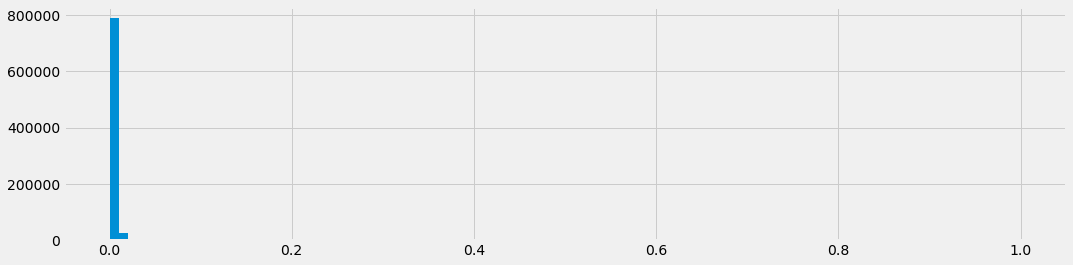

In [12]:
hist = ss.iloc[:, 1:].values.flatten()
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.hist(hist, bins=100)

In [13]:
oof_dataset = []
for oof in oof_list:
    oof_dataset.append(oof.iloc[:, 1:].values)
oof_dataset = np.stack(oof_dataset).transpose(1, 2, 0)
oof_dataset = oof_dataset[drop_idx]
print(oof_dataset.shape)
preds_dataset = []
for preds in preds_list:
    preds_dataset.append(preds.iloc[:, 1:].values)
preds_dataset = np.stack(preds_dataset).transpose(1, 2, 0)
print(preds_dataset.shape)

weighted_oof = np.zeros((len(oof_dataset), config["out_dim"]))
weighted_preds = np.zeros((len(preds_dataset), ntargets))

weights = np.array([0.036818, 0.005844, 0.955763, 0.001575])
for i, weight in enumerate(weights):
    weighted_oof += weight * oof_dataset[:,:,i]
    weighted_preds += weight * preds_dataset[:,:,i]

    
# calculate oof score
cv_score = mean_log_loss(train_targets, oof_targets)
logging.info(f"CV score: {cv_score:.6f}")
oof = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
oof.iloc[drop_idx, 1:] = weighted_oof
oof_path = "weighted_oof.csv"
oof.to_csv(oof_path, index=False)
logging.info(f"saved at {oof_path}")

ss = pd.read_csv("../input/lish-moa/sample_submission.csv")
ss.iloc[:,1:] = weighted_preds
ss.iloc[test_features["cp_type"] == "ctl_vehicle", 1:] = 0
sub_path = "submission.csv"
ss.to_csv(sub_path, index=False)
logging.info(f"saved at {sub_path}")

(21948, 206, 4)
(3982, 206, 4)


[INFO] 2020-11-30 14:20:55,924 >>	CV score: 0.013989
[INFO] 2020-11-30 14:21:13,648 >>	saved at weighted_oof.csv
[INFO] 2020-11-30 14:21:15,948 >>	saved at submission.csv


In [14]:
weighted_preds.shape

(3982, 206)

(array([8.00725e+05, 1.24070e+04, 2.96500e+03, 1.23800e+03, 6.48000e+02,
        3.88000e+02, 2.61000e+02, 1.73000e+02, 1.13000e+02, 7.30000e+01,
        7.60000e+01, 7.50000e+01, 4.40000e+01, 3.80000e+01, 3.90000e+01,
        3.10000e+01, 1.90000e+01, 2.40000e+01, 2.00000e+01, 3.10000e+01,
        1.50000e+01, 1.60000e+01, 2.10000e+01, 1.50000e+01, 1.30000e+01,
        4.00000e+00, 1.30000e+01, 6.00000e+00, 8.00000e+00, 7.00000e+00,
        4.00000e+00, 1.00000e+01, 5.00000e+00, 4.00000e+00, 7.00000e+00,
        4.00000e+00, 1.00000e+01, 8.00000e+00, 7.00000e+00, 3.00000e+00,
        6.00000e+00, 3.00000e+00, 3.00000e+00, 8.00000e+00, 7.00000e+00,
        2.00000e+00, 3.00000e+00, 3.00000e+00, 3.00000e+00, 5.00000e+00,
        7.00000e+00, 2.00000e+00, 5.00000e+00, 5.00000e+00, 4.00000e+00,
        7.00000e+00, 3.00000e+00, 2.00000e+00, 7.00000e+00, 7.00000e+00,
        2.00000e+00, 8.00000e+00, 3.00000e+00, 5.00000e+00, 5.00000e+00,
        3.00000e+00, 7.00000e+00, 2.00000e+00, 3.00

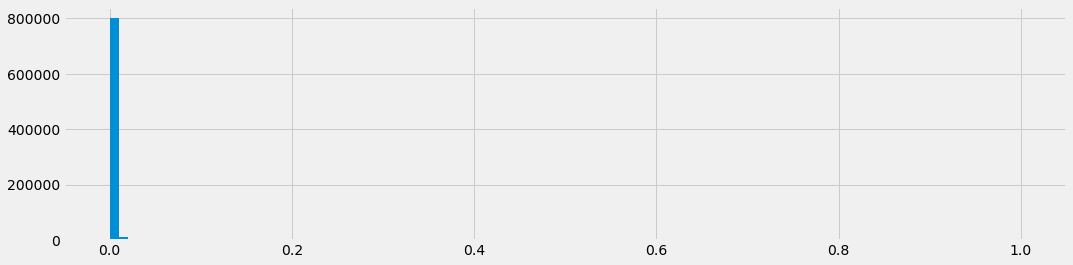

In [15]:
hist = ss.iloc[:, 1:].values.flatten()
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.hist(hist, bins=100)